In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from transformers import AutoModel, AutoTokenizer

from group_sae.utils import palette

/home/fbelotti/group-sae/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## FLOPs

In [ ]:
from torch.utils.flop_counter import FlopCounterMode

device = "cuda"

# Load GPT-2 model and tokenizer
model_name = "EleutherAI/pythia-1b-deduped"
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.to(device)
model.eval()
print("Model running on", device)

In [ ]:
N_TOKENS = 1e9
ctx_len = 1024
d_model = 2048
n_layers = 16
n_batches = N_TOKENS // ctx_len

In [ ]:
# Prepare a sample input with 1024 tokens
input_text = "Sample input."
input_text += " null" * (ctx_len - len(tokenizer(input_text)["input_ids"]))
inputs = tokenizer(input_text, return_tensors="pt")["input_ids"]
print(f"Input shape: {inputs.shape}")

cache = {}


def forward_hook(module, input, output):
    cache["output"] = output[0].flatten(0, 1)


model.layers[0].register_forward_hook(forward_hook)

# Enable flop counting
with FlopCounterMode(model) as flop_counter:
    with torch.no_grad():
        outputs = model(inputs.to(device))

# Retrieve FLOPs count
flops = flop_counter.get_total_flops() * n_batches
print(f"PFLOPs required for caching 1B tokens: {flops / 1e15:.2f} PFLOPs")

In [ ]:
import torch.nn as nn


# We use a standard SAE as FLOP count doesn't change between architectures.
class SAE(nn.Module):
    def __init__(self, c, sparsity=1):
        super(SAE, self).__init__()
        self.sparsity = sparsity
        self.encoder = nn.Linear(d_model, d_model * c)
        self.decoder = nn.Linear(d_model * c, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.encoder(x)
        h = self.relu(h)
        return self.decoder(h), h

    def get_loss(self, x, y):
        x_hat, h = self(x)
        l2_loss = (x_hat - y).pow(2).sum()
        fvu = l2_loss / x.pow(2).sum()
        l1_loss = h.abs().sum(-1).mean()
        print(f"l2_loss: {l2_loss.item()}, l1_loss: {l1_loss.item()}")
        return fvu + l1_loss * self.sparsity

In [ ]:
def training_step(sae, inputs, optimizer):
    optimizer.zero_grad()
    loss = sae.get_loss(inputs, inputs)
    loss.backward()
    optimizer.step()


c = 16

sae = SAE(c=c, sparsity=1)
sae.to(device)
optimizer = torch.optim.Adam(sae.parameters(), lr=1e-3)

In [ ]:
# Enable flop counting
with FlopCounterMode(sae) as flop_counter:
    training_step(sae, cache["output"], optimizer)

# Retrieve FLOPs count
flops = flop_counter.get_total_flops() * n_batches  # * n_layers
print(f"PFLOPs for the forward pass: {flops / 1e15:.2f} PFLOPs")

| Model       |  L |    D |       A |      T |
|-------------|----|------|---------|--------|
| Pythia-160m | 12 |  768 |  207.62 |  94.37 |
| Pythia-410m | 24 | 1024 |  704.64 | 167.77 |
| Pythia-1b   | 16 | 2048 | 1744.83 | 671.09 |

All results are in PFLOPs (1e15)

## AMD

In [2]:
import numpy as np

from group_sae import MODEL_MAP
from group_sae.utils import load_amds, load_cluster_map

columns = ["ce_loss_score", "delta_ce", "explained_variance", "mse", "l2_ratio", "layer", "G"]


def delta_ce(df):
    return (df["ce_loss_with_sae"] - df["ce_loss_without_sae"]) / df["ce_loss_without_sae"] * 100


def load_cluster_eval(size, include_baseline=False):
    nl = MODEL_MAP[f"pythia-{size}"]["n_layers"]

    labels = []
    clusters = []
    for c in load_cluster_map(size).values():
        lab_ = list(dict.fromkeys(c))
        label_map = {v: i for i, v in enumerate(lab_)}
        clusters += [label_map[i] for i in c]
        labels += c
    labels += [f"layers.{i}" for i in range(nl - 1)]
    clusters += list(range(nl - 1))

    cluster_eval = pd.read_csv(f"../eval/pythia-{size}_cluster.csv", index_col=0)
    cluster_eval["delta_ce"] = delta_ce(cluster_eval)
    cluster_eval = cluster_eval[columns]
    cluster_eval["label"] = labels[: len(cluster_eval)]
    cluster_eval.drop(columns="G", inplace=True)

    base_eval = pd.read_csv(f"../eval/pythia-{size}_baseline.csv", index_col=0)
    base_eval["delta_ce"] = delta_ce(base_eval)
    base_eval = base_eval[columns]
    base_eval["label"] = base_eval["layer"].apply(lambda x: f"layers.{x}")
    base_eval.drop(columns="G", inplace=True)

    unique_eval = pd.concat([base_eval, cluster_eval]).drop_duplicates()

    empty_evals = pd.DataFrame(
        {
            "layer": list(range(nl - 1)) * (nl - 1),
            "cluster": clusters,
            "label": labels,
            "G": np.arange(1, nl).repeat(nl - 1),
        }
    )
    eval = pd.merge(empty_evals, unique_eval, how="left").drop(columns="label")
    eval = eval.groupby(["G", "cluster", "layer"]).mean().reset_index()

    # Fill AMDs
    amd = load_amds(size, include_baseline)

    final = pd.merge(eval, amd, on="G")
    final["fvu"] = 1 - final["explained_variance"]
    return final


def get_inf_sup(df: pd.DataFrame, is_sorted: bool = False):
    df_sorted = df
    if not is_sorted:
        df_sorted = df.sort_values("AMD", ascending=False)
    end = (df_sorted["AMD"] >= 0.2).argmin()
    start = max(0, end - 1)
    return (start, end)

In [3]:
p160 = load_cluster_eval("160m", include_baseline=True)
p410 = load_cluster_eval("410m", include_baseline=True)
p1 = load_cluster_eval("1b", include_baseline=True)

In [4]:
base_160m = pd.read_csv("../eval/pythia-160m_baseline.csv", index_col=0)
base_160m["delta_ce"] = delta_ce(base_160m)
base_160m["fvu"] = 1 - base_160m["explained_variance"]
base_160m = base_160m[columns]

base_410m = pd.read_csv("../eval/pythia-410m_baseline.csv", index_col=0)
base_410m["delta_ce"] = delta_ce(base_410m)
base_410m["fvu"] = 1 - base_410m["explained_variance"]
base_410m = base_410m[columns]

base_1b = pd.read_csv("../eval/pythia-1b_baseline.csv", index_col=0)
base_1b["delta_ce"] = delta_ce(base_1b)
base_1b["fvu"] = 1 - base_1b["explained_variance"]
base_1b = base_1b[columns]

In [5]:
import pandas as pd


def plot_vs_amd(metric, ax):
    def plot_with_fill(data, color, ax):
        """Helper function to plot lines with fill for standard deviation"""
        sns.lineplot(data, x="AMD", y=metric, color=color, ax=ax, errorbar=None)  # No error bars

        # Compute mean and standard deviation for fill_between
        grouped = data.groupby("AMD")[metric].agg(["mean", "std"]).reset_index()
        ax.fill_between(
            grouped["AMD"],
            grouped["mean"] - grouped["std"] * 0.5,
            grouped["mean"] + grouped["std"] * 0.5,
            color=color,
            alpha=0.1  # Adjust alpha for transparency
        )

        return grouped

    # Plot p160 data
    p160_plot = plot_with_fill(p160, palette[0], ax)
    sns.scatterplot(p160_plot, x="AMD", y="mean", color=palette[0], ax=ax, legend=False, zorder=3)
    last_row = p160_plot.iloc[0]
    ax.scatter(last_row["AMD"], last_row["mean"], marker="*", s=120, color=palette[0], edgecolor="black", zorder=10)

    # Plot p410 data
    p410_plot = plot_with_fill(p410, palette[2], ax)
    sns.scatterplot(p410_plot, x="AMD", y="mean", color=palette[2], ax=ax, legend=False, zorder=3)
    last_row = p410_plot.iloc[0]
    ax.scatter(last_row["AMD"], last_row["mean"], marker="*", s=120, color=palette[2], edgecolor="black", zorder=10)

    # Plot p1 data
    p1_plot = plot_with_fill(p1, palette[3], ax)
    sns.scatterplot(p1_plot, x="AMD", y="mean", color=palette[3], ax=ax, legend=False, zorder=3)
    last_row = p1_plot.iloc[0]
    ax.scatter(last_row["AMD"], last_row["mean"], marker="*", s=120, color=palette[3], edgecolor="black", zorder=10)

    # Combine all data for min-max calculations
    all_ = pd.concat([p160_plot, p410_plot, p1_plot])
    max_ = all_["mean"].max()
    min_ = all_["mean"].min()
    delta = (max_ - min_) / 15

    # Add vertical dashed line at x = 0.2
    ax.vlines(0.2, max_ + delta, min_ - delta, colors="grey", linestyles="--", linewidth=0.8)

    # Color the region between x = 0.18 and x = 0.22
    #ax.axvspan(0.18, 0.22, color="lightgray", alpha=0.2)  # Light gray with transparency

    ax.set_xlabel("AMD")
    ax.tick_params(labelsize=8)  # Reduce tick size

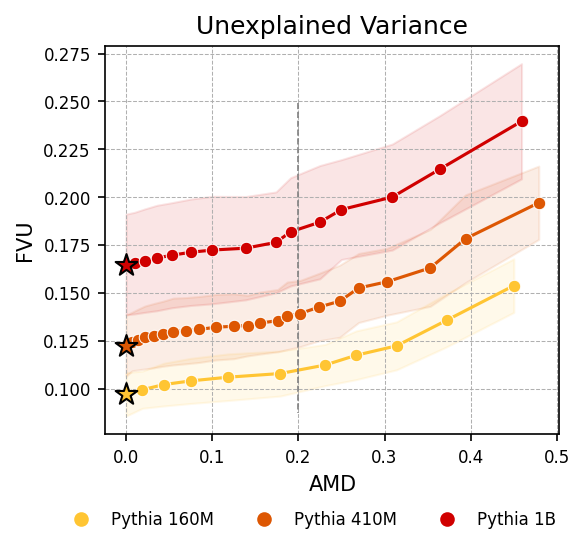

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=150, layout="tight")

plot_vs_amd("fvu", ax)
ax.set_ylabel("FVU")
ax.set_title("Unexplained Variance")
ax.grid(linestyle="--", linewidth=0.5)

# Create a single unique legend without a frame
handles = [
    plt.Line2D([0], [0], marker="o", color=palette[0], linestyle="", label="Pythia 160M"),
    plt.Line2D([0], [0], marker="o", color=palette[2], linestyle="", label="Pythia 410M"),
    plt.Line2D([0], [0], marker="o", color=palette[3], linestyle="", label="Pythia 1B"),
]
# bbox
fig.legend(
    handles=handles,
    loc="lower center",
    ncol=3,
    fontsize=8,
    frameon=False,
    bbox_to_anchor=(0.53, -0.05),
)
# fig.suptitle("AMD vs. Reconstruction metrics", fontsize=14)

os.makedirs("imgs", exist_ok=True)
plt.savefig("imgs/amd_vs_fvu.pdf", bbox_inches="tight", dpi=300)
plt.show()

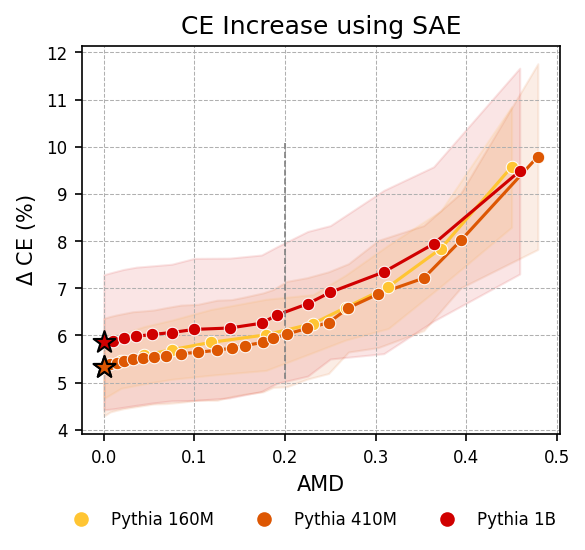

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=150, layout="tight")

plot_vs_amd("delta_ce", ax)
ax.set_ylabel(r"$\Delta$ CE (%)")
ax.set_title("CE Increase using SAE")
ax.grid(linestyle="--", linewidth=0.5)

# Create a single unique legend without a frame
handles = [
    plt.Line2D([0], [0], marker="o", color=palette[0], linestyle="", label="Pythia 160M"),
    plt.Line2D([0], [0], marker="o", color=palette[2], linestyle="", label="Pythia 410M"),
    plt.Line2D([0], [0], marker="o", color=palette[3], linestyle="", label="Pythia 1B"),
]
# bbox
fig.legend(
    handles=handles,
    loc="lower center",
    ncol=3,
    fontsize=8,
    frameon=False,
    bbox_to_anchor=(0.53, -0.05),
)
# fig.suptitle("AMD vs. Reconstruction metrics", fontsize=14)

os.makedirs("imgs", exist_ok=True)
plt.savefig("imgs/amd_vs_delta_ce.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [8]:
p160 = load_cluster_eval("160m", include_baseline=True)
p410 = load_cluster_eval("410m", include_baseline=True)
p1 = load_cluster_eval("1b", include_baseline=True)

p160["C_relative"] = p160["C"] / p160["C"].max()
p410["C_relative"] = p410["C"] / p410["C"].max()
p1["C_relative"] = p1["C"] / p1["C"].max()

In [9]:
p160_plot = p160.groupby("G").mean()
p160_plot["AMD"]

G
1     0.450
2     0.372
3     0.314
4     0.267
5     0.231
6     0.179
7     0.118
8     0.075
9     0.044
10    0.019
11    0.000
Name: AMD, dtype: float64

In [10]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_vs_flops(metric, ax, relative=False, highlight=True):
    """Plot metric vs. PFLOPs with shaded standard deviation region."""

    def plot_with_fill(data, x_col, color, ax):
        """Helper function to plot lines with fill for standard deviation."""
        sns.lineplot(data, x=x_col, y=metric, color=color, ax=ax, errorbar=None)  # No error bars

        # Compute mean and standard deviation for fill_between
        grouped = data.groupby(x_col)[metric].agg(["mean", "std"]).reset_index()
        ax.fill_between(
            grouped[x_col],
            grouped["mean"] - grouped["std"] * 0.5,
            grouped["mean"] + grouped["std"] * 0.5,
            color=color,
            alpha=0.1  # Adjust alpha for transparency
        )

        return grouped

    # Determine x-axis column
    x = "C" if not relative else "C_relative"

    # Plot for Pythia 160M
    p160_plot = plot_with_fill(p160, x, palette[0], ax)
    p160_plot = p160.groupby("G").mean()
    sns.scatterplot(data=p160_plot, x=x, y=metric, color=palette[0], ax=ax, legend=False)

    # Plot the last row as a star
    last_row = p160_plot.iloc[-1]
    ax.scatter(last_row[x], last_row[metric], marker="*", s=120, color=palette[0], edgecolor="black", zorder=10)

    if highlight:
        for idx in get_inf_sup(p160_plot, is_sorted=True)[1:]:
            ax.scatter(p160_plot.iloc[idx][x], p160_plot.iloc[idx][metric], marker="s", s=30, color=palette[0], edgecolor="black", zorder=10)

    # Plot for Pythia 410M
    p410_plot = plot_with_fill(p410, x, palette[2], ax)
    p410_plot = p410.groupby("G").mean()
    sns.scatterplot(data=p410_plot, x=x, y=metric, color=palette[2], ax=ax, legend=False)

    last_row = p410_plot.iloc[-1]
    ax.scatter(last_row[x], last_row[metric], marker="*", s=120, color=palette[2], edgecolor="black", zorder=10)

    if highlight:
        for idx in get_inf_sup(p410_plot, is_sorted=True)[1:]:
            ax.scatter(p410_plot.iloc[idx][x], p410_plot.iloc[idx][metric], marker="s", s=30, color=palette[2], edgecolor="black", zorder=10)

    # Plot for Pythia 1B
    p1_plot = plot_with_fill(p1, x, palette[3], ax)
    p1_plot = p1.groupby("G").mean()
    sns.scatterplot(data=p1_plot, x=x, y=metric, color=palette[3], ax=ax, legend=False)

    last_row = p1_plot.iloc[-1]
    ax.scatter(last_row[x], last_row[metric], marker="*", s=120, color=palette[3], edgecolor="black", zorder=10)

    if highlight:
        for idx in get_inf_sup(p1_plot, is_sorted=True)[1:]:
            ax.scatter(p1_plot.iloc[idx][x], p1_plot.iloc[idx][metric], marker="s", s=30, color=palette[3], edgecolor="black", zorder=10)

    # (Optional) Adjust the x-axis to log-scale and tick parameters
    ax.set_xlabel("PFLOPs")
    if not relative:
        ax.set_xscale("log")
    ax.tick_params(labelsize=8)  # Reduce tick label size

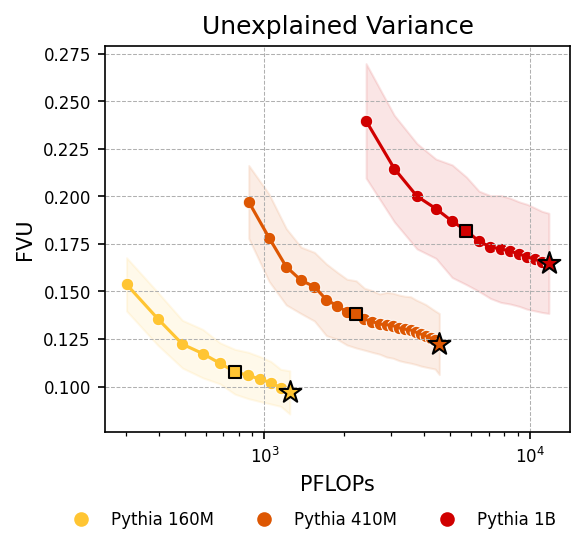

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=150, layout="tight")
ax.grid(linestyle="--", linewidth=0.5)

# Plot the two metrics
plot_vs_flops("fvu", ax)
ax.set_ylabel("FVU")
ax.set_title("Unexplained Variance")

# Create a single unique legend without a frame
handles = [
    plt.Line2D([0], [0], marker="o", color=palette[0], linestyle="", label="Pythia 160M"),
    plt.Line2D([0], [0], marker="o", color=palette[2], linestyle="", label="Pythia 410M"),
    plt.Line2D([0], [0], marker="o", color=palette[3], linestyle="", label="Pythia 1B"),
]
fig.legend(
    handles=handles,
    loc="lower center",
    ncol=3,
    fontsize=8,
    frameon=False,
    bbox_to_anchor=(0.53, -0.05),
)
os.makedirs("imgs", exist_ok=True)
plt.savefig("imgs/flops_vs_fvu.svg", bbox_inches="tight", dpi=300)
plt.show()

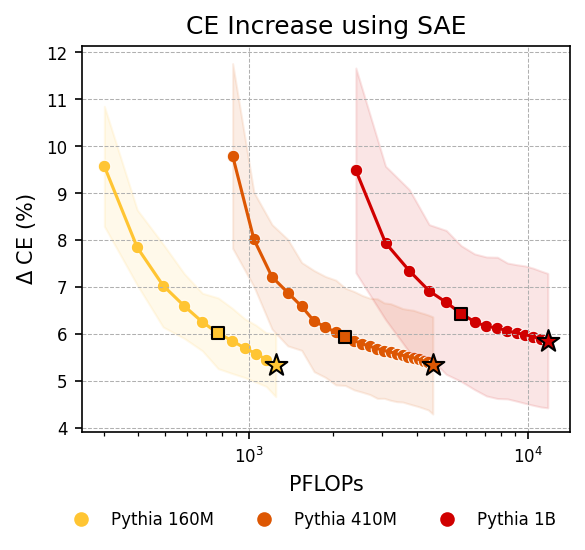

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=150, layout="tight")
ax.grid(linestyle="--", linewidth=0.5)

plot_vs_flops("delta_ce", ax)
ax.set_ylabel(r"$\Delta$ CE (%)")
ax.set_title("CE Increase using SAE")

# Create a single unique legend without a frame
handles = [
    plt.Line2D([0], [0], marker="o", color=palette[0], linestyle="", label="Pythia 160M"),
    plt.Line2D([0], [0], marker="o", color=palette[2], linestyle="", label="Pythia 410M"),
    plt.Line2D([0], [0], marker="o", color=palette[3], linestyle="", label="Pythia 1B"),
]
fig.legend(
    handles=handles,
    loc="lower center",
    ncol=3,
    fontsize=8,
    frameon=False,
    bbox_to_anchor=(0.53, -0.05),
)
os.makedirs("imgs", exist_ok=True)
plt.savefig("imgs/flops_vs_delta_ce.svg", bbox_inches="tight", dpi=300)
plt.show()

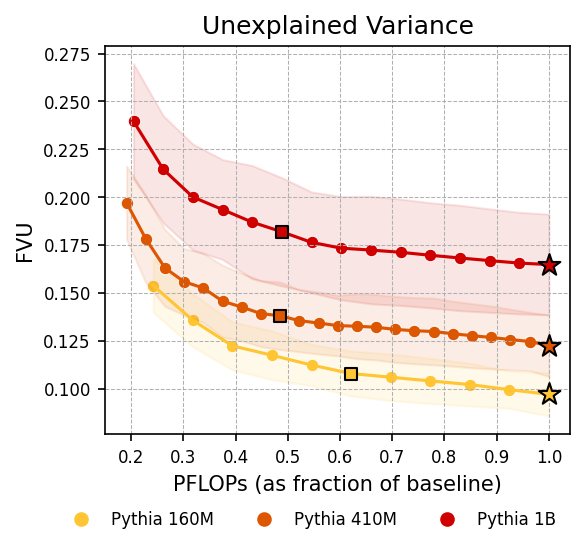

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=150, layout="tight")
ax.grid(linestyle="--", linewidth=0.5)

# Plot the two metrics
plot_vs_flops("fvu", ax, relative=True)
ax.set_ylabel("FVU")
ax.set_title("Unexplained Variance")
ax.set_xlabel("PFLOPs (as fraction of baseline)")


# all_ = pd.concat([p160_plot, p410_plot, p1_plot])
# max_ = all_["explained_variance"].max()
# min_ = all_["explained_variance"].min()
# delta = (max_ - min_) / 15
# ax.vlines(0.45, max_+delta, min_-delta, colors="grey", linestyles="--", linewidth=0.8)
# ax.axvspan(0.4, 0.5, color="lightgray", alpha=0.2)  # Light gray with transparency

# Create a single unique legend without a frame
handles = [
    plt.Line2D([0], [0], marker="o", color=palette[0], linestyle="", label="Pythia 160M"),
    plt.Line2D([0], [0], marker="o", color=palette[2], linestyle="", label="Pythia 410M"),
    plt.Line2D([0], [0], marker="o", color=palette[3], linestyle="", label="Pythia 1B"),
]
fig.legend(
    handles=handles,
    loc="lower center",
    ncol=3,
    fontsize=8,
    frameon=False,
    bbox_to_anchor=(0.53, -0.05),
)
os.makedirs("imgs", exist_ok=True)
plt.savefig("imgs/relative_flops_vs_fvu.svg", bbox_inches="tight", dpi=300)
plt.show()

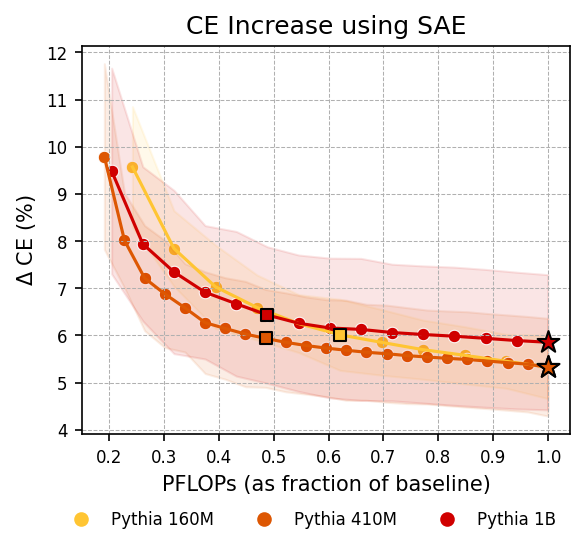

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=150, layout="tight")
ax.grid(linestyle="--", linewidth=0.5)

plot_vs_flops("delta_ce", ax, relative=True)
ax.set_ylabel(r"$\Delta$ CE (%)")
ax.set_title("CE Increase using SAE")
ax.set_xlabel("PFLOPs (as fraction of baseline)")


# all_ = pd.concat([p160_plot, p410_plot, p1_plot])
# max_ = all_["explained_variance"].max()
# min_ = all_["explained_variance"].min()
# delta = (max_ - min_) / 15
# ax[0].vlines(0.45, max_+delta, min_-delta, colors="grey", linestyles="--", linewidth=0.8)
# ax[0].axvspan(0.4, 0.5, color="lightgray", alpha=0.2)  # Light gray with transparency

# Create a single unique legend without a frame
handles = [
    plt.Line2D([0], [0], marker="o", color=palette[0], linestyle="", label="Pythia 160M"),
    plt.Line2D([0], [0], marker="o", color=palette[2], linestyle="", label="Pythia 410M"),
    plt.Line2D([0], [0], marker="o", color=palette[3], linestyle="", label="Pythia 1B"),
]
fig.legend(
    handles=handles,
    loc="lower center",
    ncol=3,
    fontsize=8,
    frameon=False,
    bbox_to_anchor=(0.53, -0.05),
)
plt.savefig("imgs/relative_flops_vs_delta_ce.svg", bbox_inches="tight", dpi=300)
plt.show()

## Single-layer Reconstruction 

In [15]:
p160 = load_cluster_eval("160m", include_baseline=True)
p410 = load_cluster_eval("410m", include_baseline=True)
p1 = load_cluster_eval("1b", include_baseline=True)
eval_dict = {"160M": p160, "410M": p410, "1B": p1}

In [17]:
ylabel_map = {
    "delta_ce": r"$\Delta$% CE",
    "explained_variance": "$R^2$",
    "fvu": "FVU",
    "mse": "$L_2$",
    "l0": "$L_0$",
}

y_lim_map = {
    "delta_ce": (0, 15.5),
    "explained_variance": (0, 1.05),
    "fvu": (0, 0.3),
    "mse": (0, 110),
    "l0": (0, 250),
}

offset_map = {"delta_ce": 0.2, "explained_variance": 0.01, "fvu": 0.01, "mse": 1, "l0": 5}

In [20]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

suptitle_fontsize = 16
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12
annot_fontsize = 6.5

label_pad = 8
title_pad = 10


def plot_reconstruction_single_layer(size, G, save=False, over_bar_text: bool = False):
    # Create a figure with 2 subplots in a 1x2 layout
    fig, ax = plt.subplots(1, 2, figsize=(14, 4.5), dpi=150, layout="tight")

    # Get the cluster IDs for the specific k value
    size = size.upper()
    n_layers = MODEL_MAP[f"pythia-{size.lower()}"]["n_layers"]
    eval_df = eval_dict[size]
    sub_df = eval_df[(eval_df["G"] == G) | (eval_df["G"] == n_layers - 1)]
    expanded_palette = sns.blend_palette(palette, n_colors=len(sub_df["cluster"].unique()) - 1)
    expanded_palette.append("#ced4da")

    # Loop over the metrics and create each subplot
    for i, metric in enumerate(["fvu", "delta_ce"]):
        # Loop over each layer and add it to the plot
        for layer in np.arange(n_layers - 1):
            subset = sub_df[sub_df["layer"] == layer]

            # Choose colors: first element for the Baseline, second for the comparison
            subset_colors = [expanded_palette[subset["cluster"].iloc[0]], "#ced4da"]

            sns.barplot(
                data=subset,
                x="layer",
                y=metric,
                hue="G",
                dodge=True,
                ax=ax[i],
                zorder=2,
                palette=subset_colors,
                legend=False,
            )
            if over_bar_text:
                delta_pct = (
                    (subset[metric].iloc[0] - subset[metric].iloc[1])
                    / subset[metric].iloc[0]
                    * 100
                )
                ax[i].text(
                    layer,
                    max(subset[metric])
                    + offset_map[metric],  # Position text slightly above the bar
                    f"{'+' if delta_pct >= 0 else '-'}{abs(delta_pct):.1f}%",
                    ha="center",
                    va="bottom",
                    fontsize=annot_fontsize,
                    color="black",
                    rotation=-0,
                )

        ylims = (0, 0.3) if metric == "fvu" else (0, sub_df["delta_ce"].max() + 2)

        # Add vertical lines to separate layer groups
        c = 0
        z = 1
        for j, new_c in enumerate(
            sub_df[sub_df["G"] == G]["cluster"]
        ):  # Avoid adding a line after the last layer
            if new_c != c:
                ax[i].axvline(x=j - 0.5, color="black", linestyle="--", linewidth=0.8)
                c = new_c
                ax[i].text(
                    j - 0.5 - z * 0.5 if c > 1 else j - z * 0.5,
                    ylims[1] * 0.99,
                    f"$g_{{{c-1}}}$",
                    ha="center",
                    va="top",
                    fontsize=annot_fontsize + 1.5,
                    color="black",
                )
                z = 0
            z += 1
        ax[i].text(
            n_layers - 1 - 0.5 - z * 0.5,
            ylims[1] * 0.99,
            f"$g_{{{c}}}$",
            ha="center",
            va="top",
            fontsize=annot_fontsize + 1.5,
            color="black",
        )

        ax[i].set_title(ylabel_map[metric], pad=title_pad, fontsize=label_fontsize)
        ax[i].set_ylim(ylims)
        ax[i].set_xlabel("Layer", labelpad=label_pad, fontsize=label_fontsize)
        ax[i].set_ylabel("")
        ax[i].tick_params(axis="x", labelsize=tick_fontsize)
        ax[i].tick_params(axis="y", labelsize=tick_fontsize)
        ax[i].grid(color="#adb5bd", linestyle="--", linewidth=0.5)

        # For the right plot, add a plus sign and percent symbol to the y-tick labels
        if i == 1:
            ax[i].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}%"))

    plt.suptitle(f"Pythia {size} - G{G}", fontsize=suptitle_fontsize)
    plt.subplots_adjust(hspace=0.4)

    if save:
        plt.savefig(f"imgs/layer_recon_{size}_G{G}.pdf", dpi=300, bbox_inches="tight")

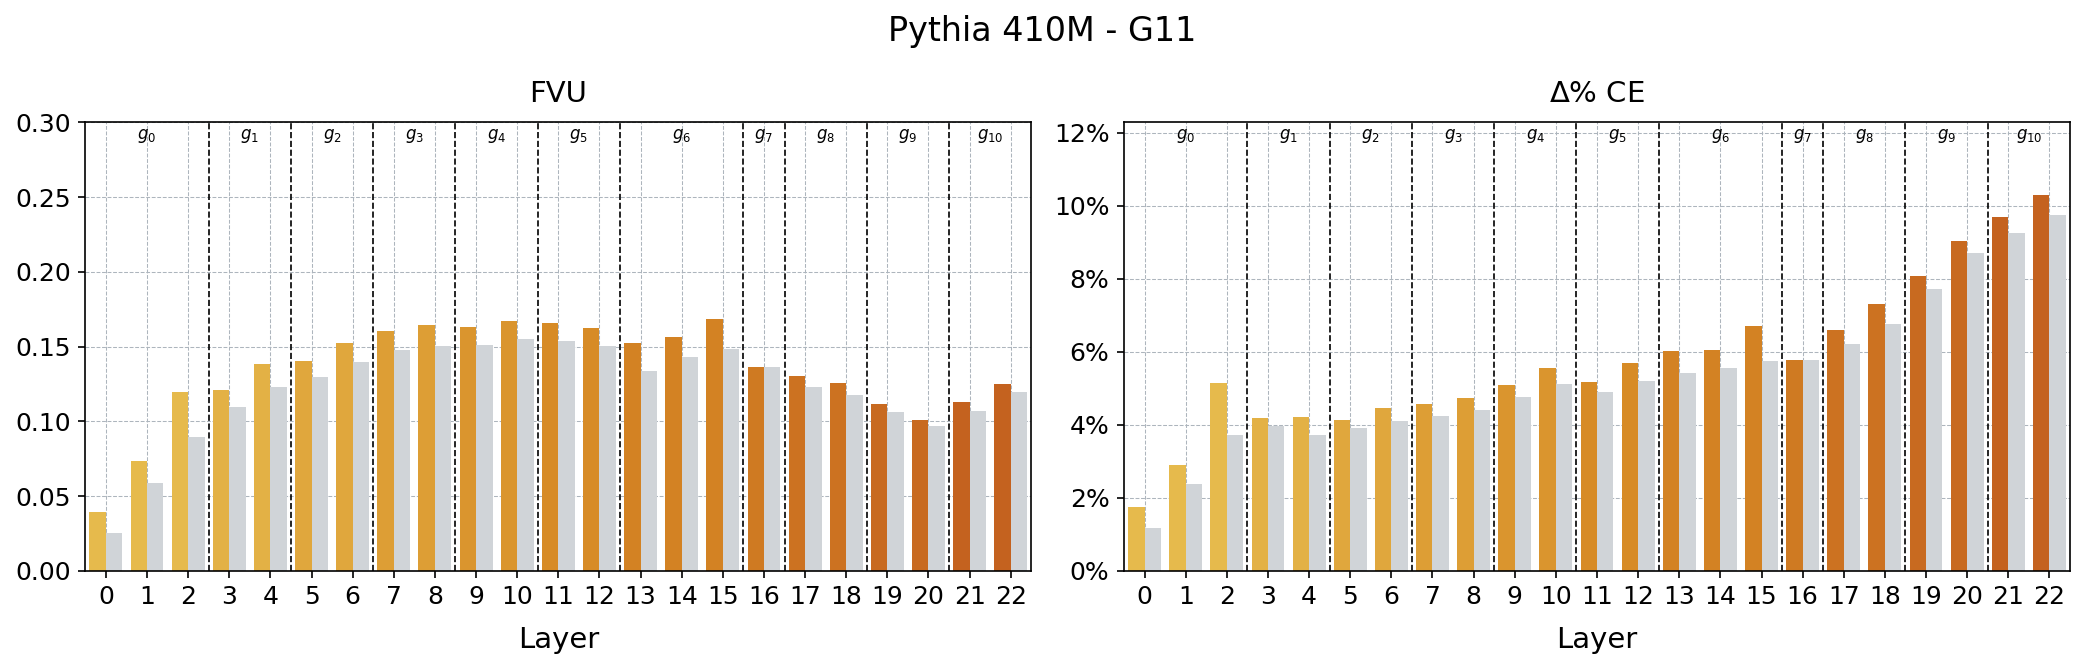

In [21]:
plot_reconstruction_single_layer("410M", 11, save=False)

/tmp/ipykernel_332420/1853081114.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(14, 4.5), dpi=150, layout="tight")


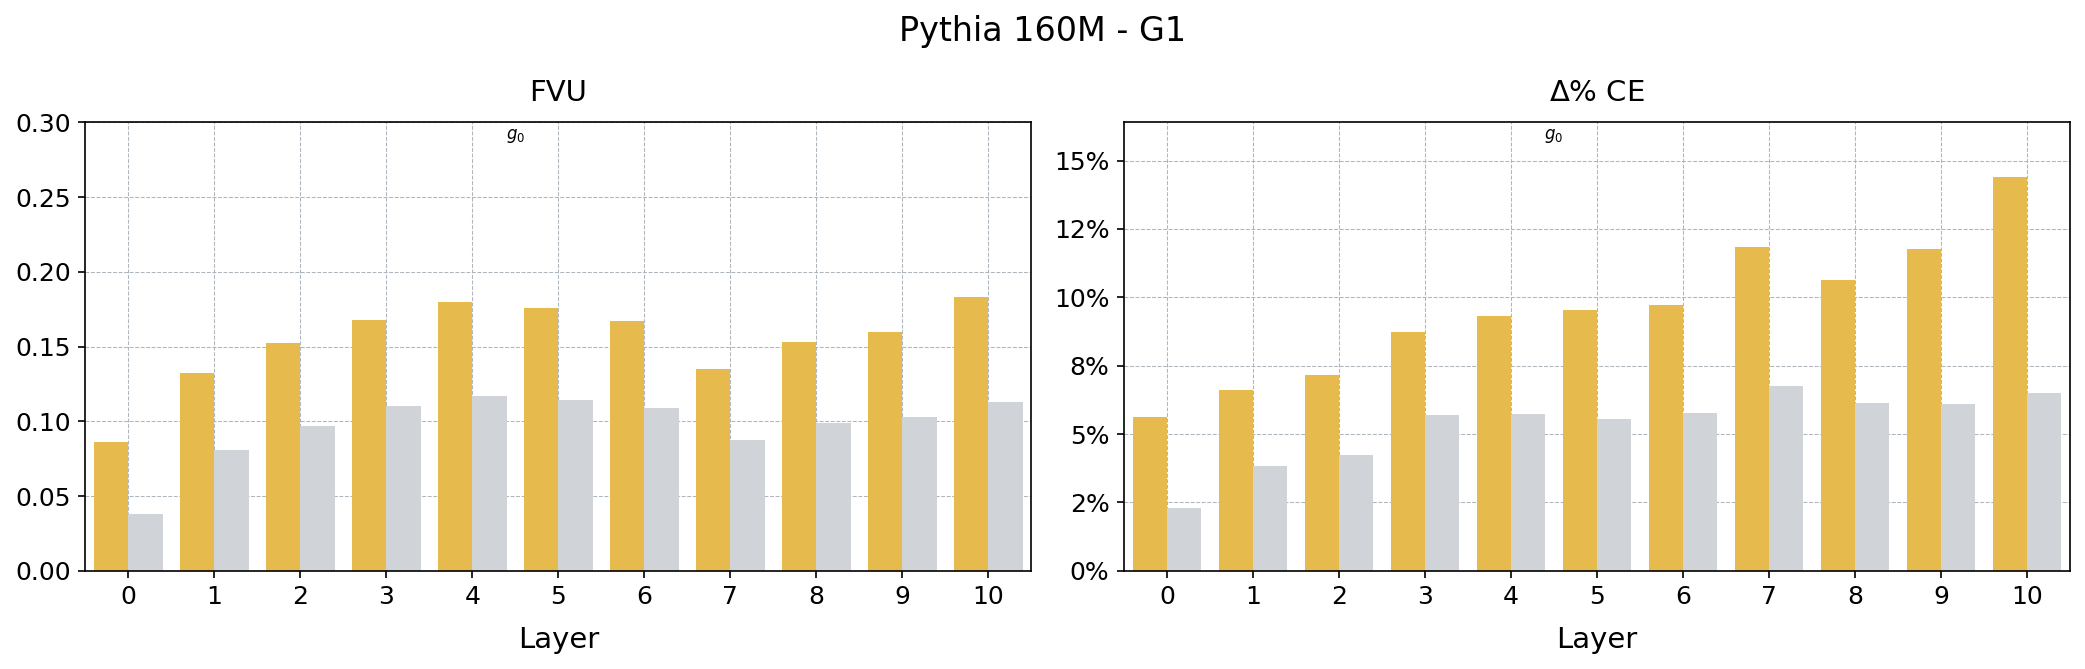

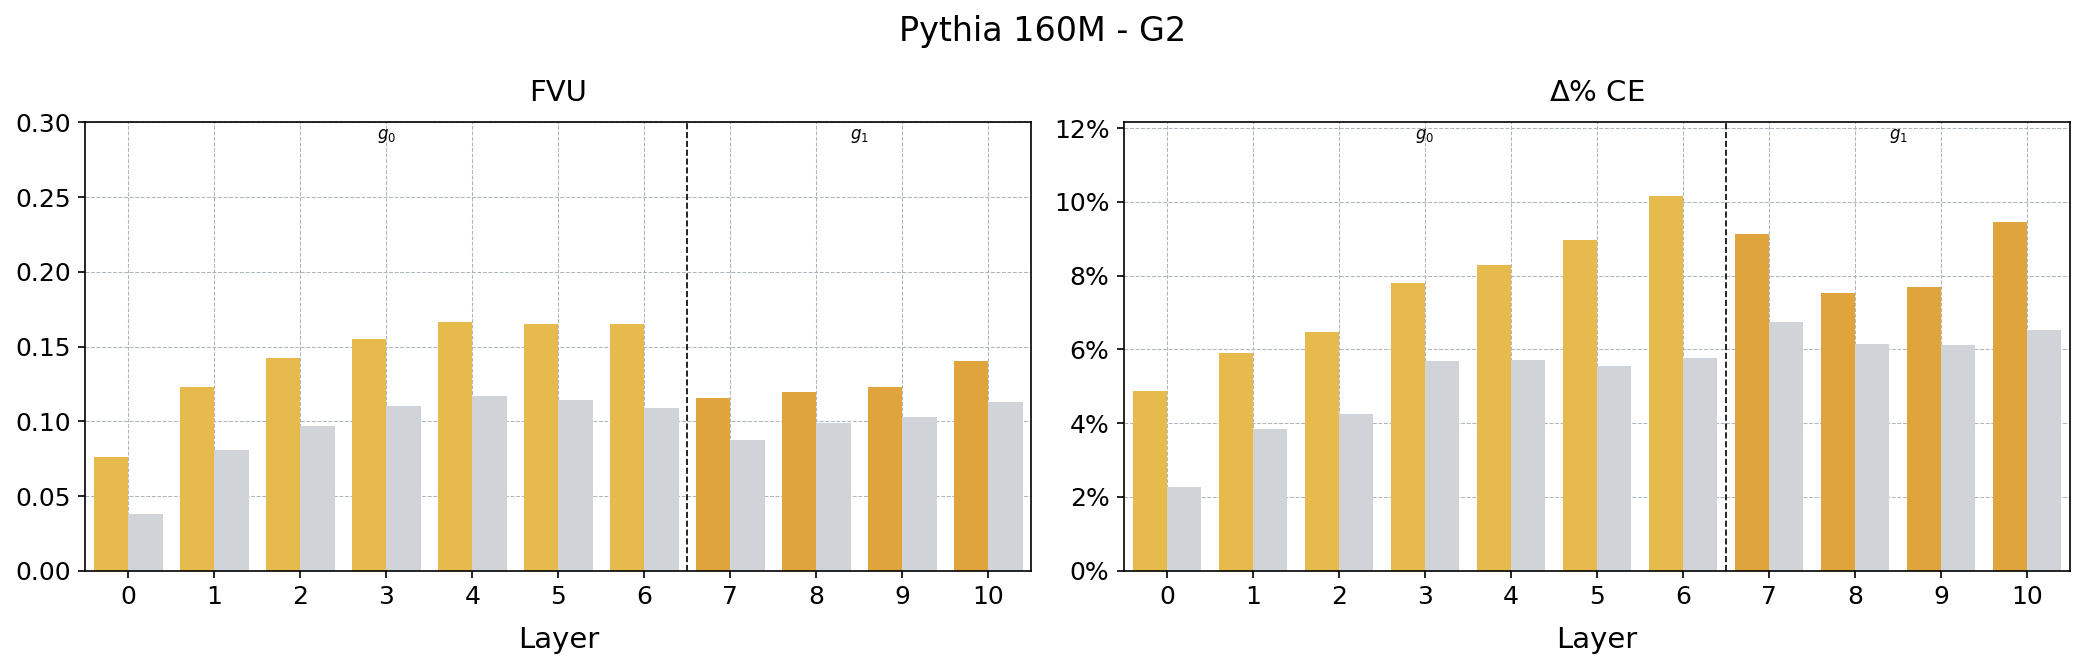

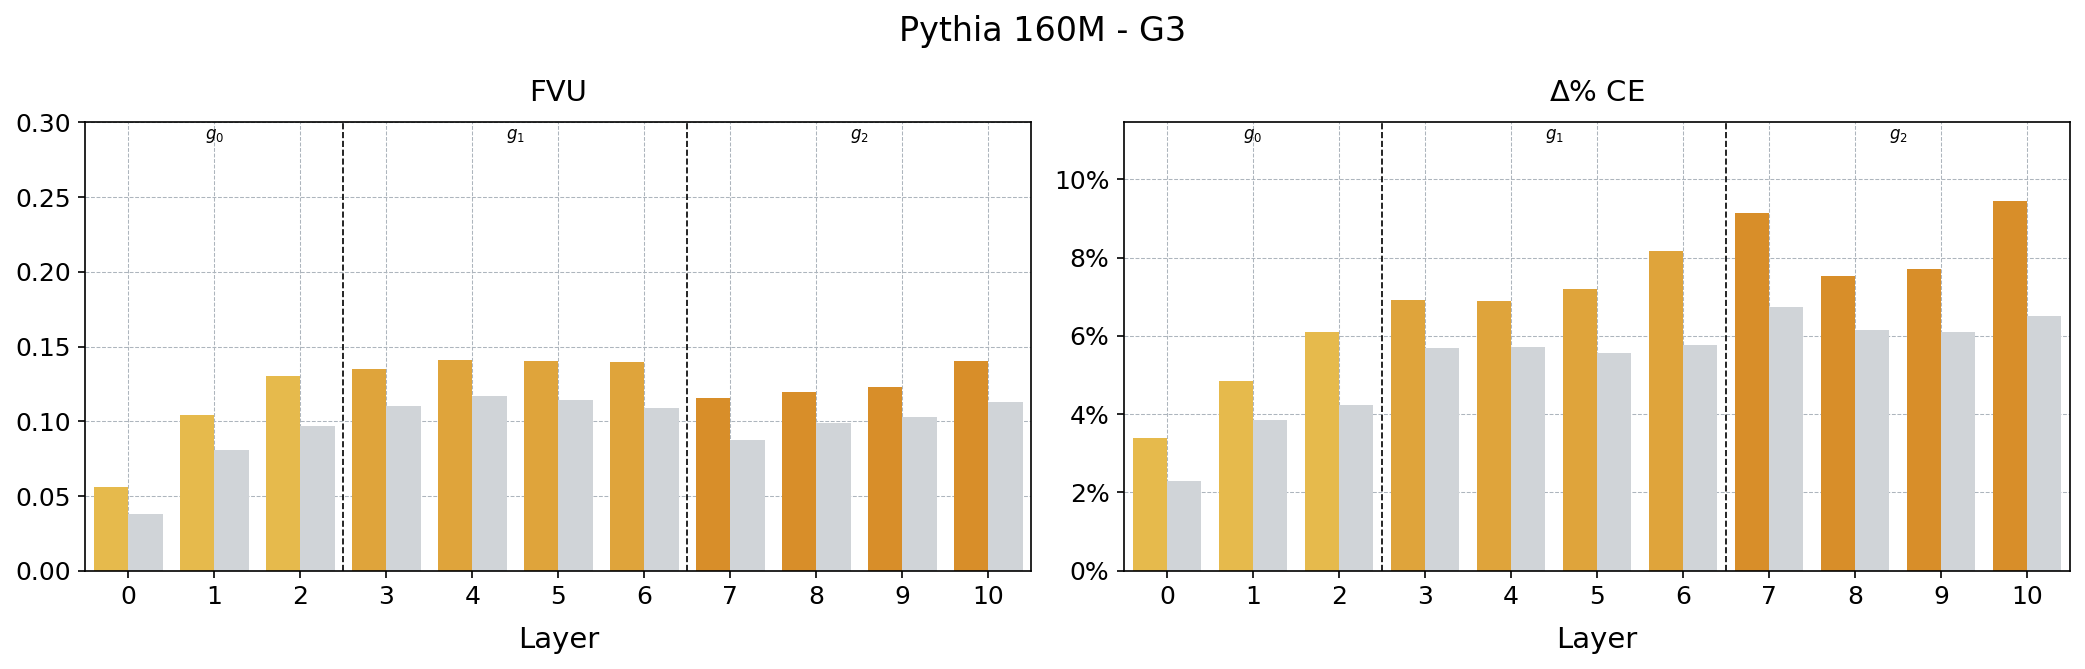

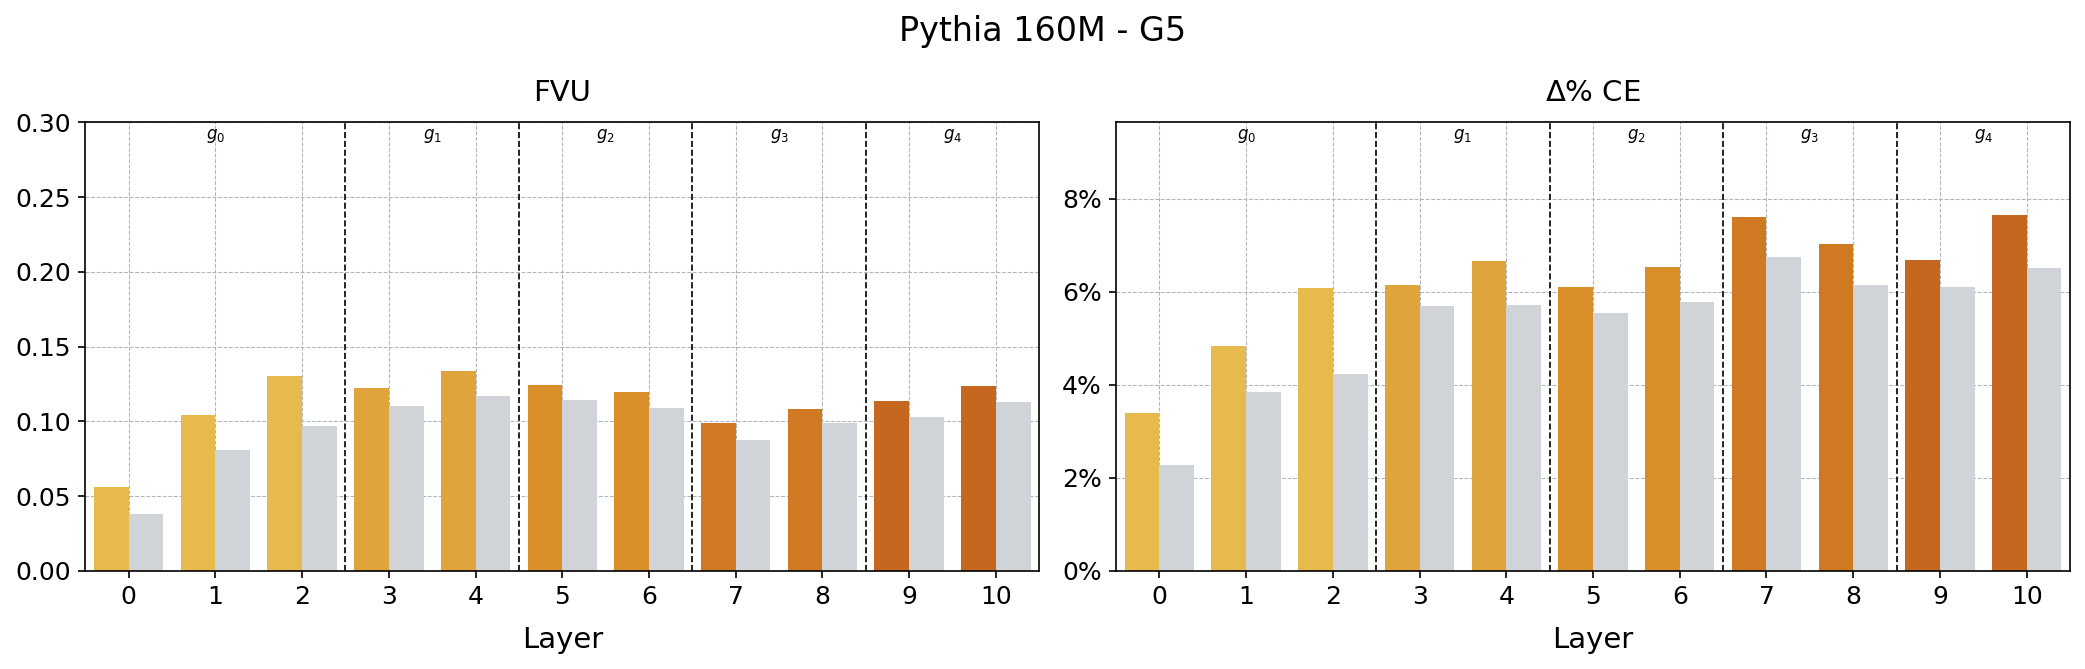

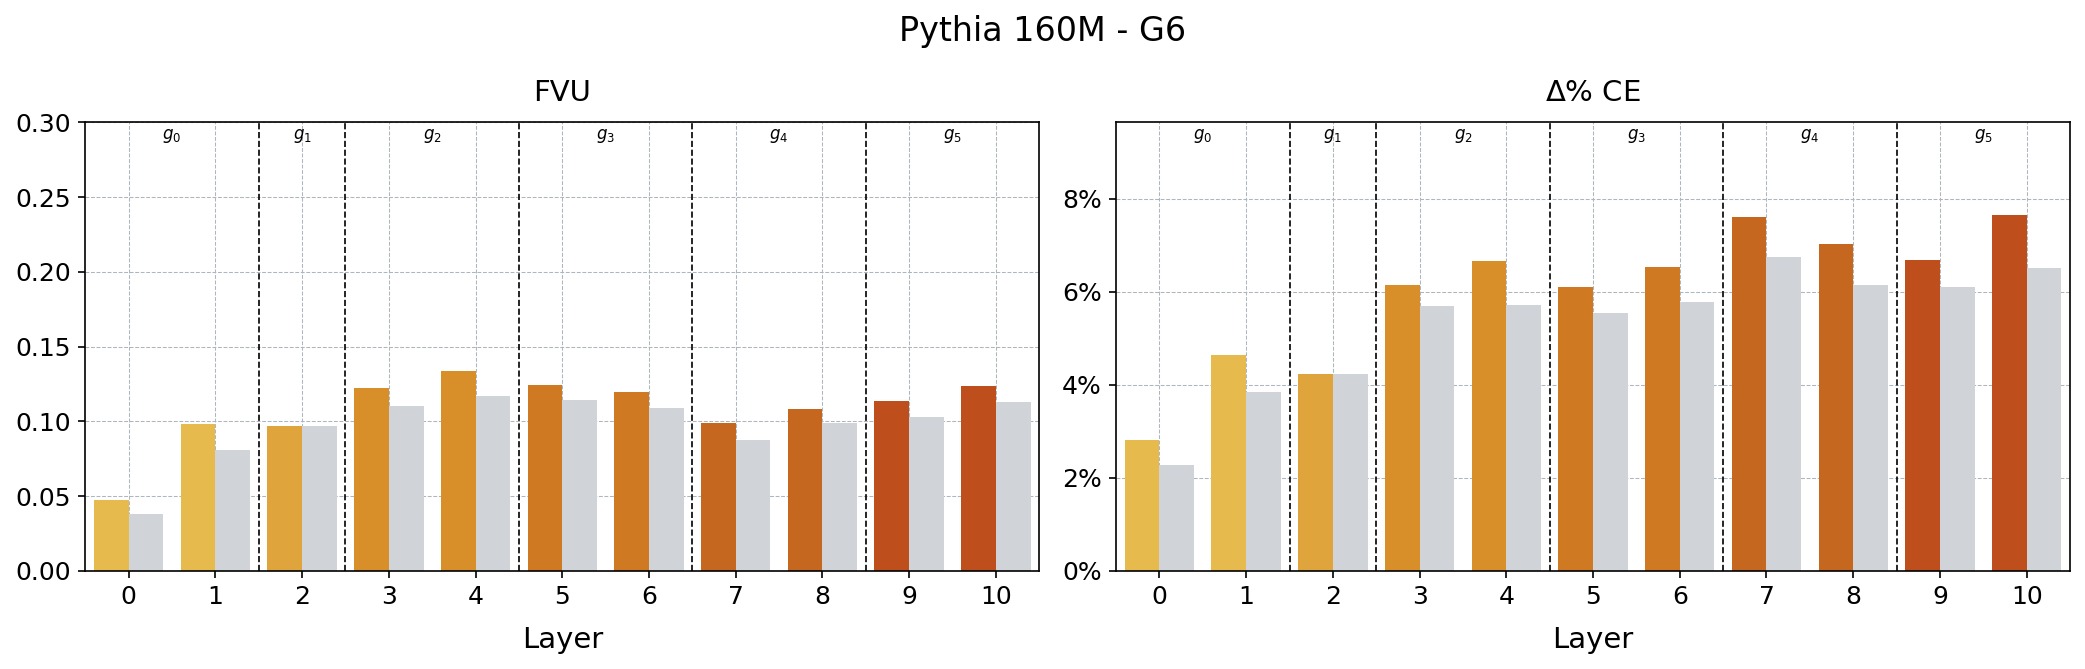

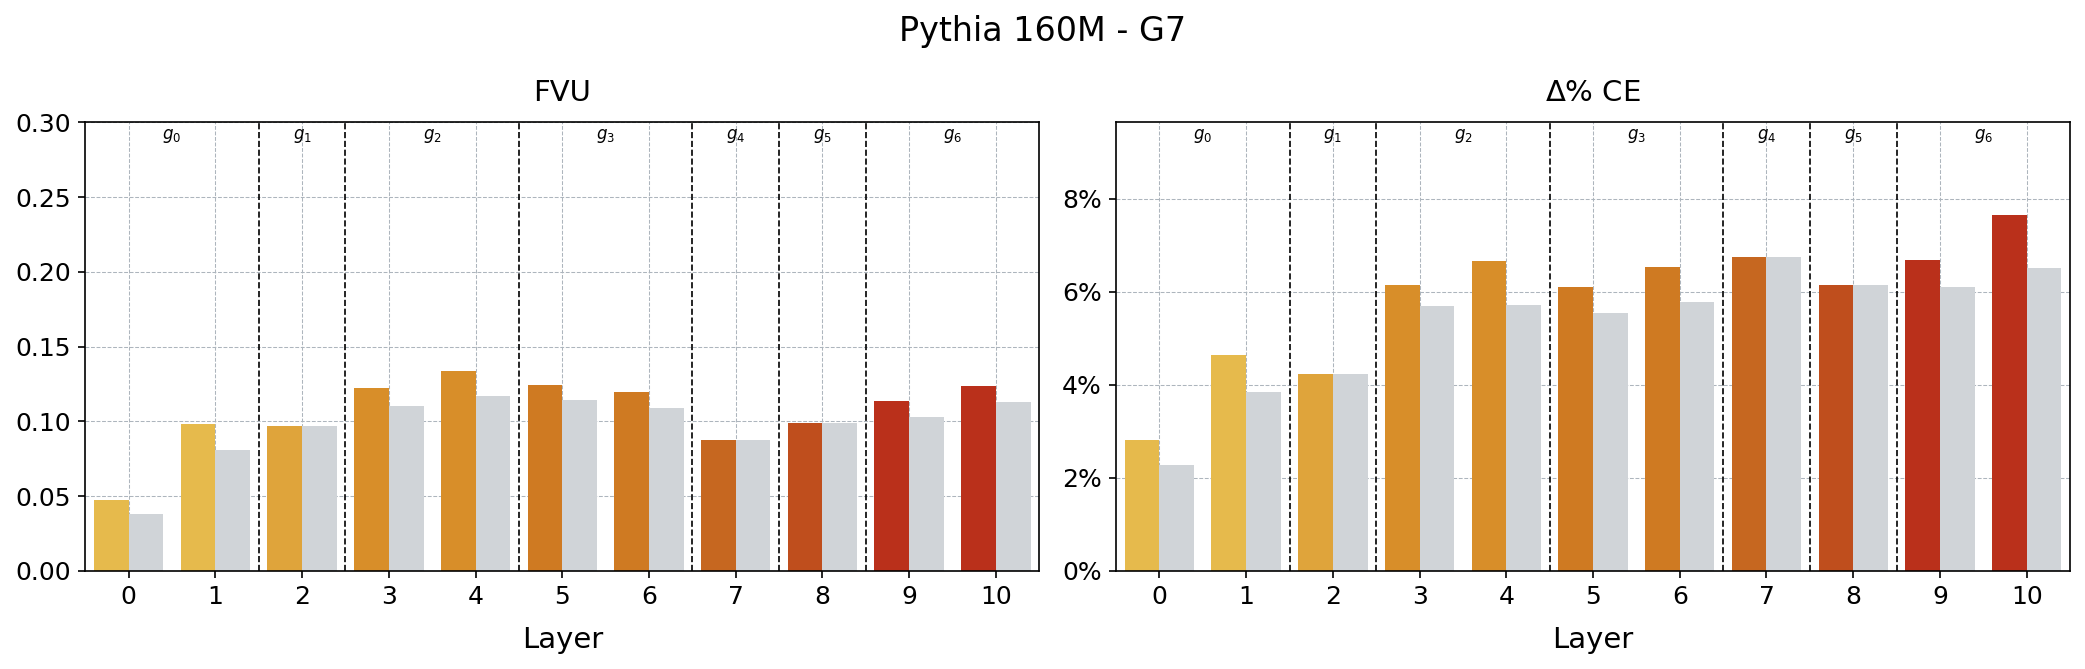

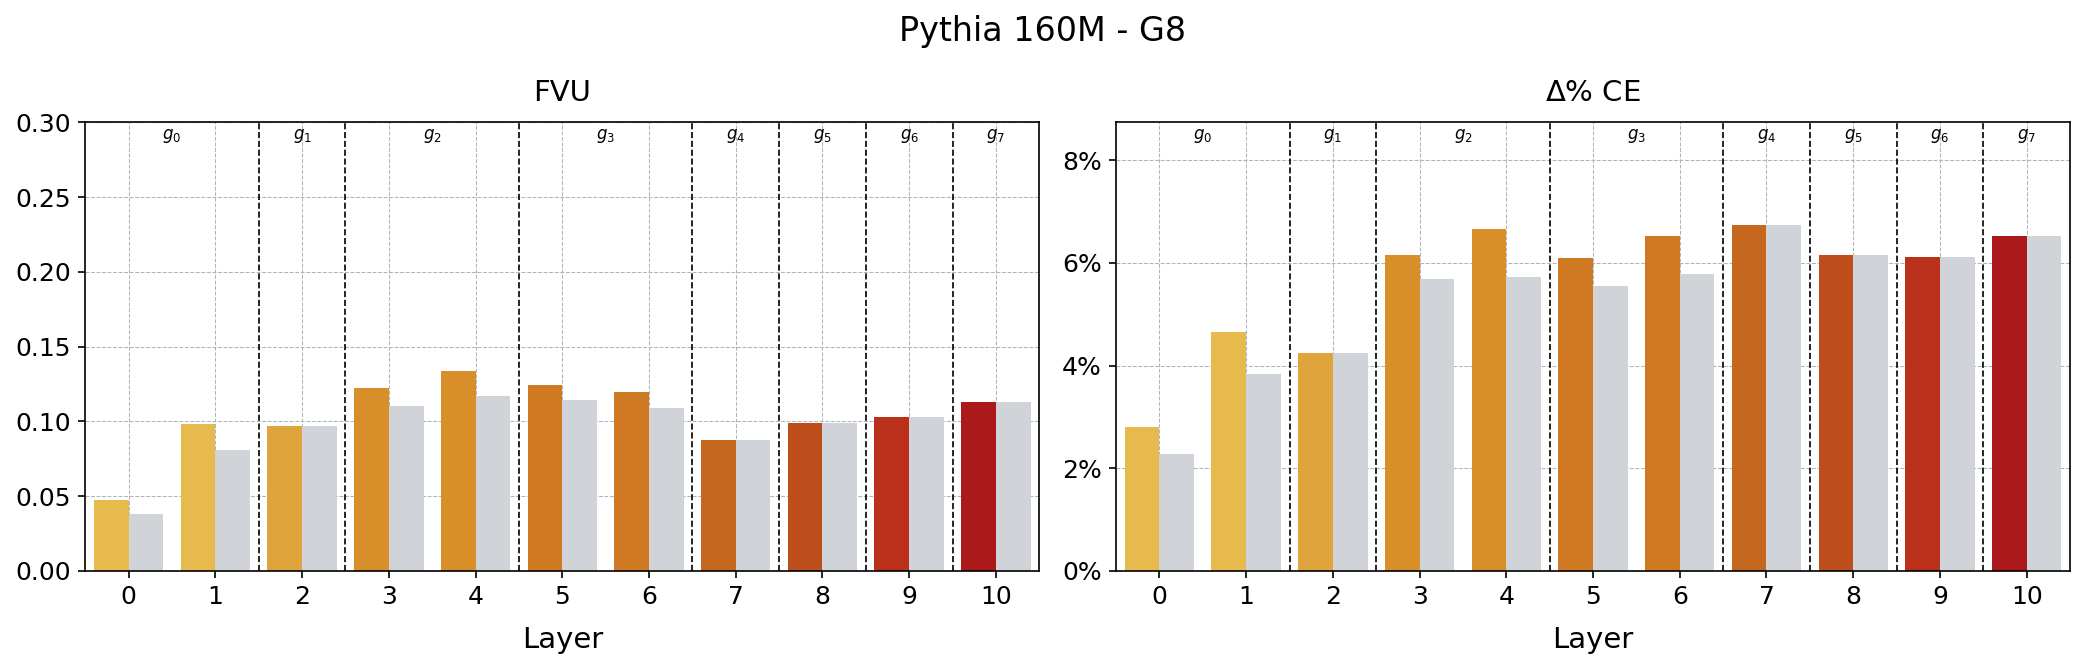

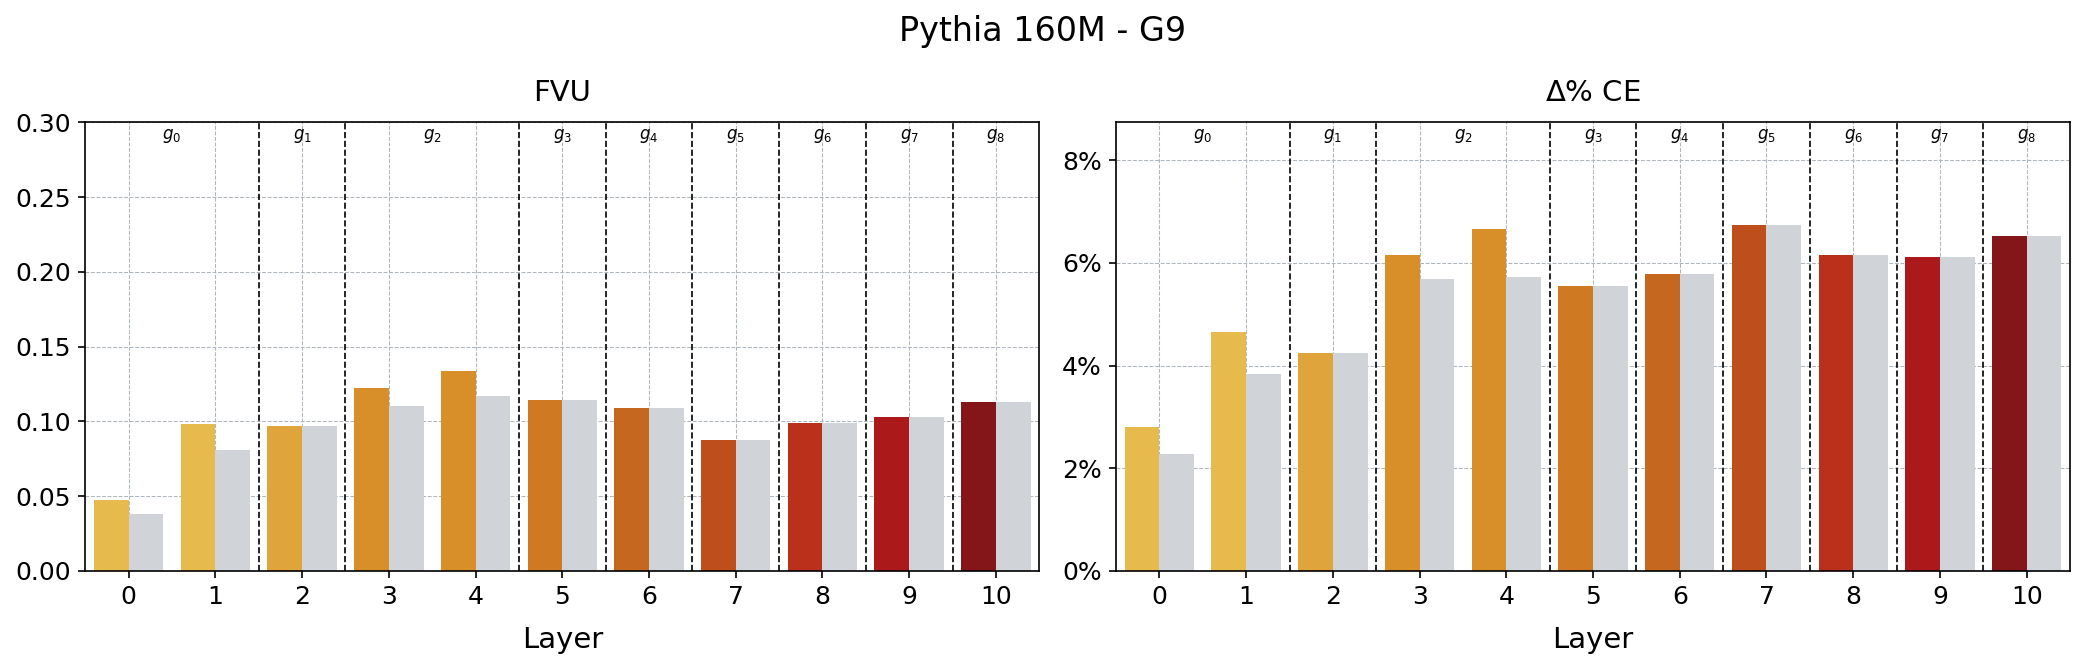

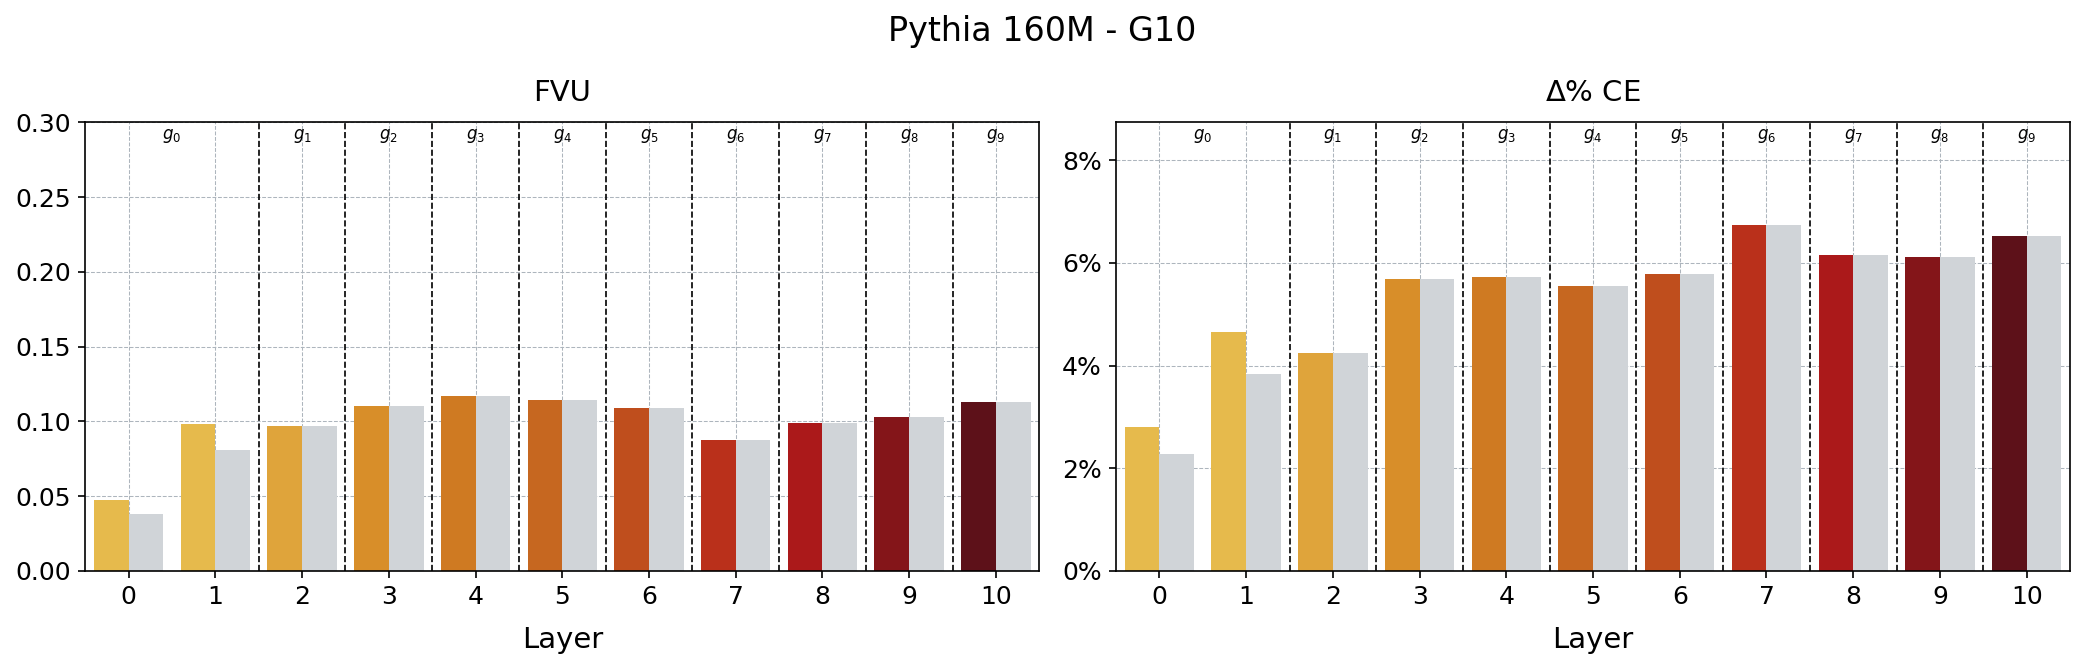

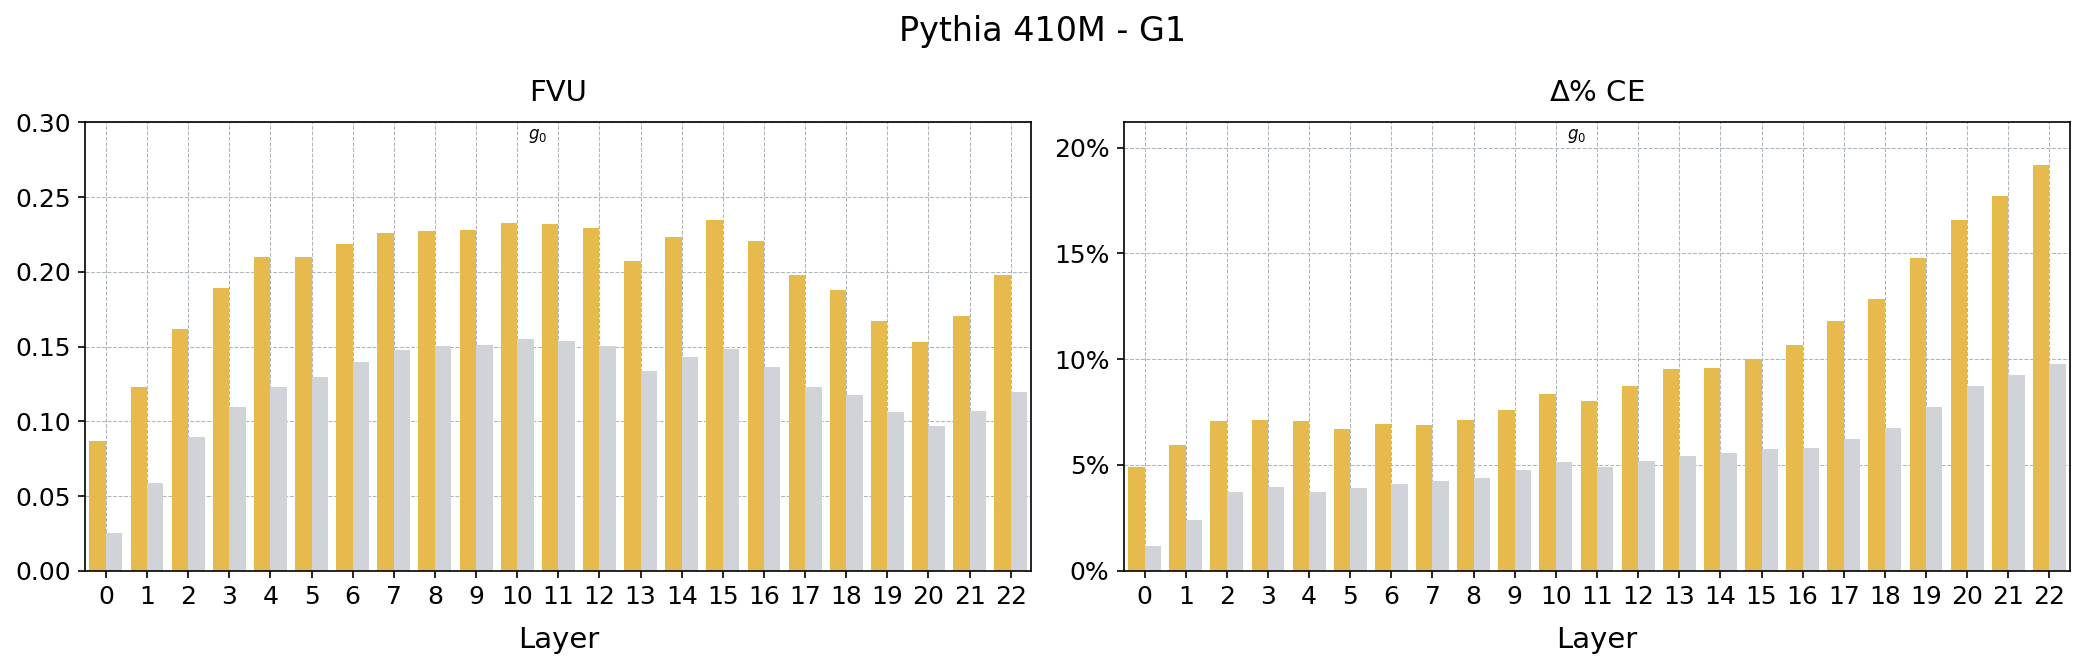

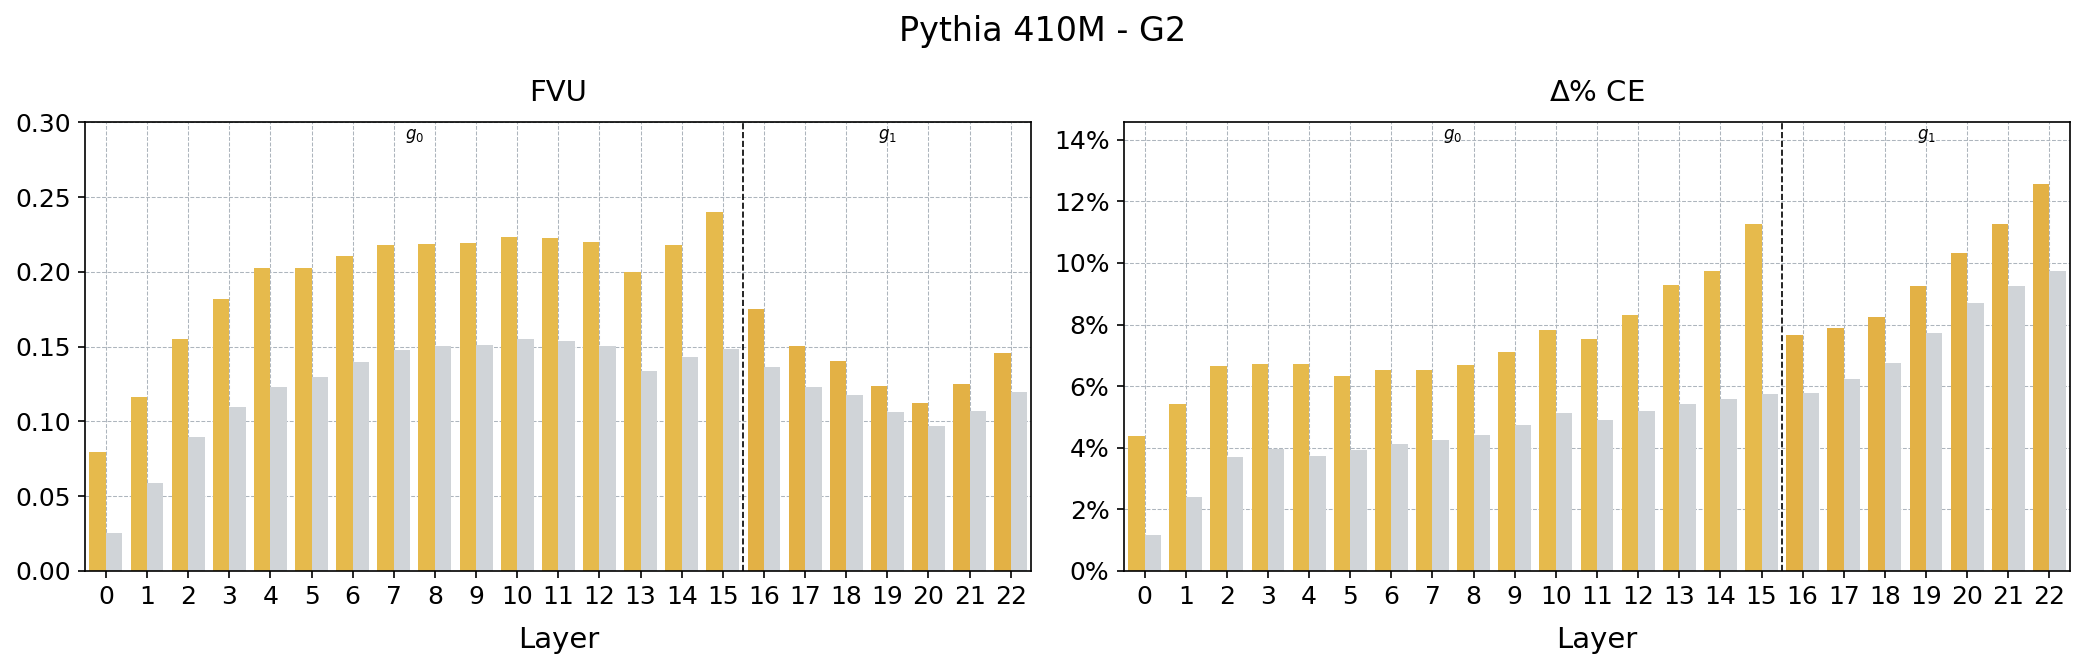

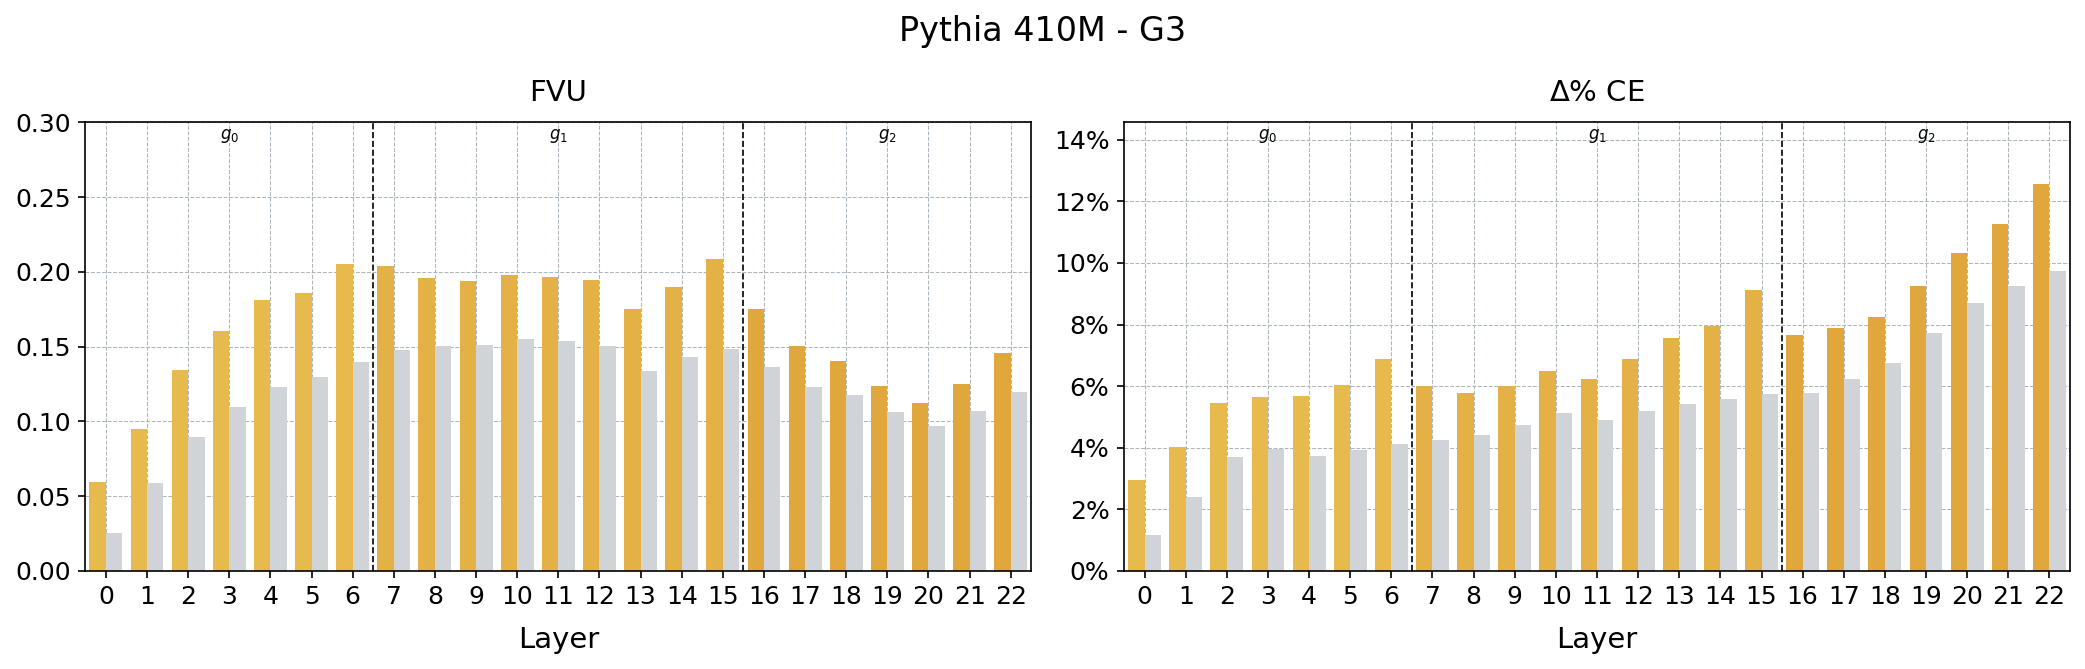

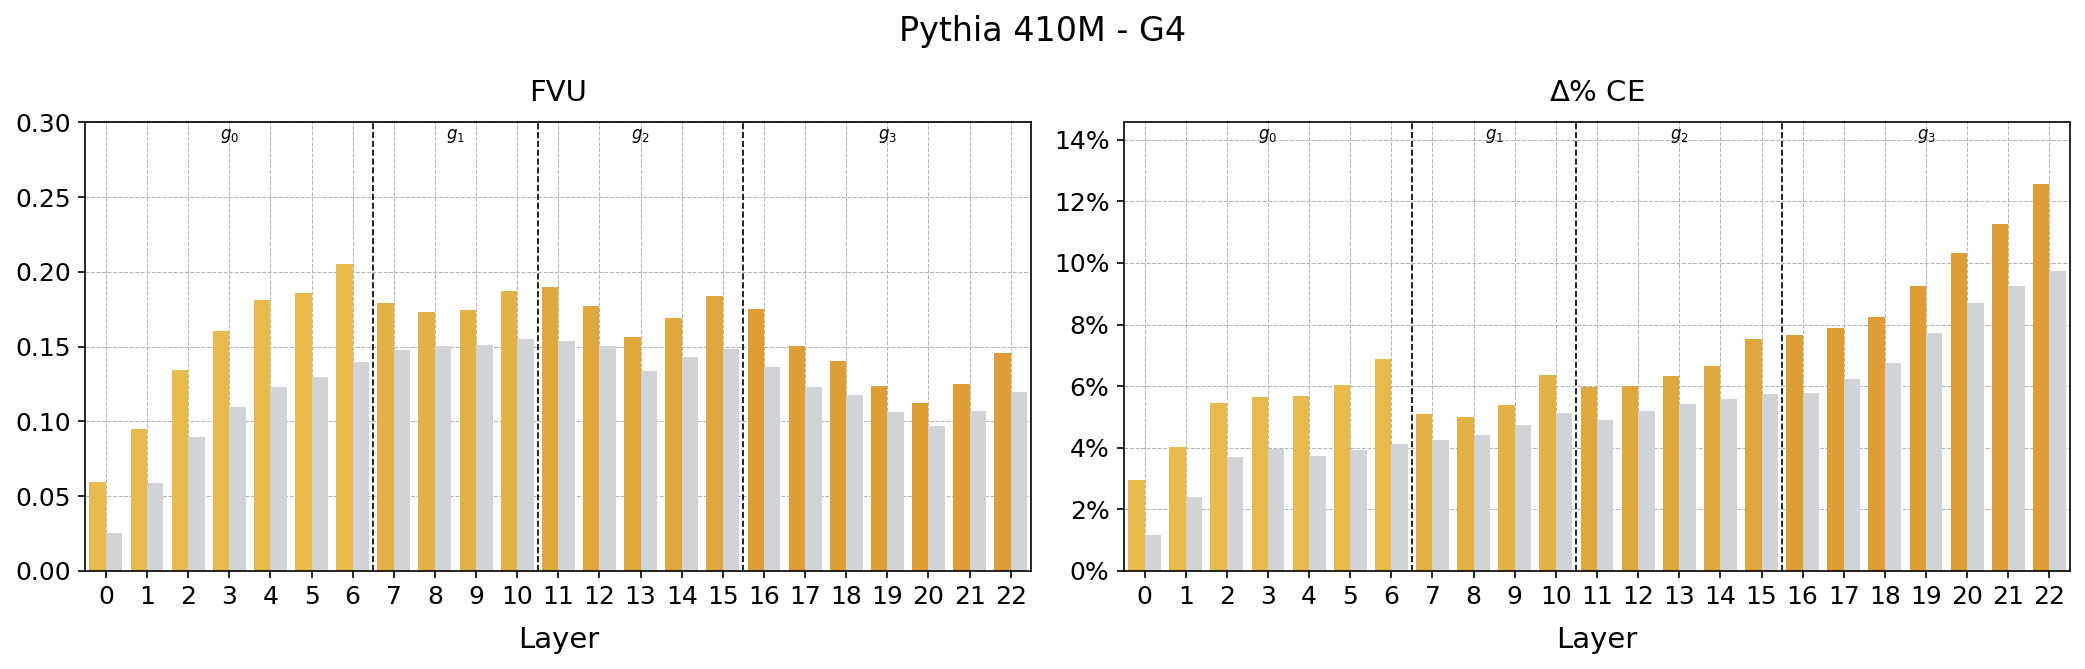

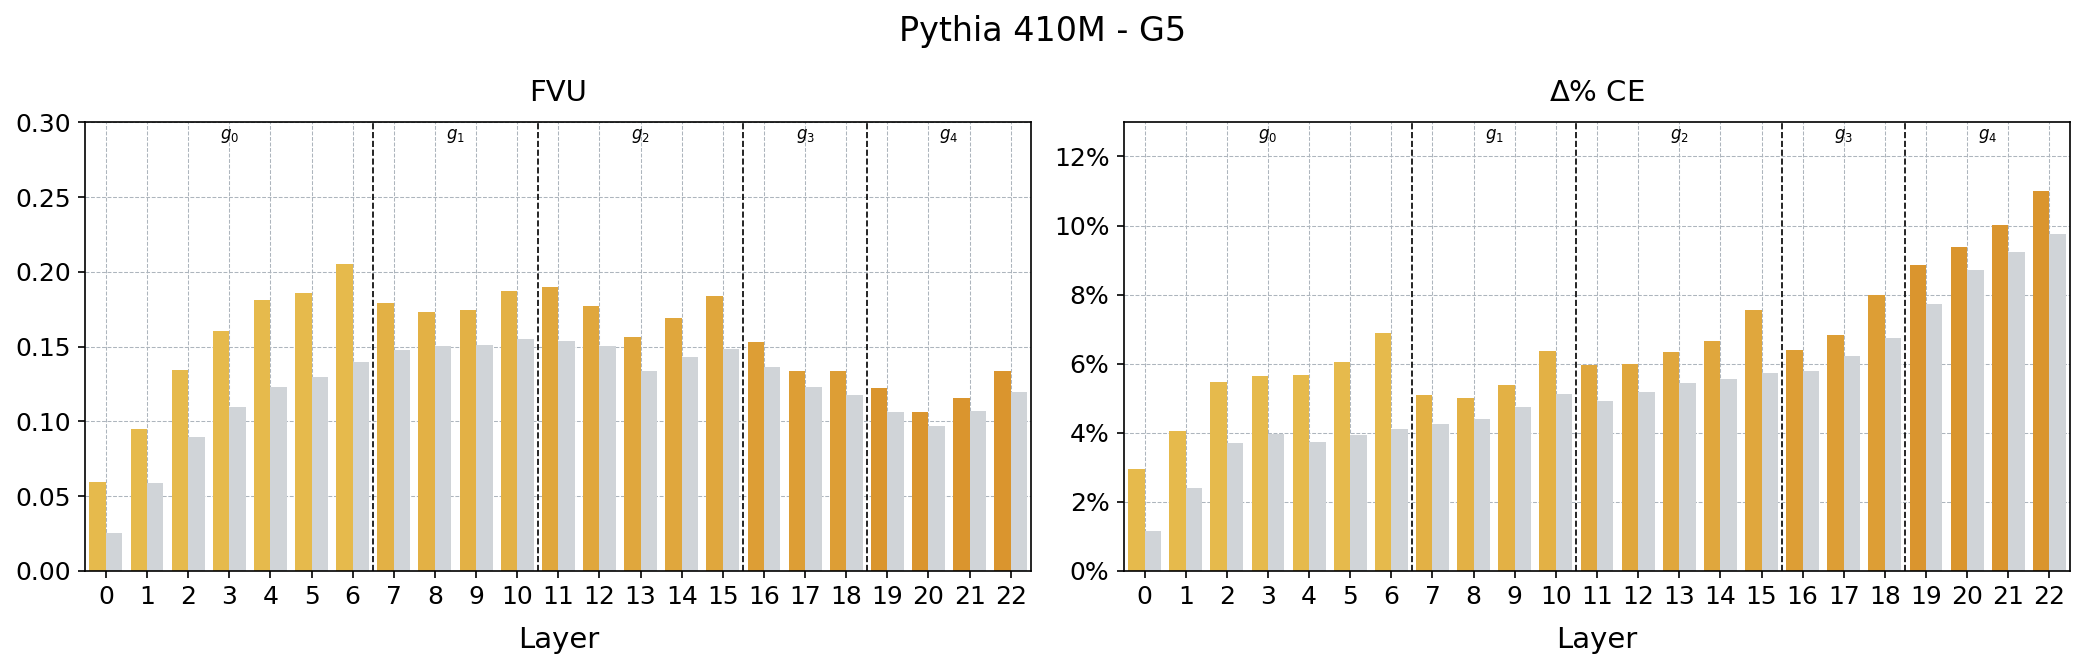

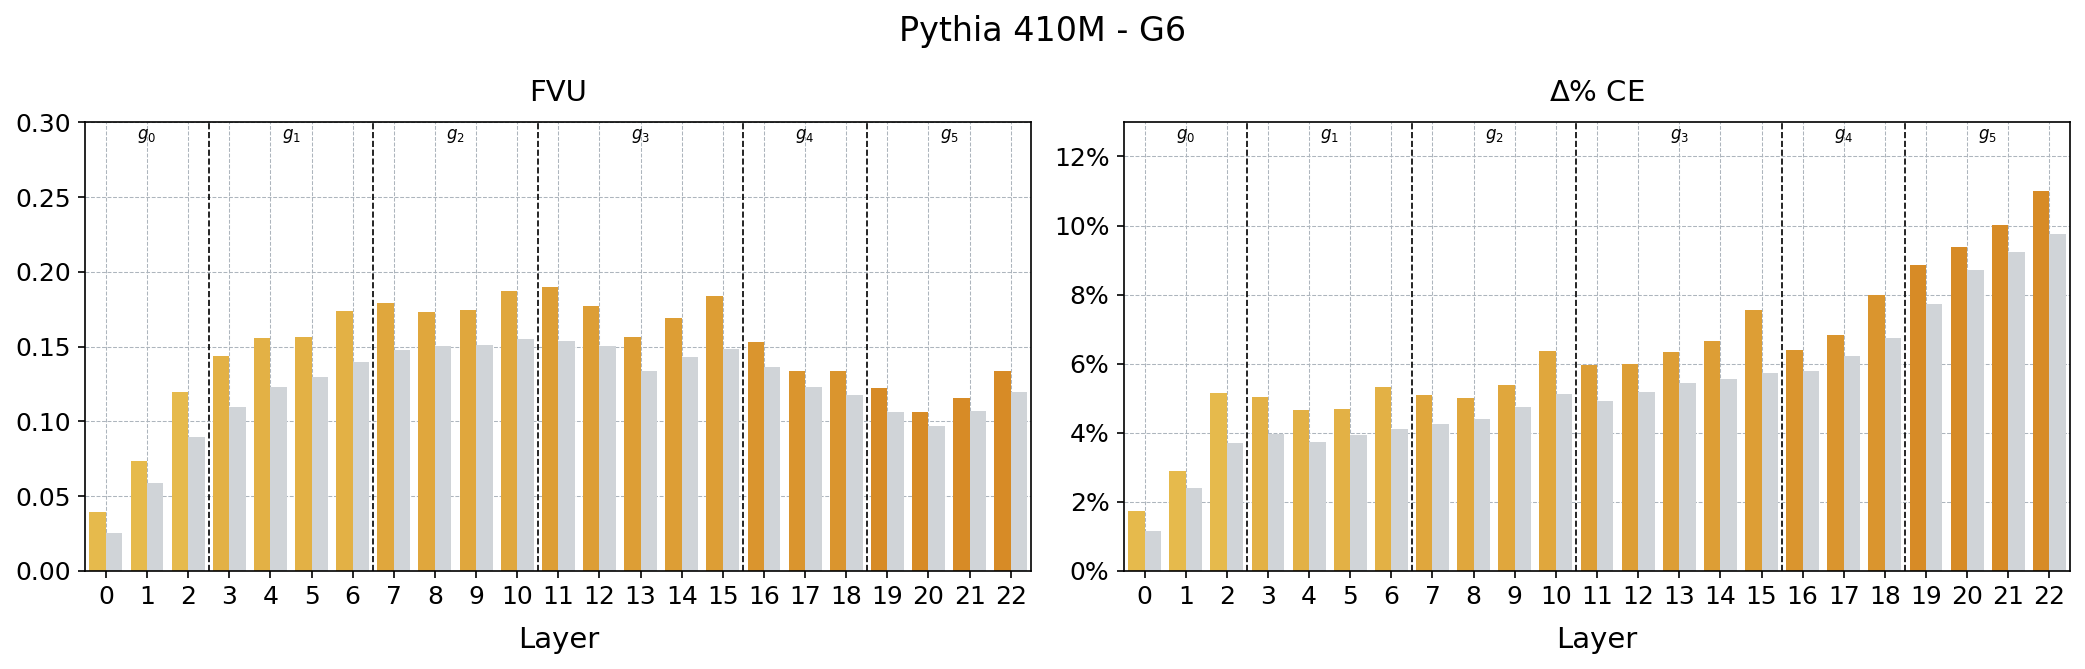

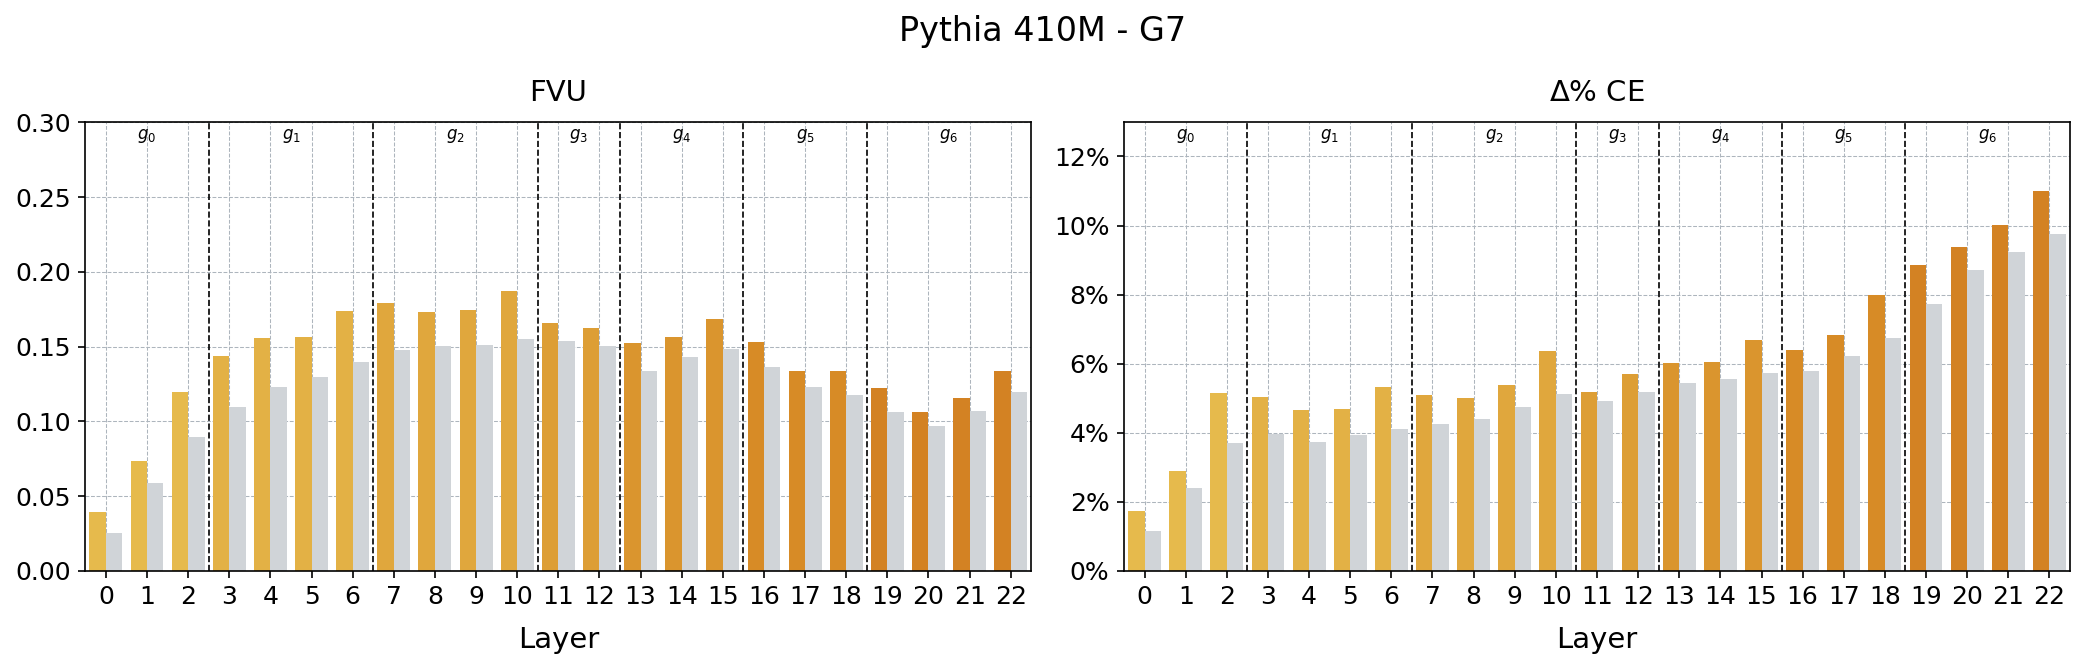

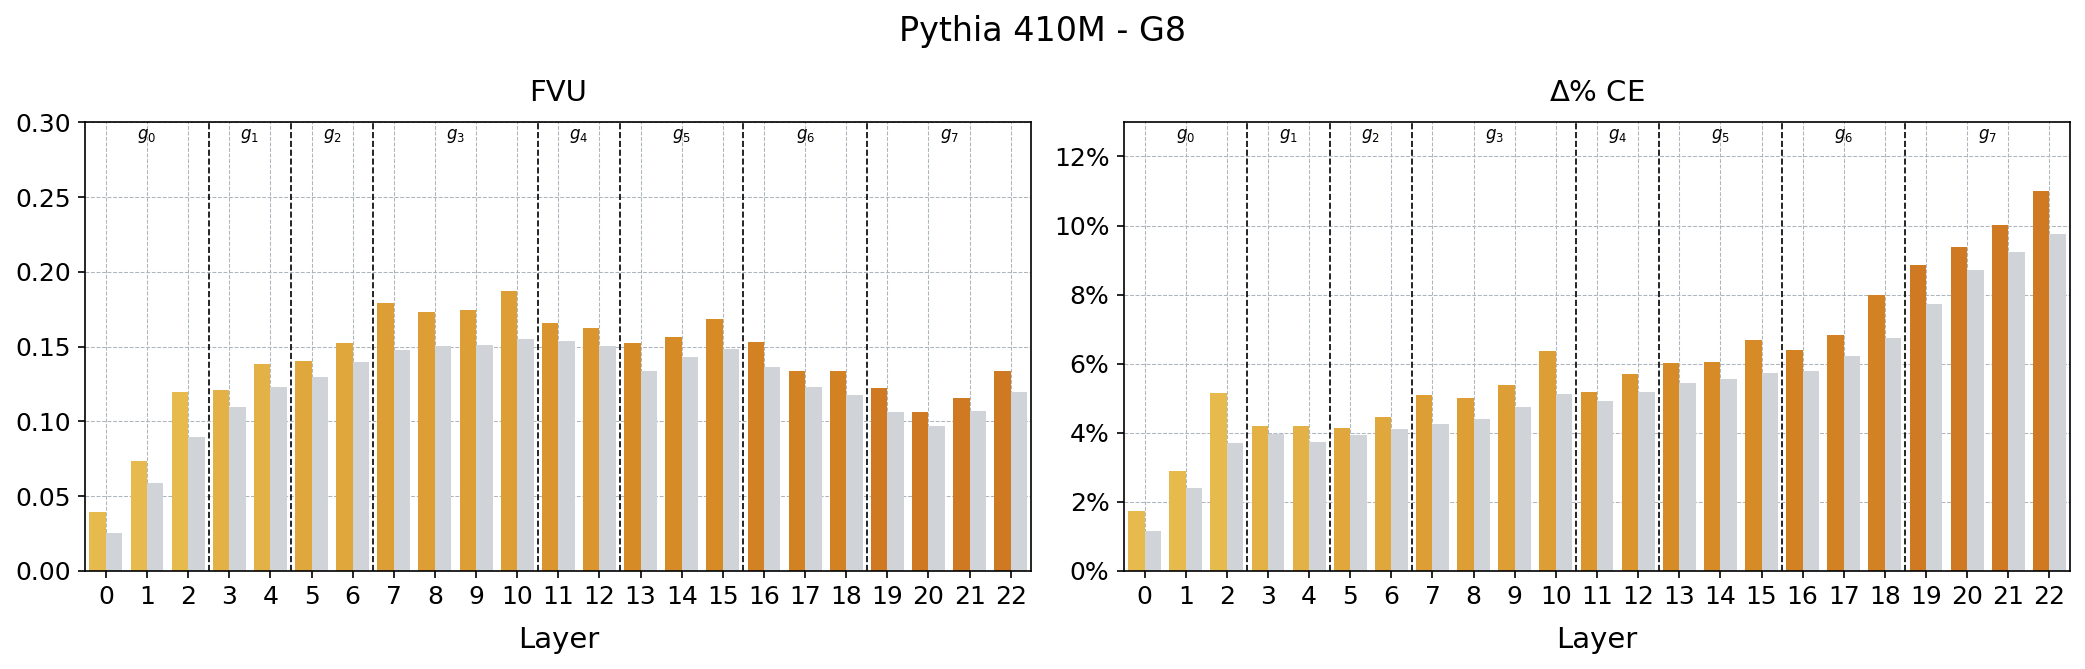

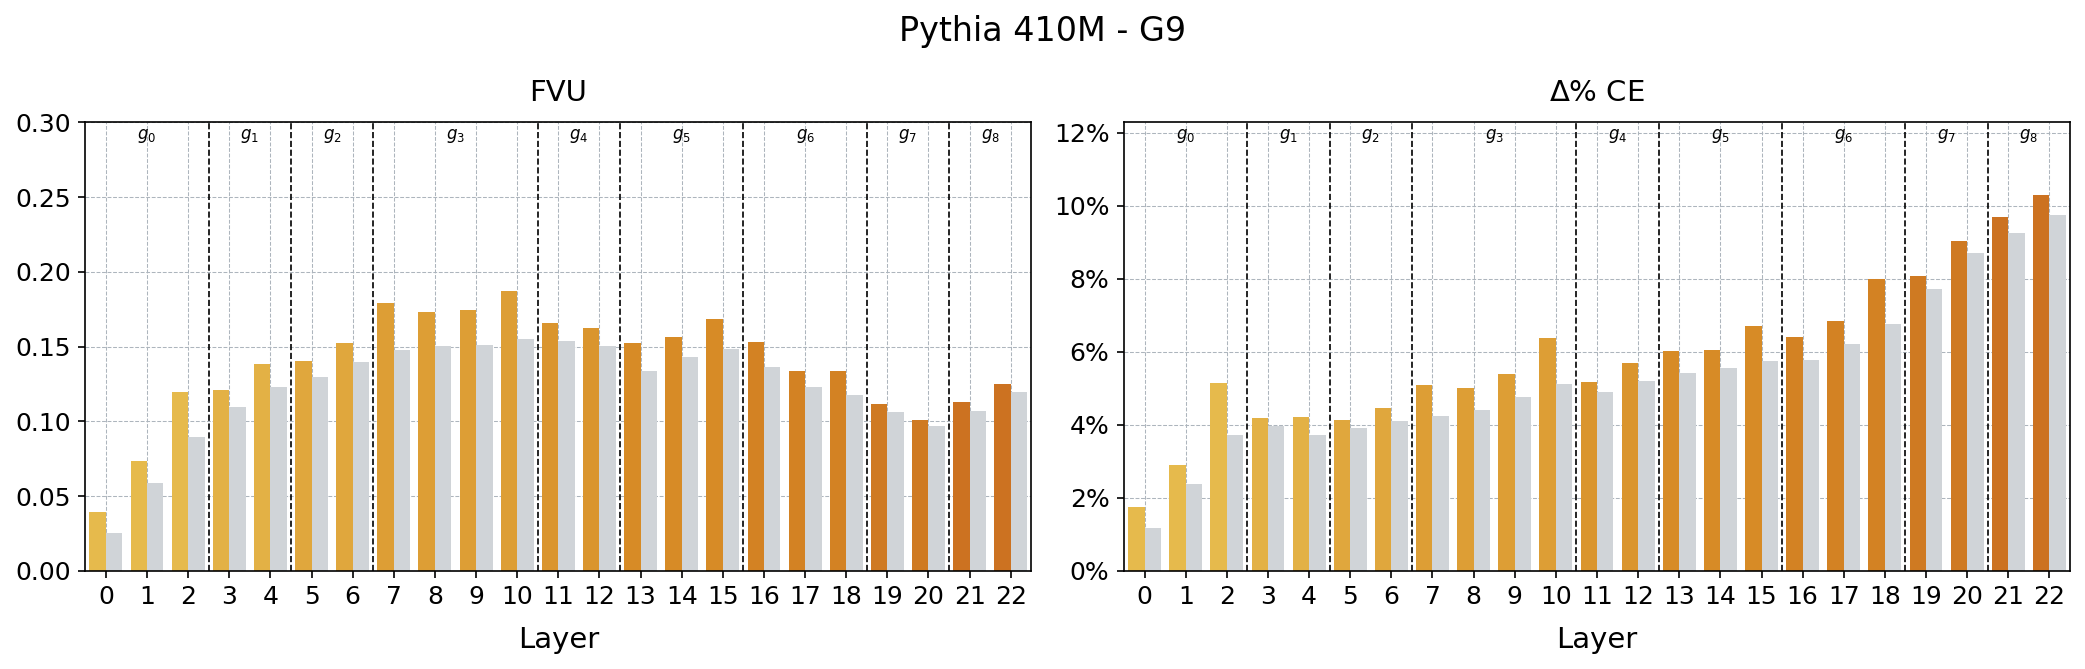

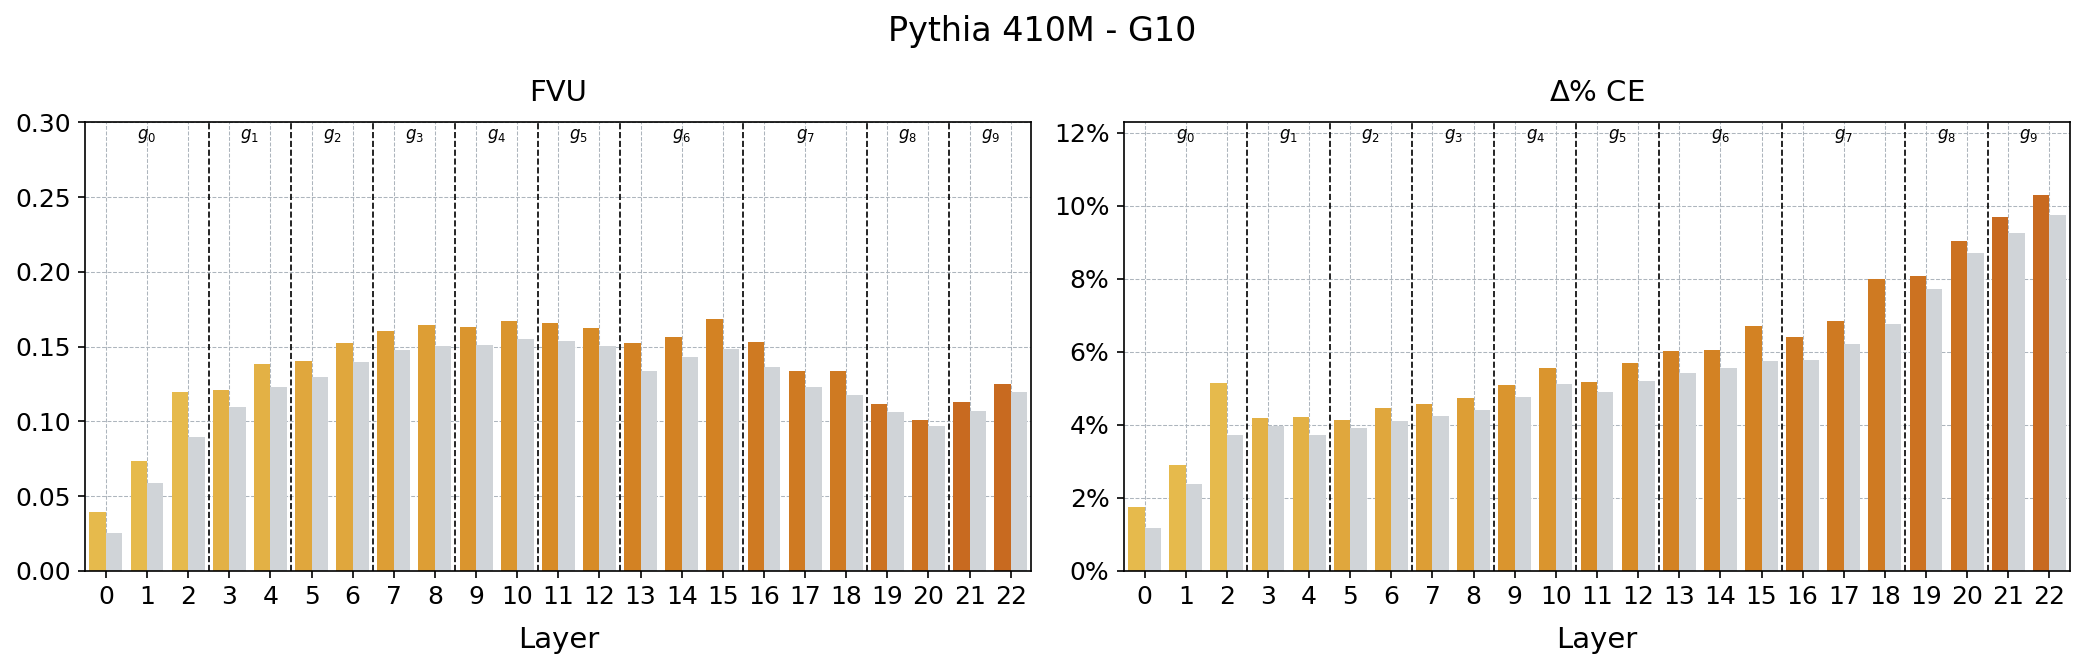

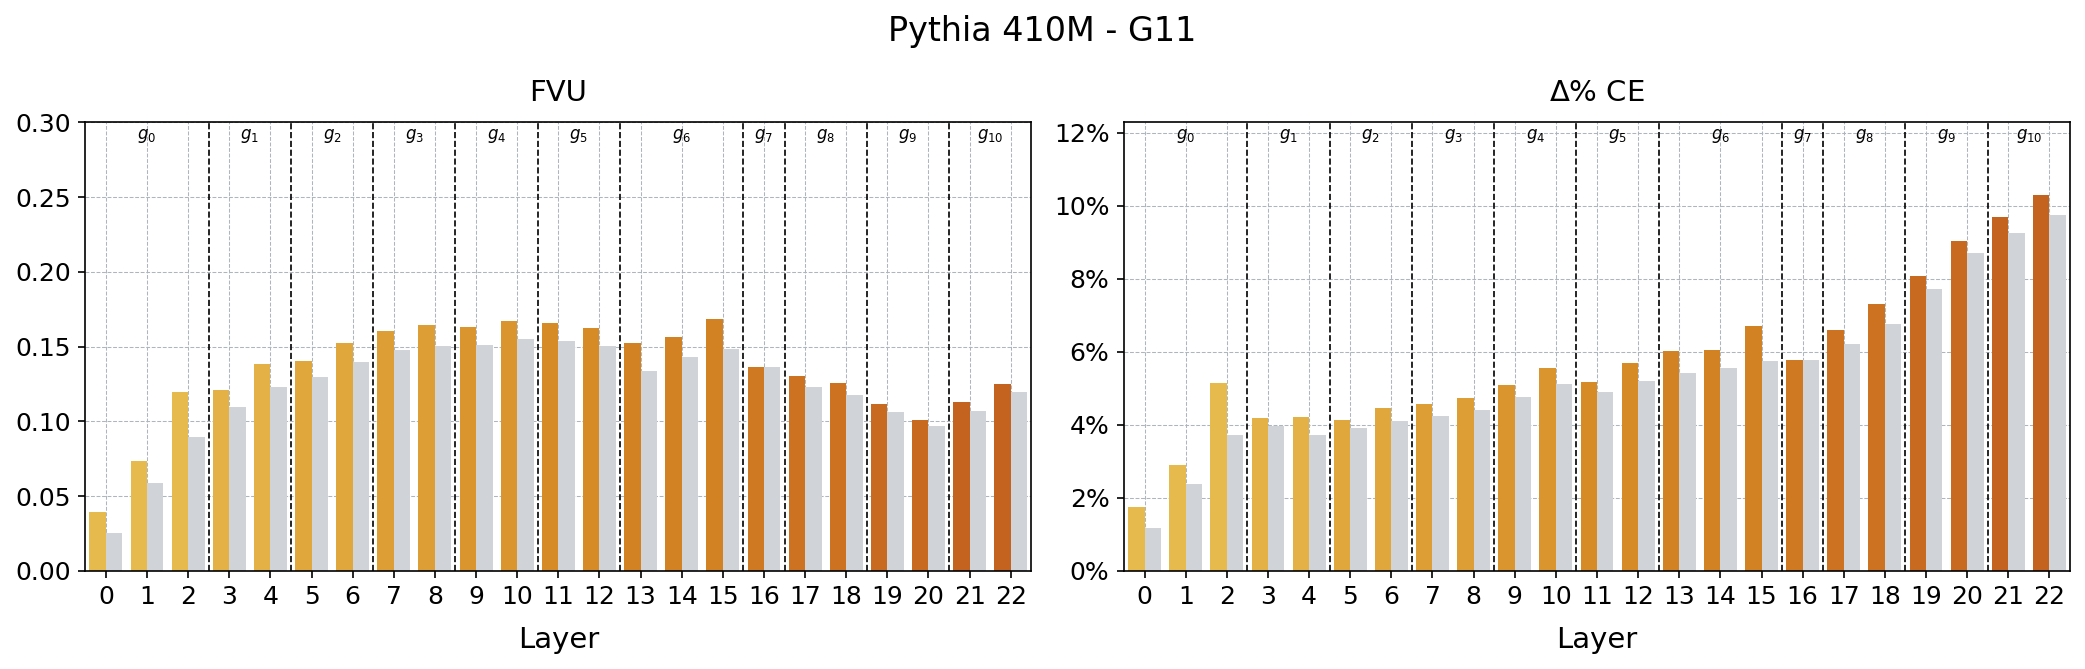

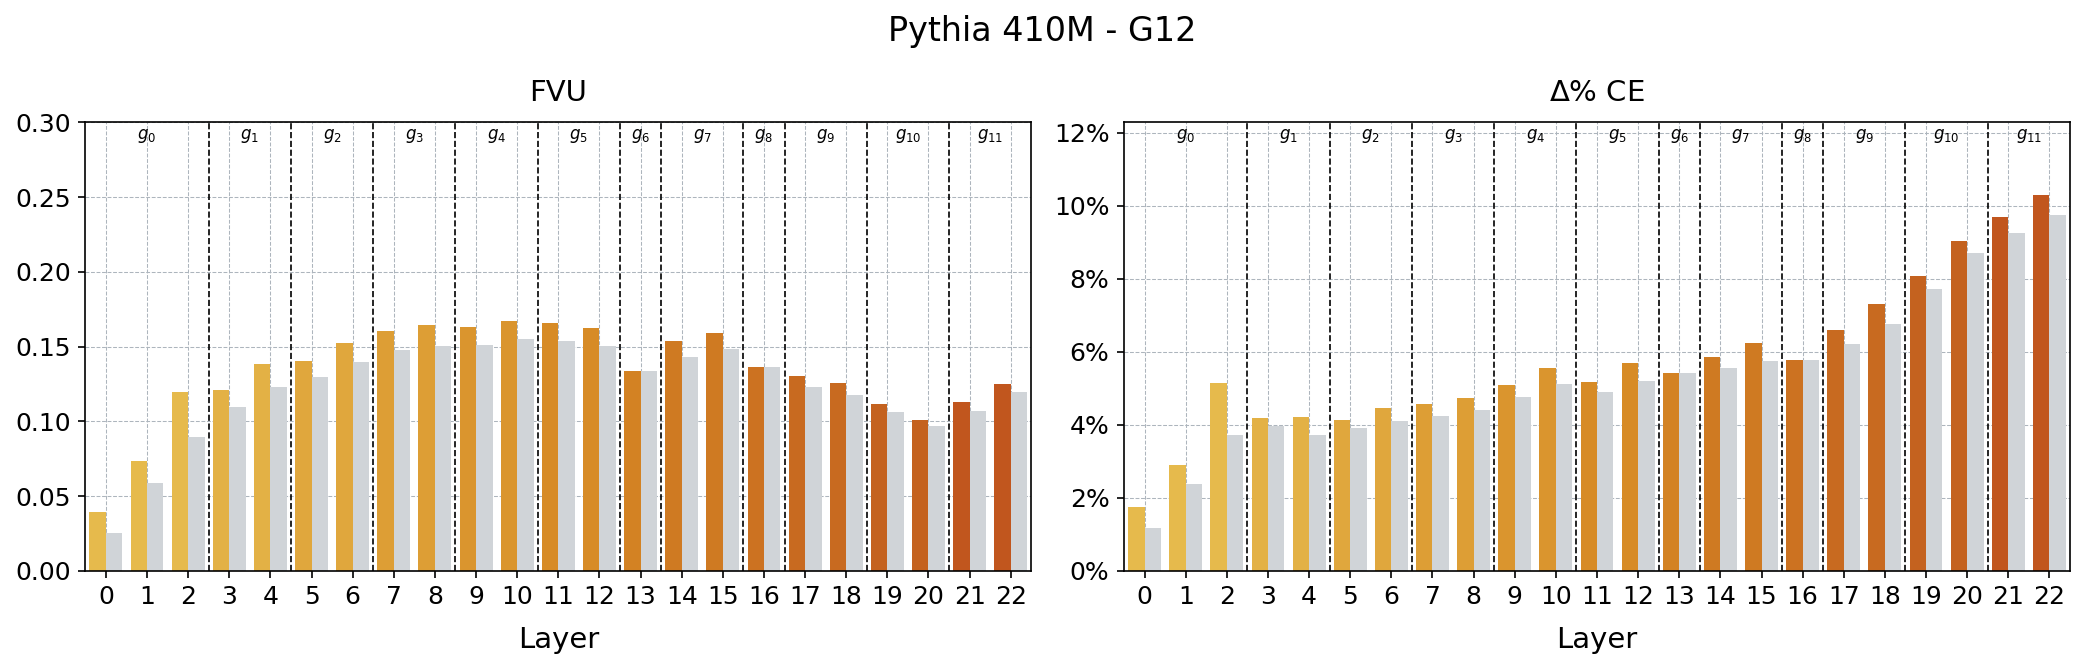

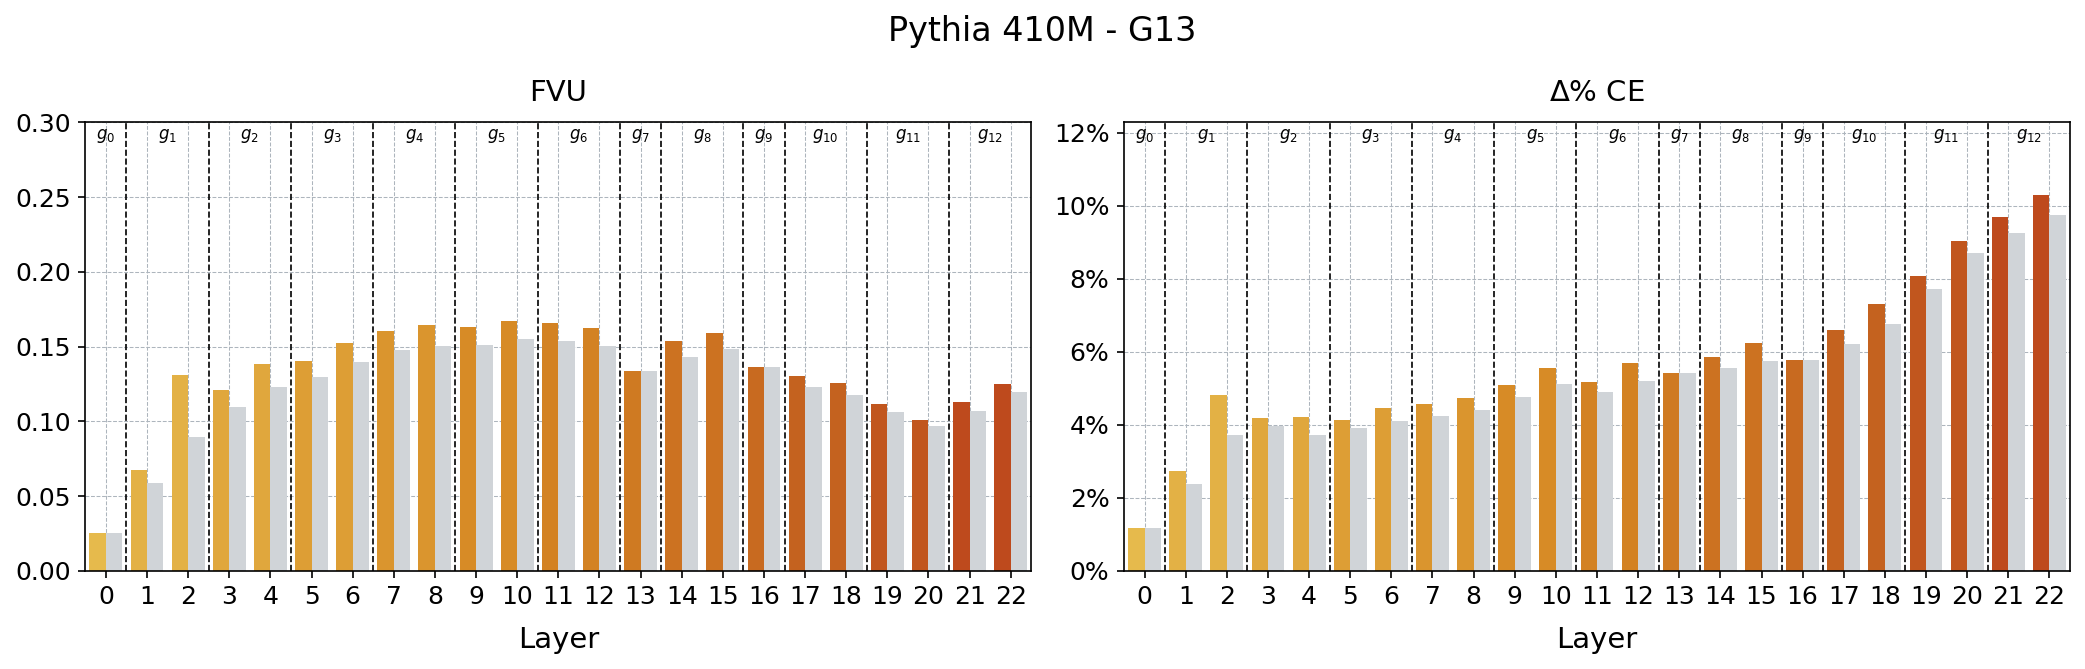

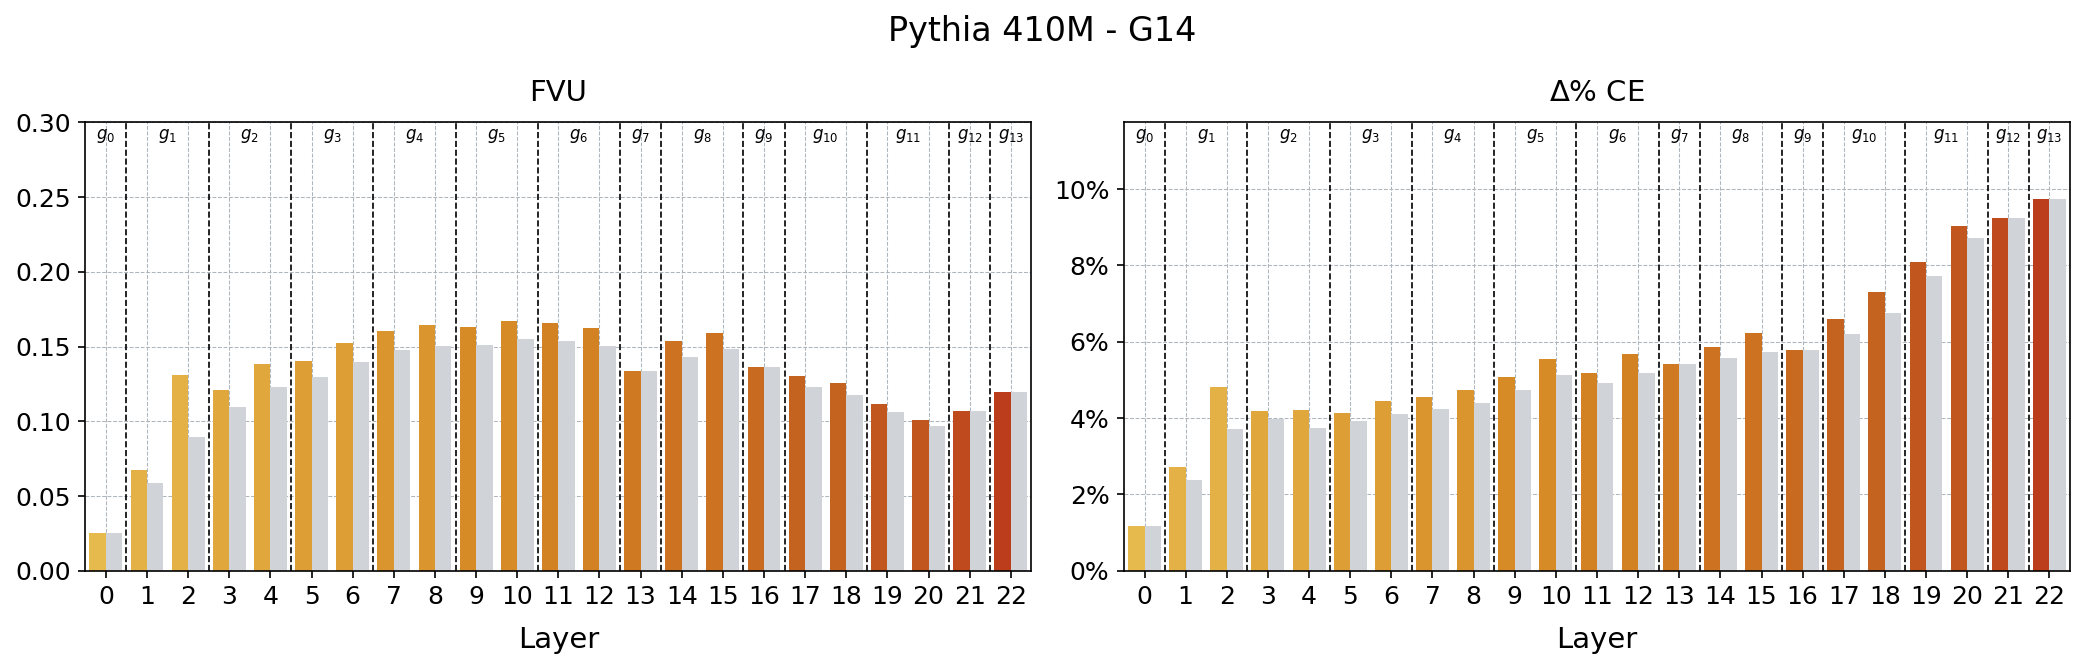

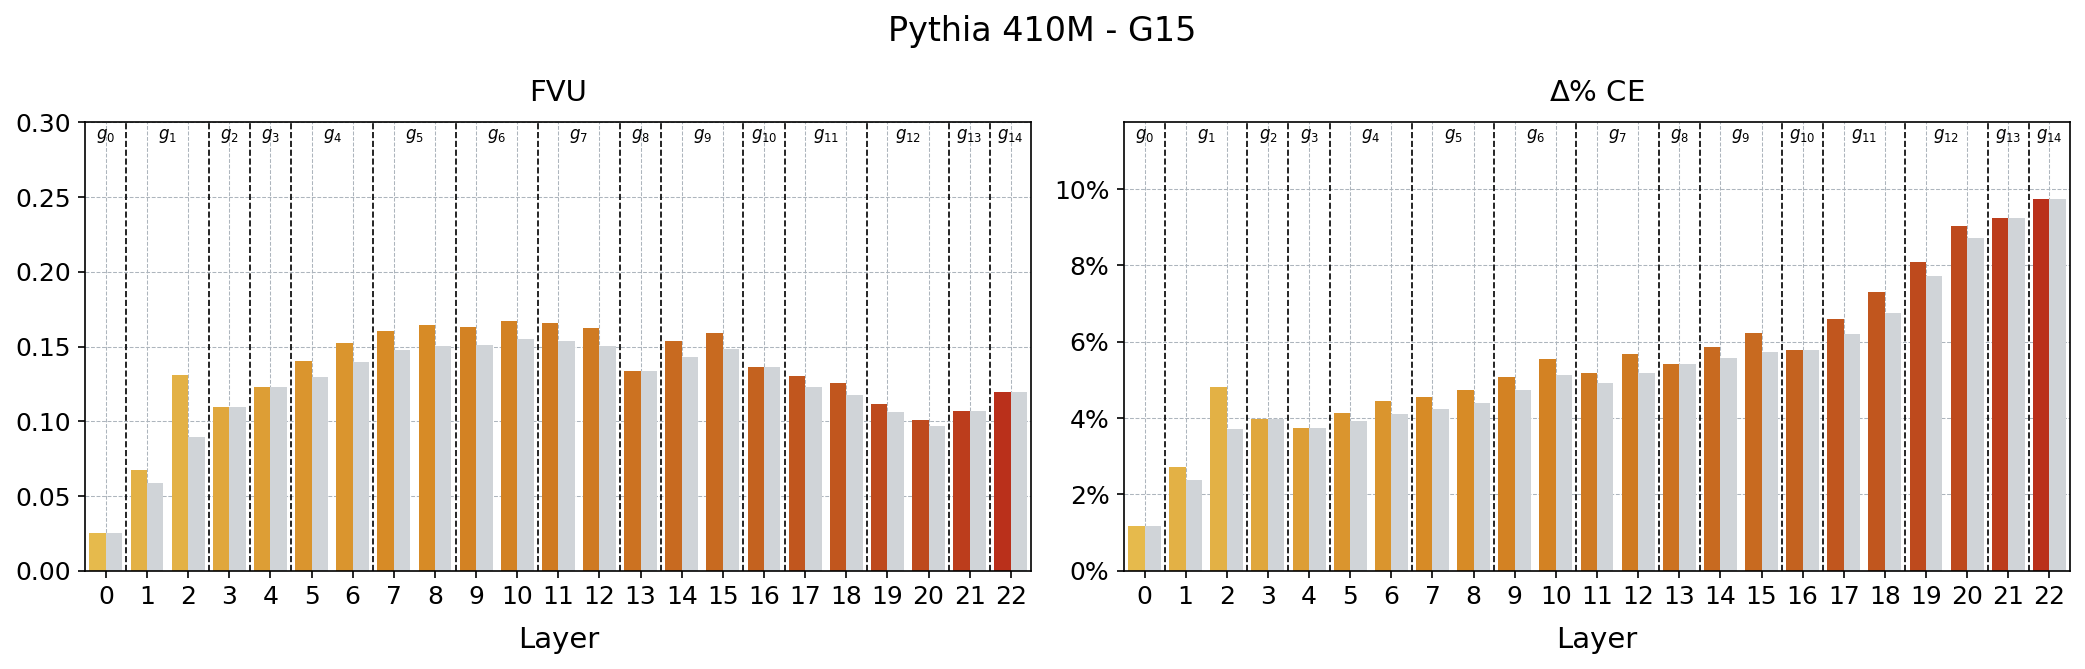

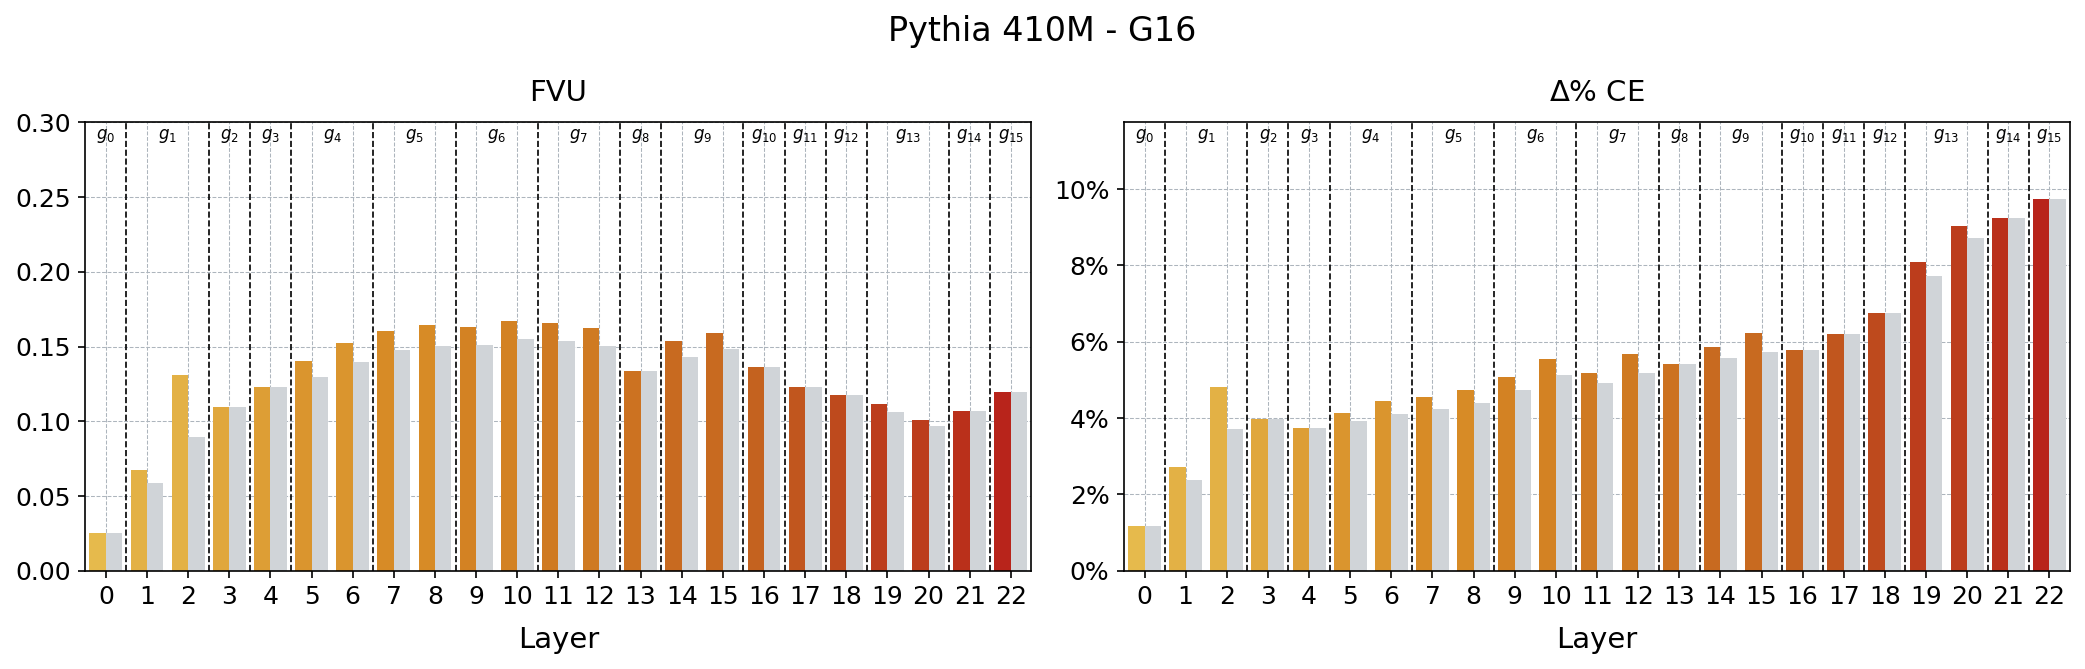

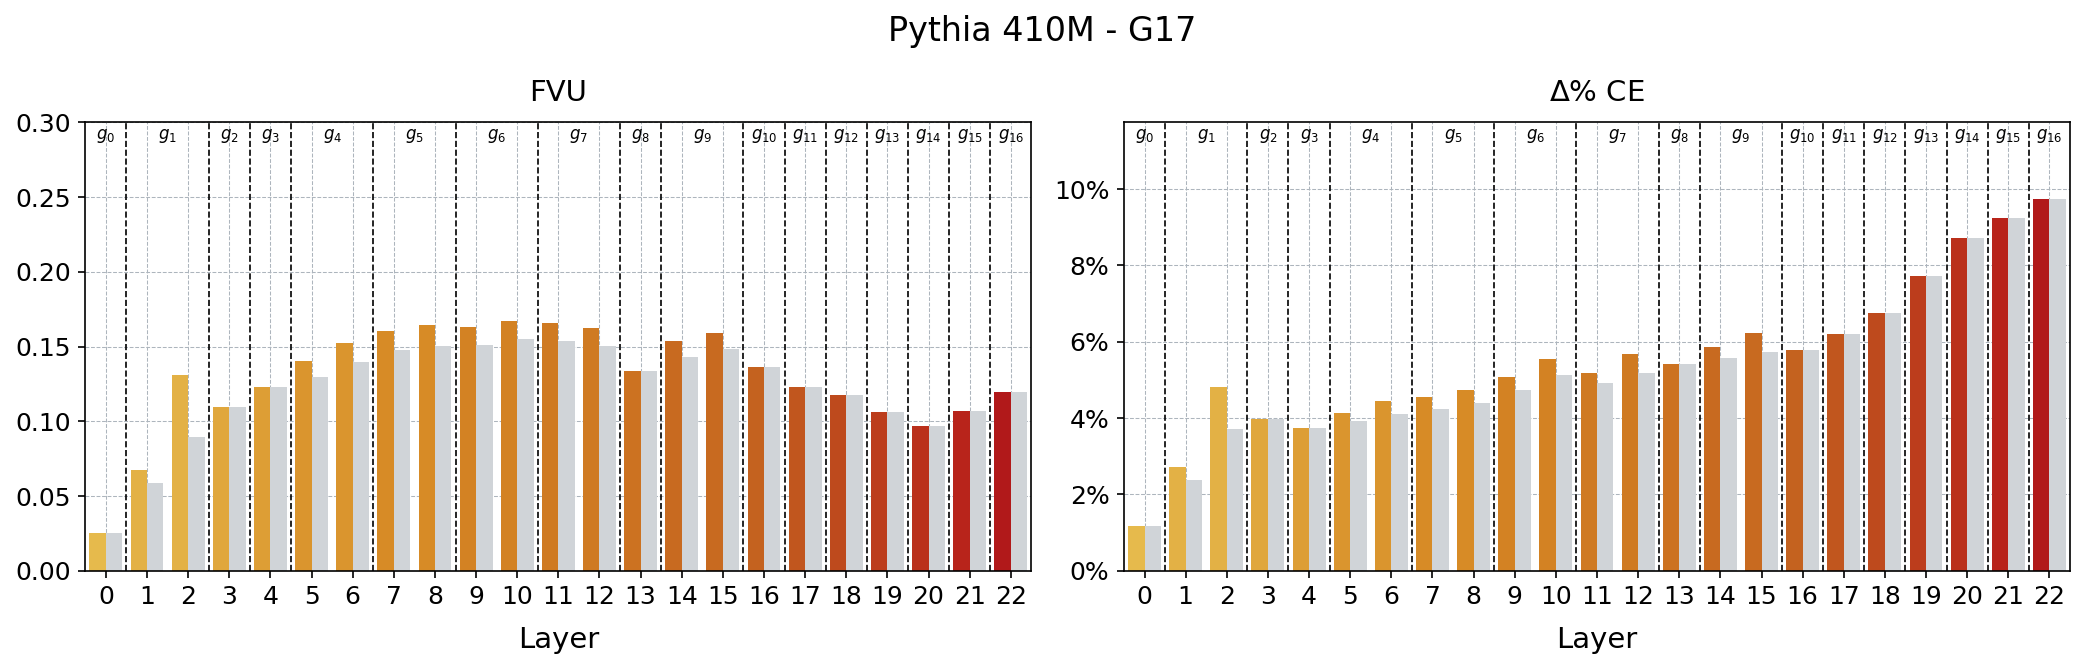

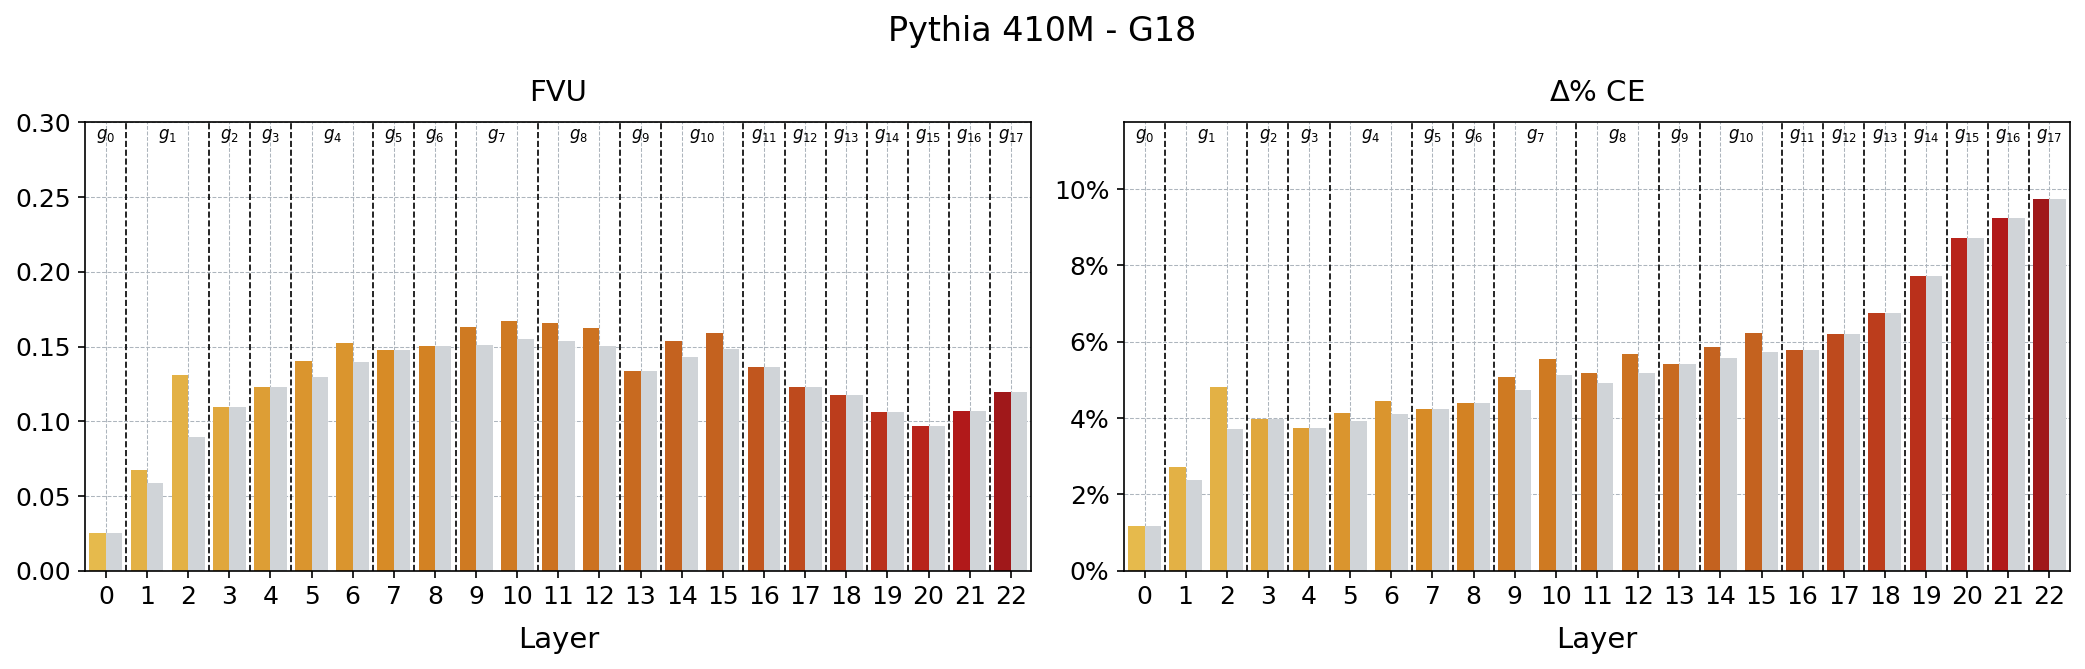

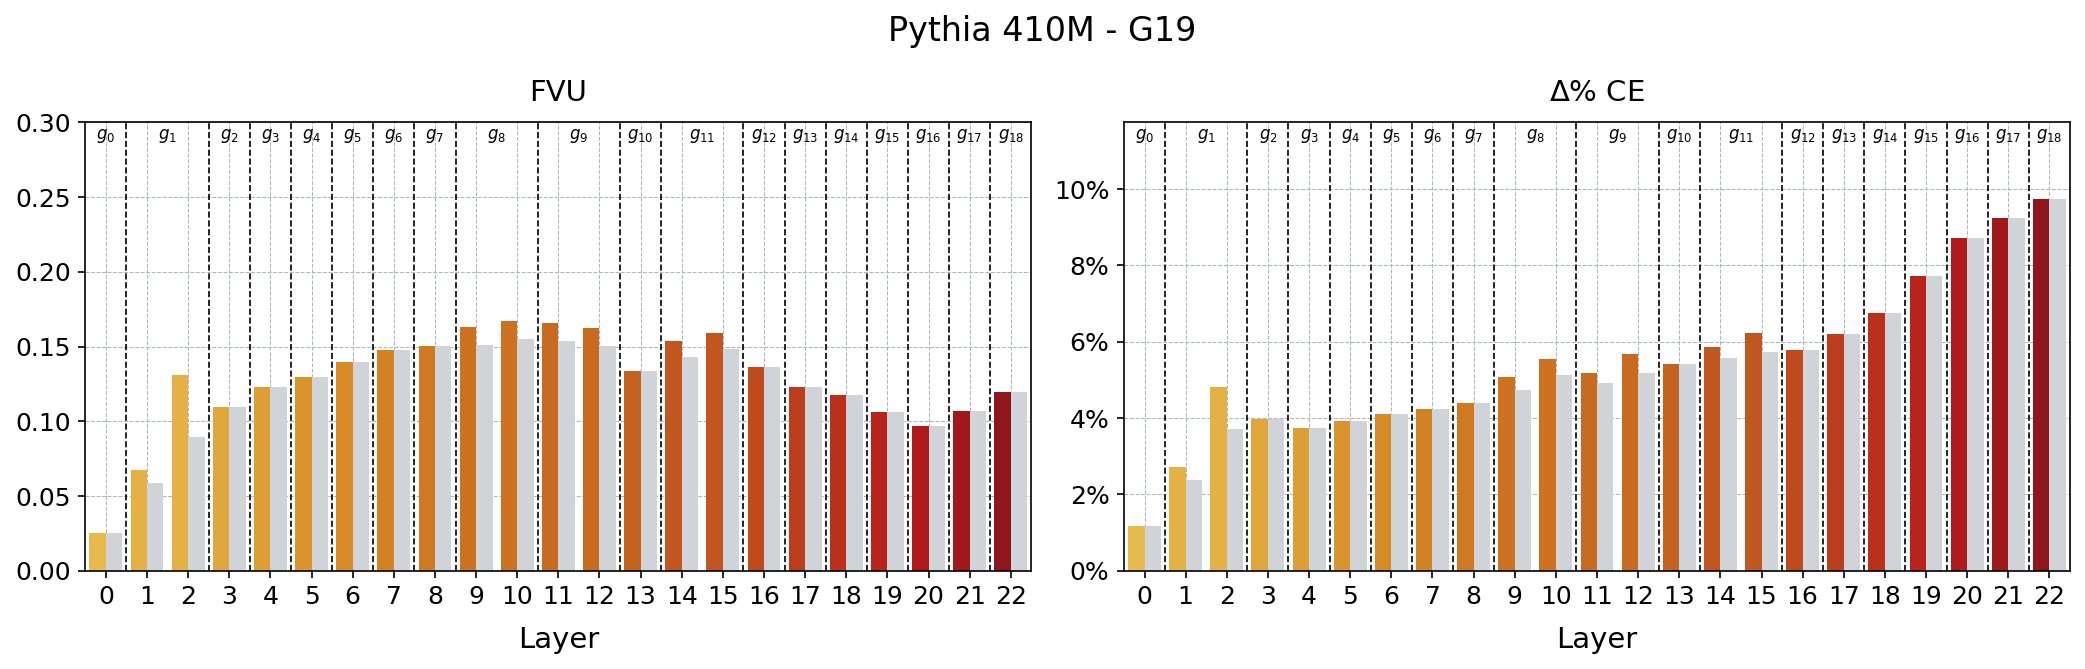

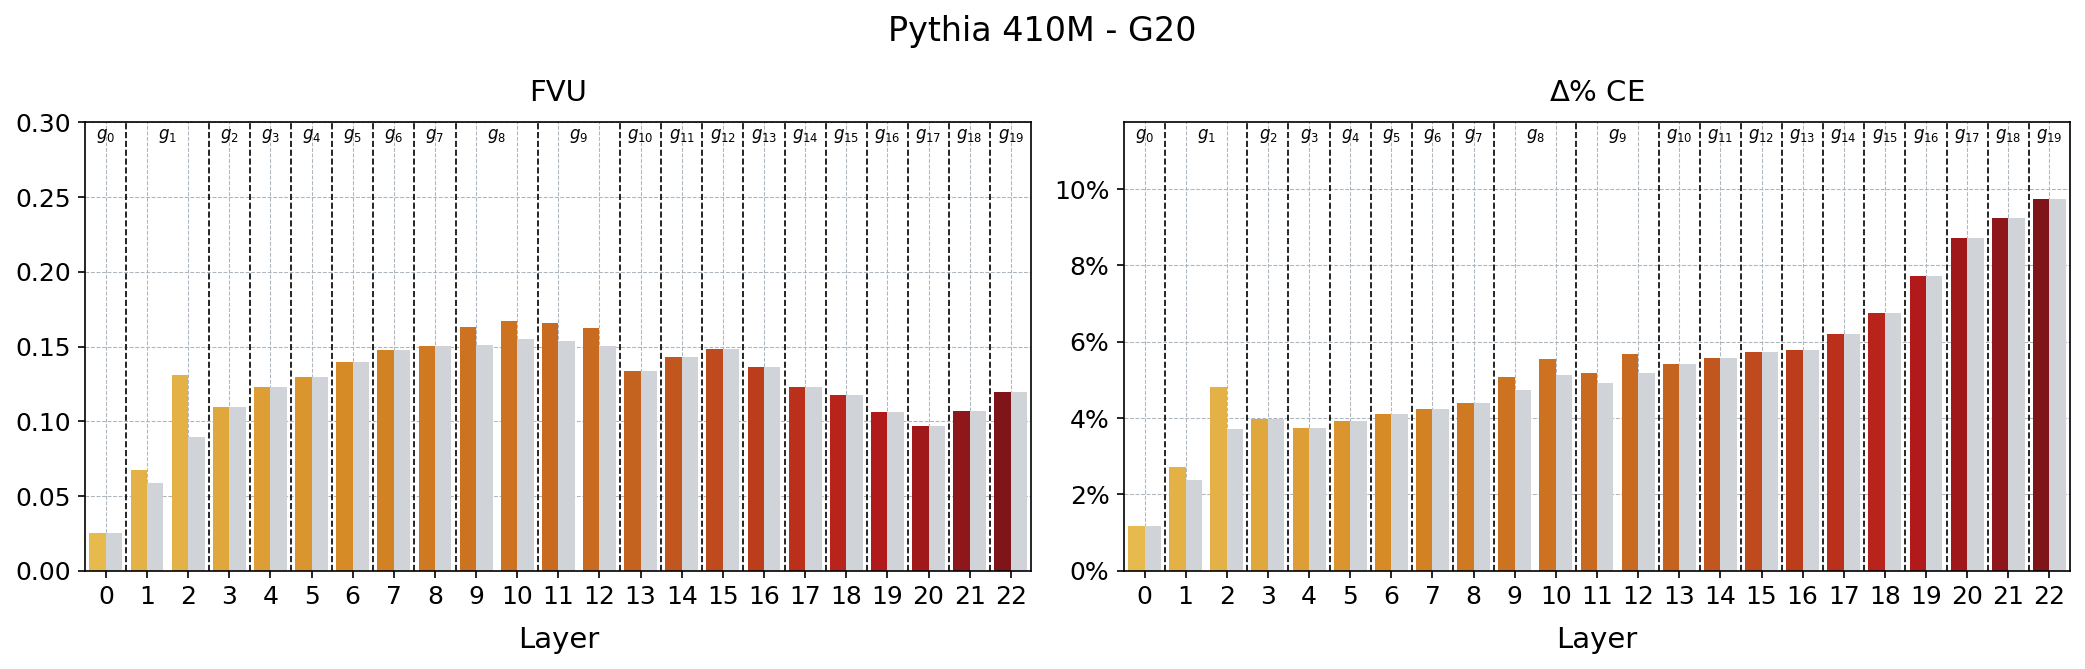

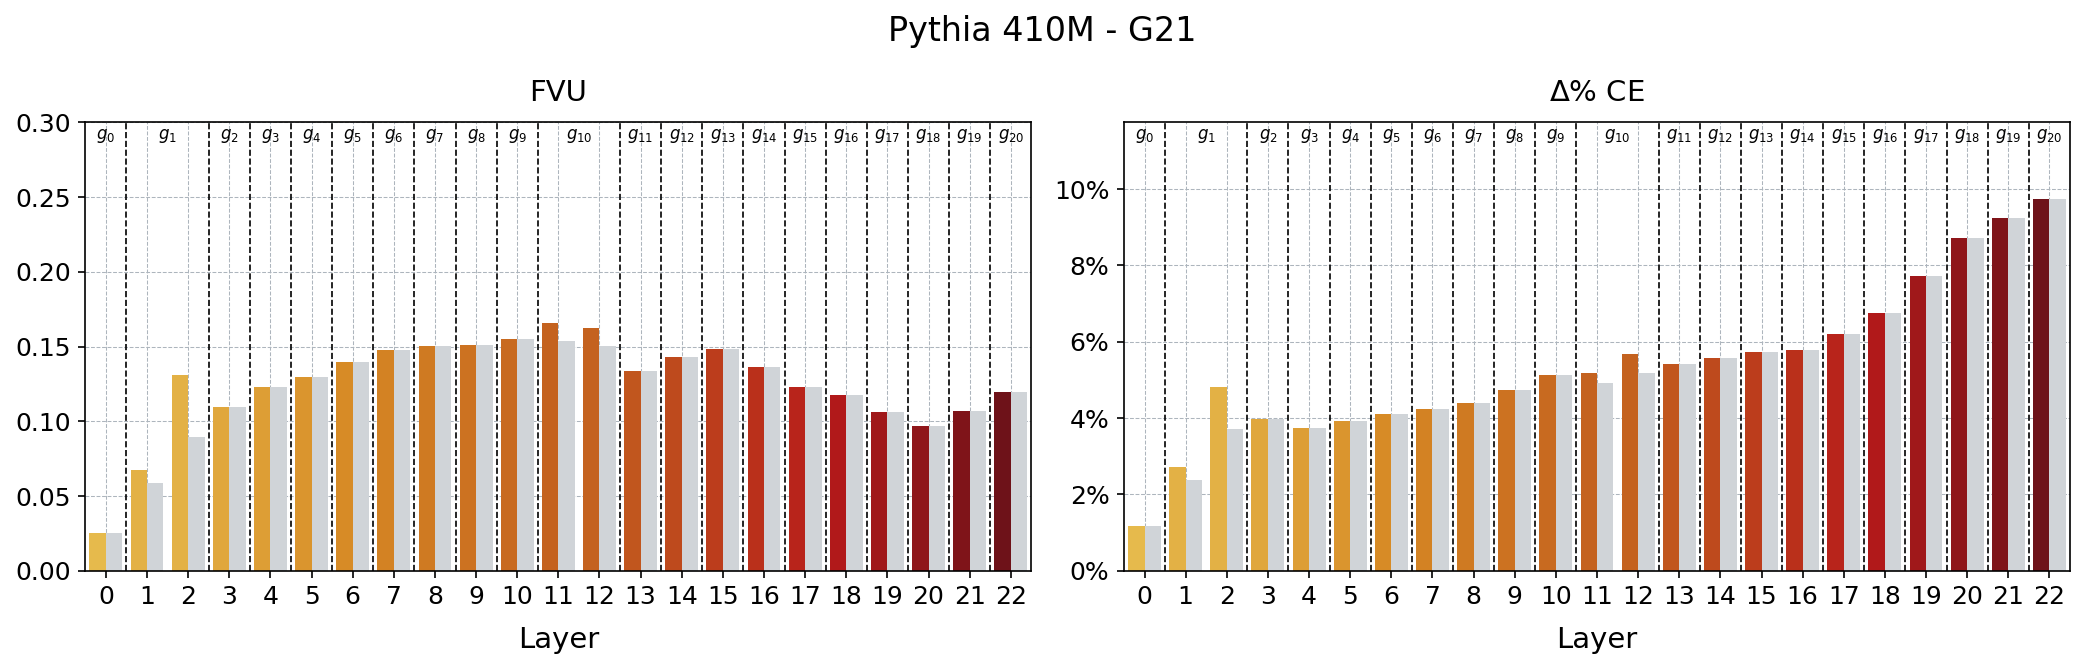

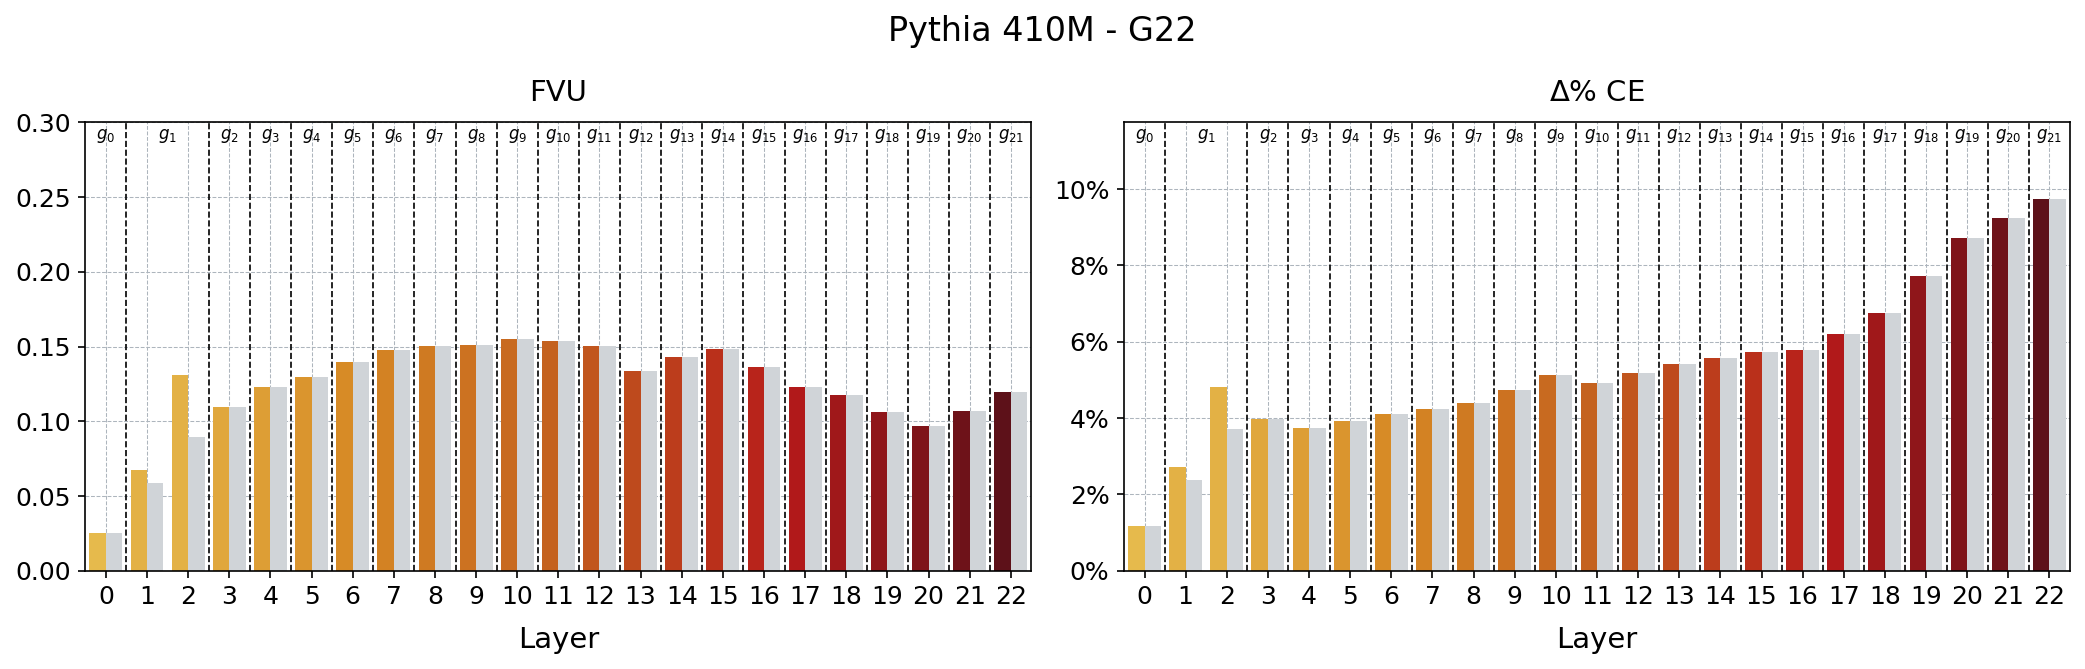

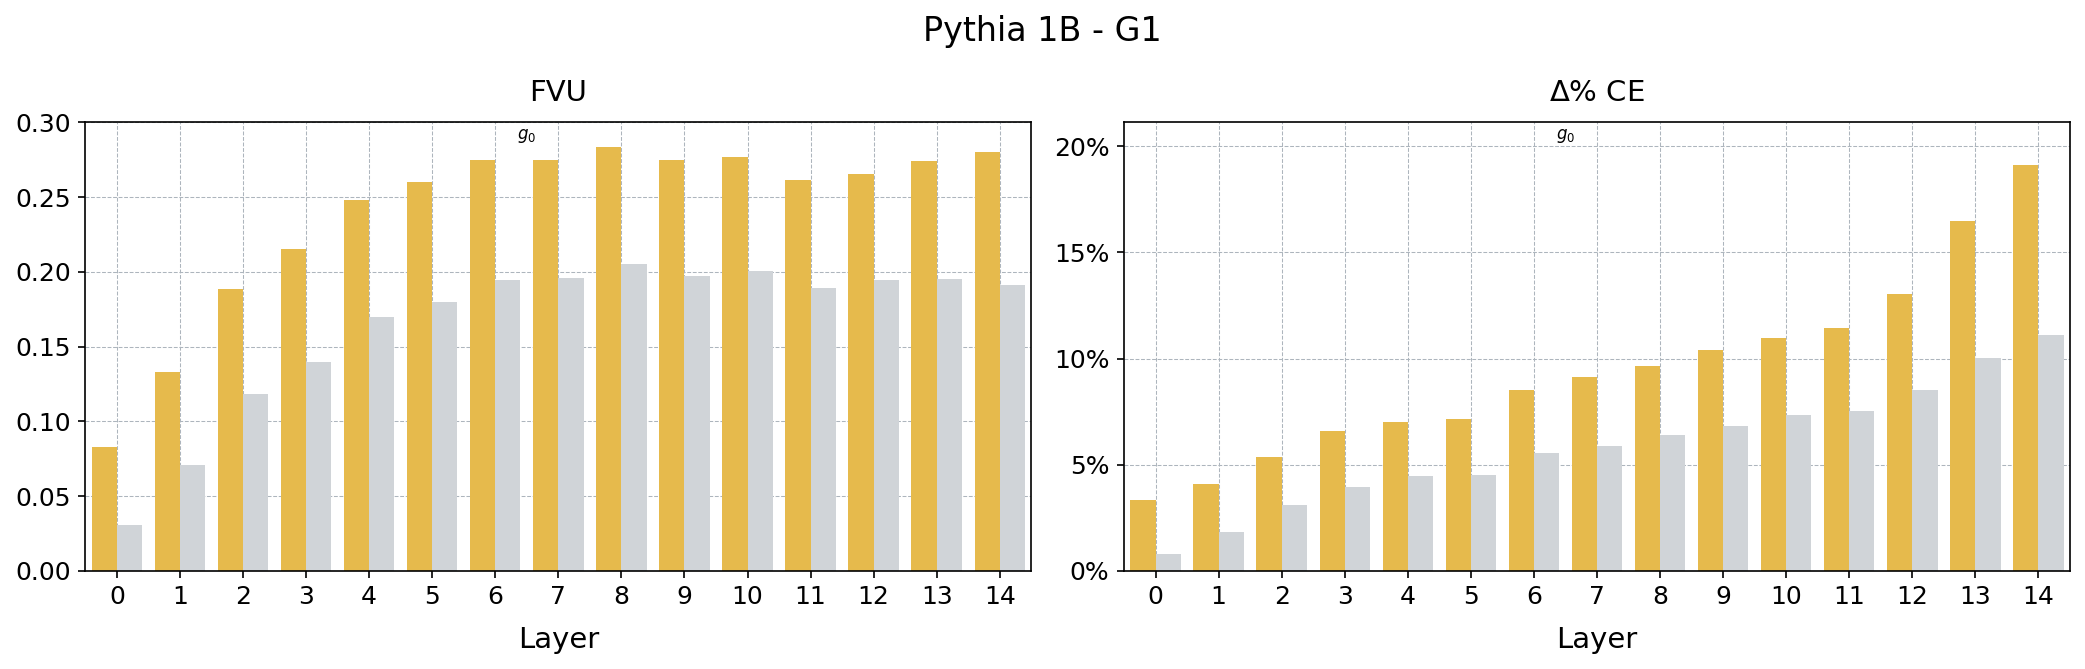

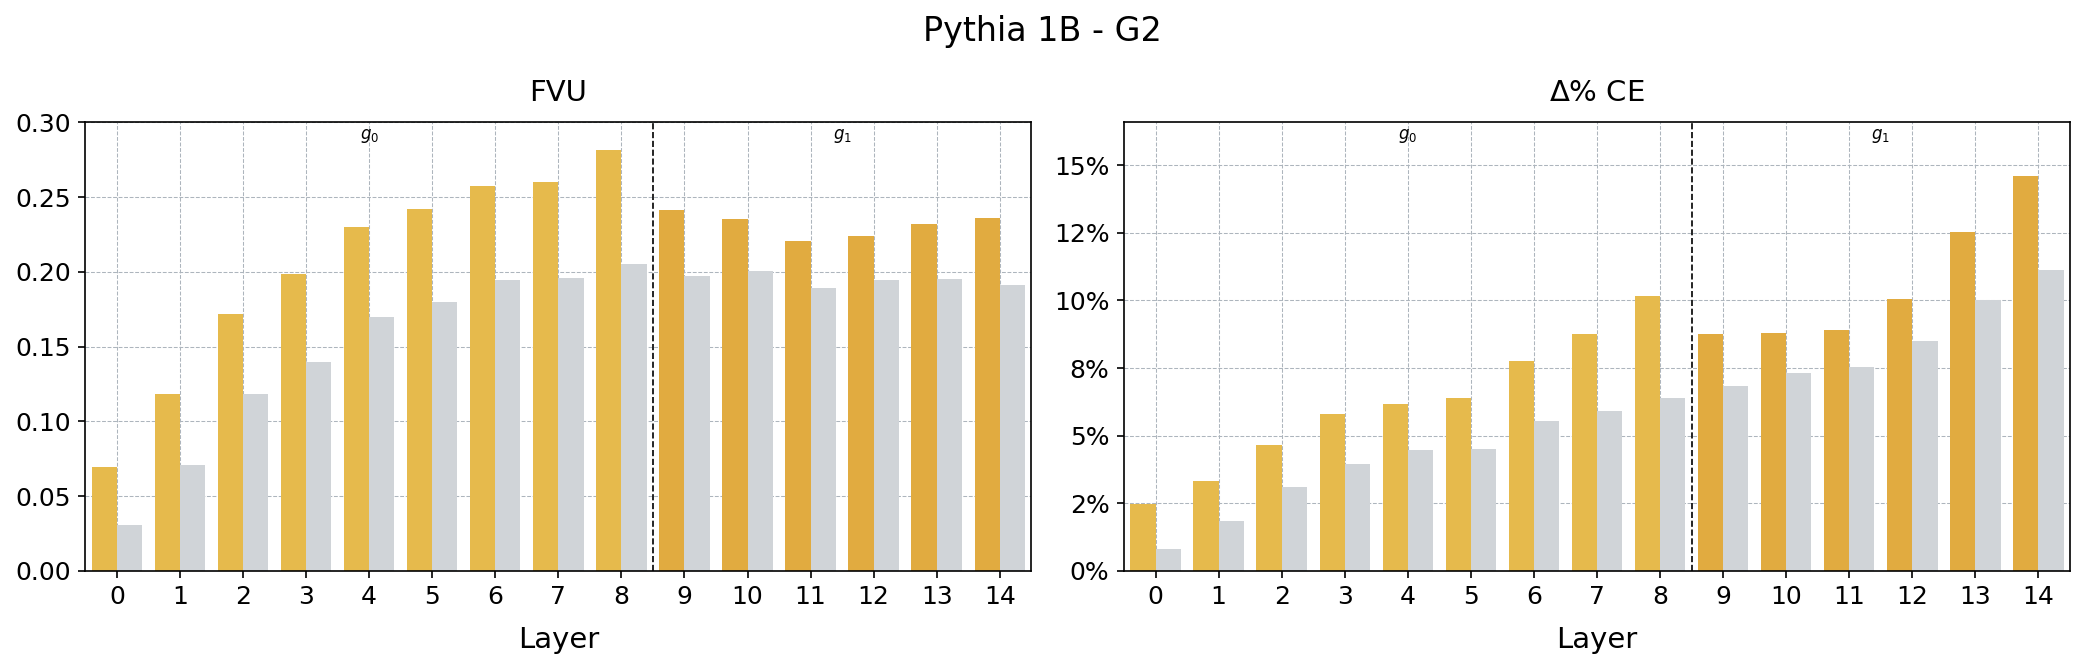

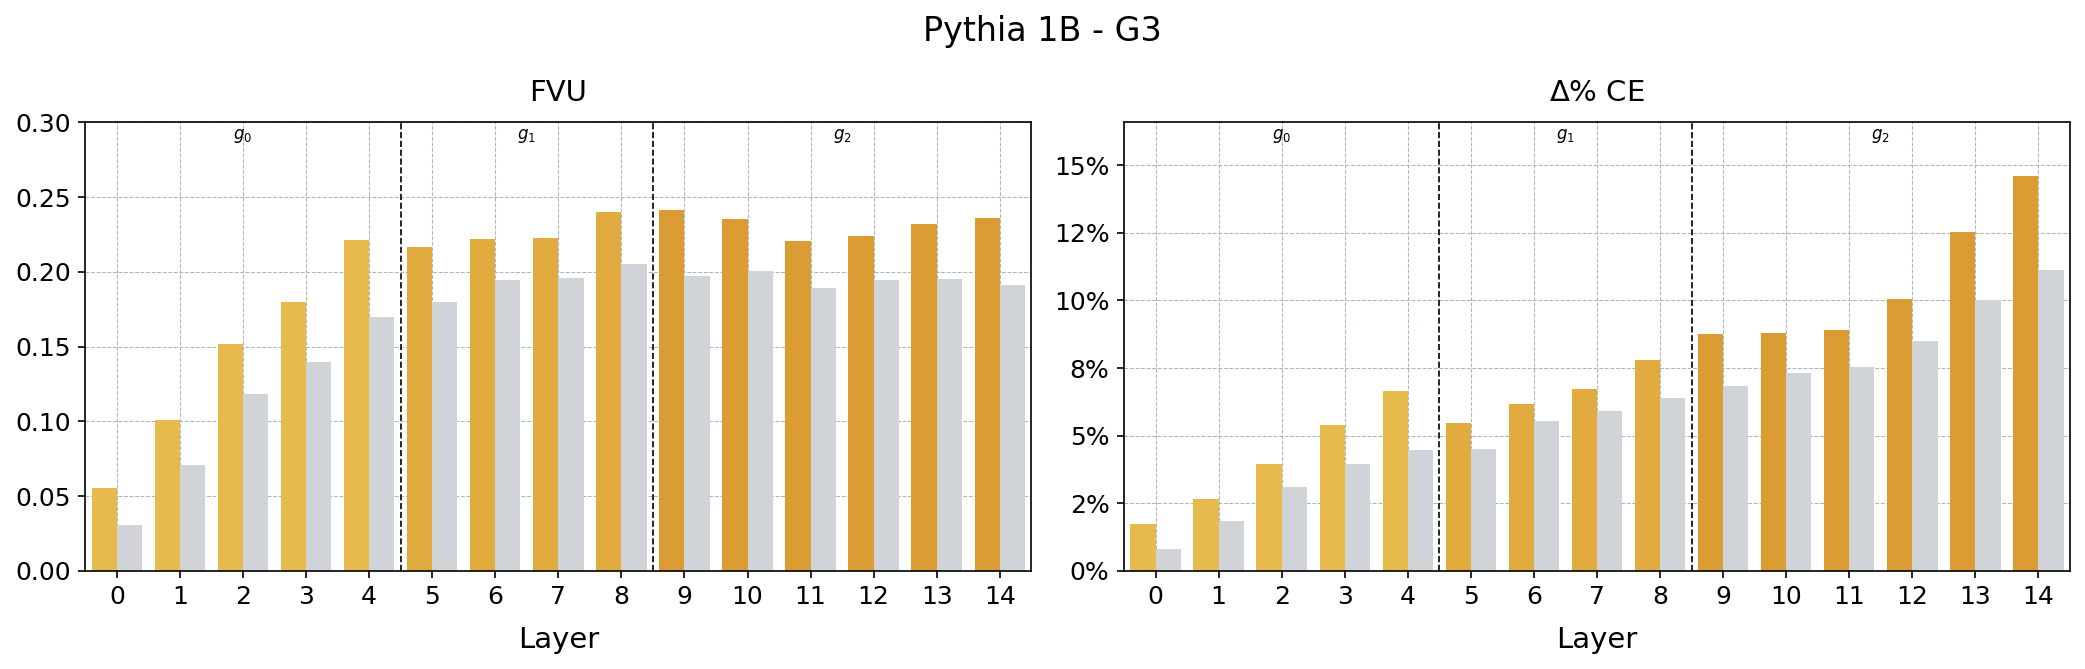

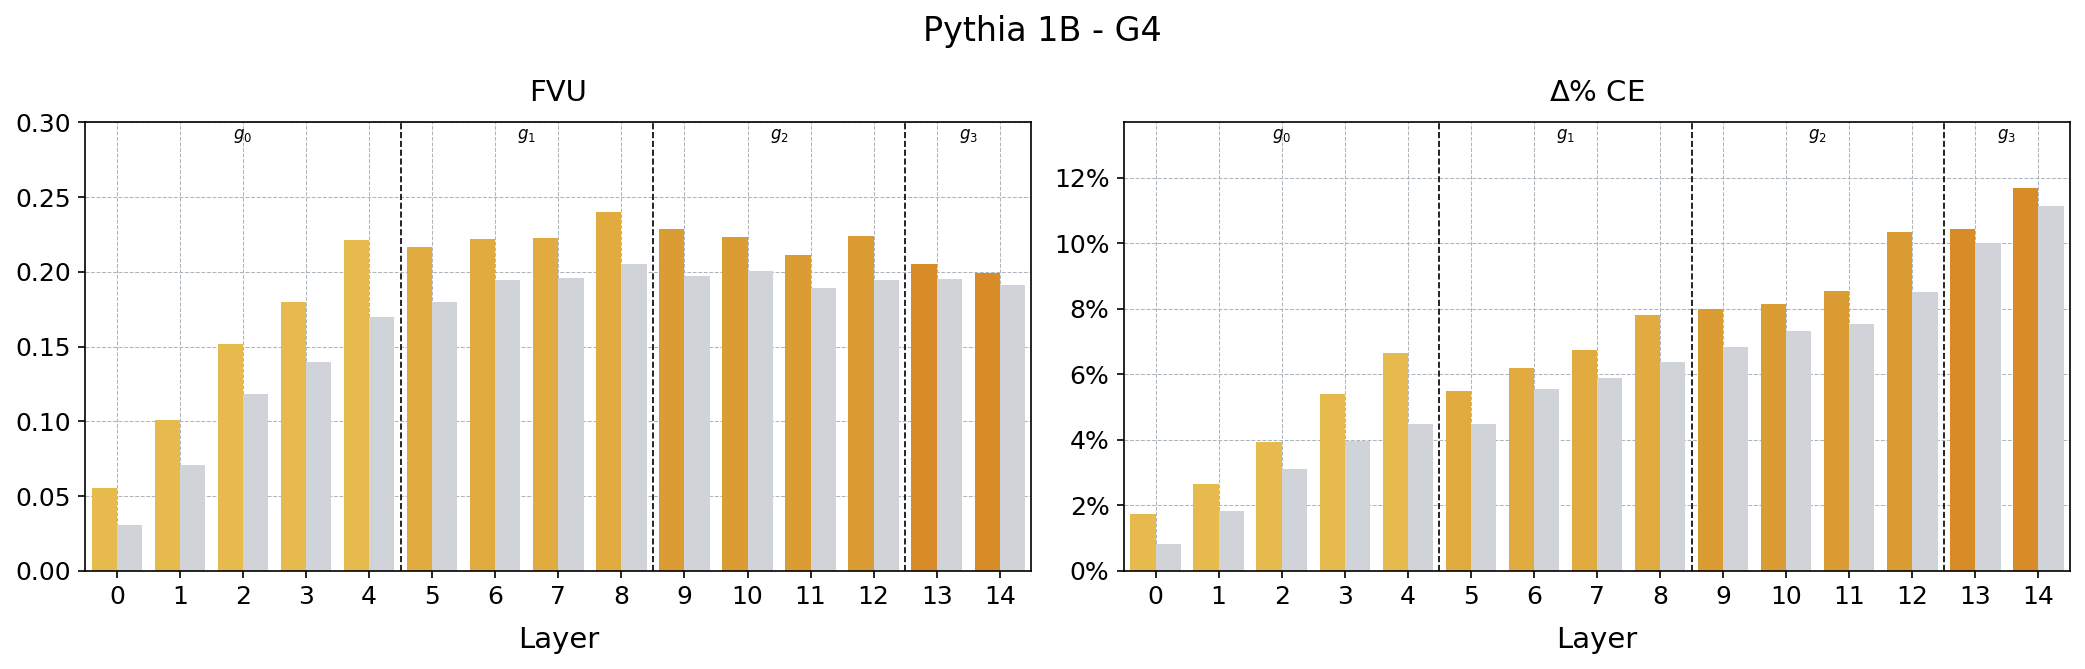

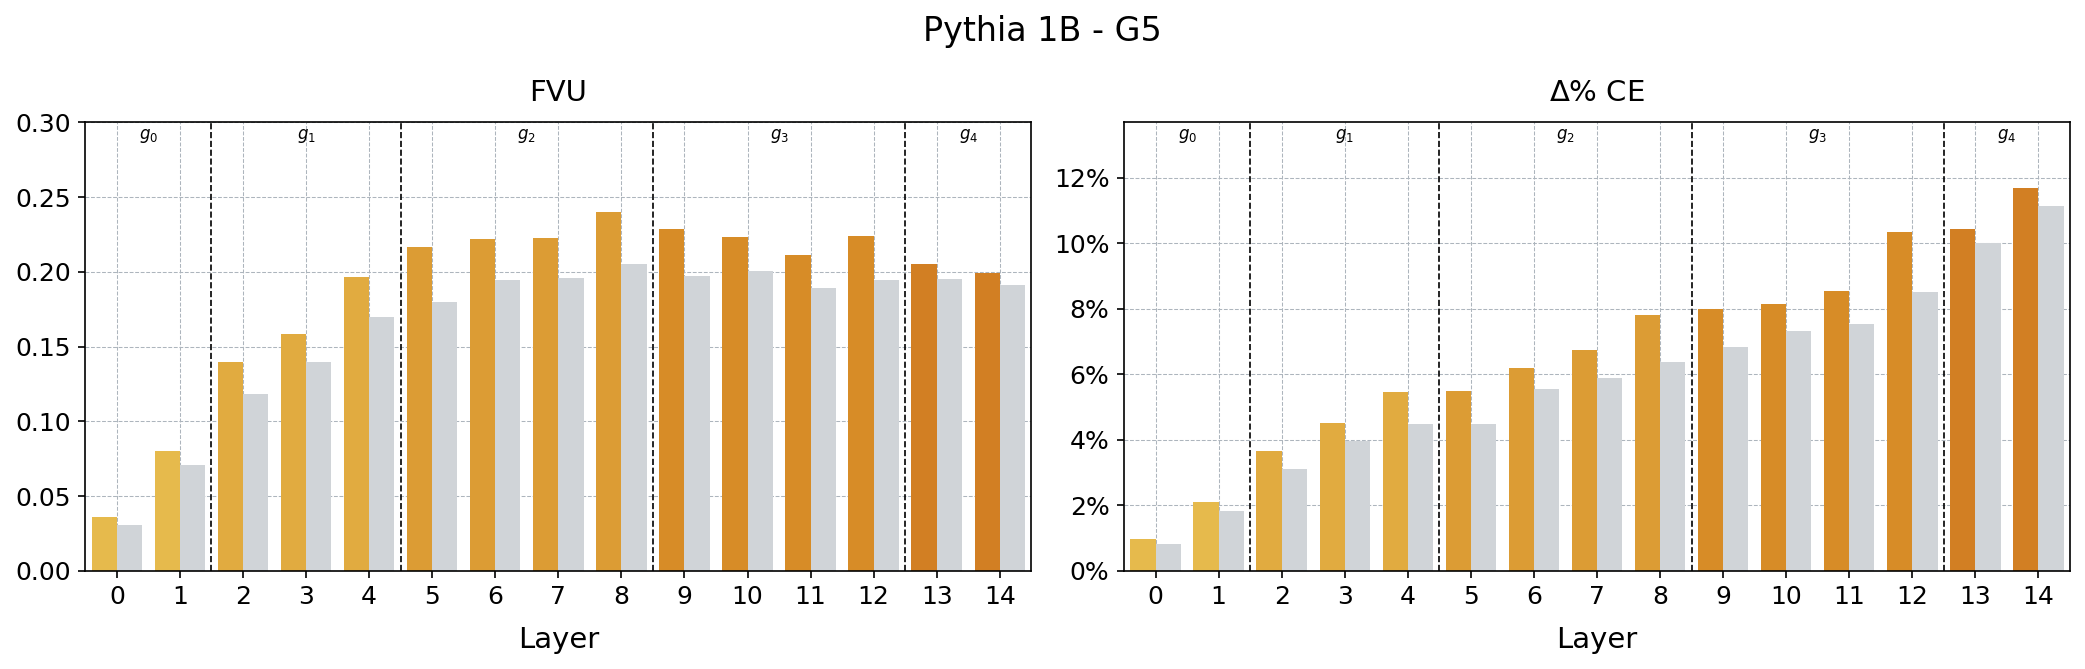

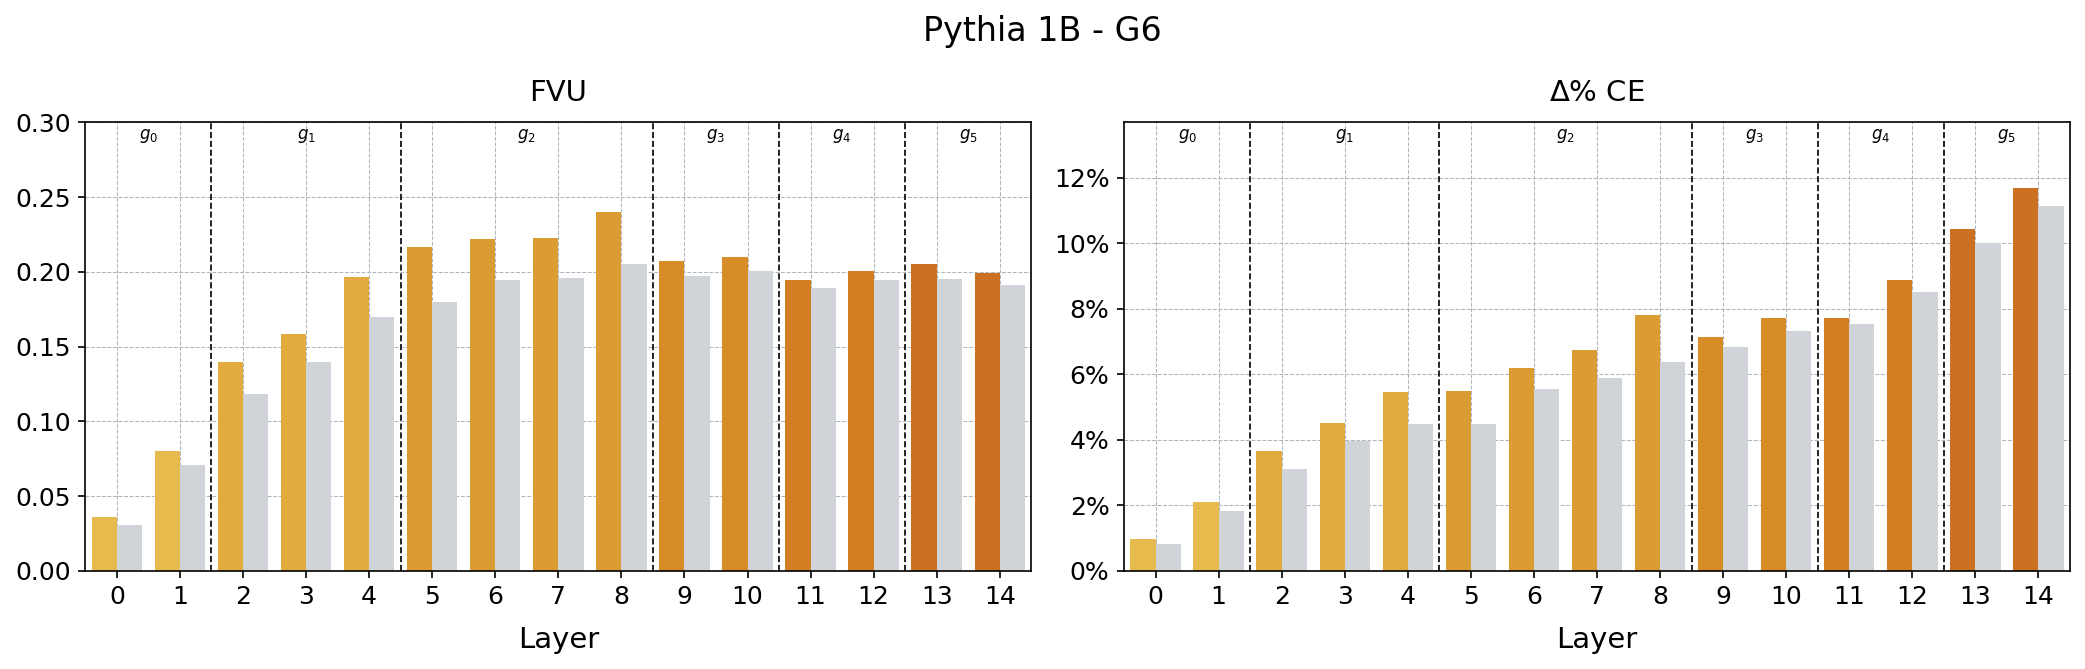

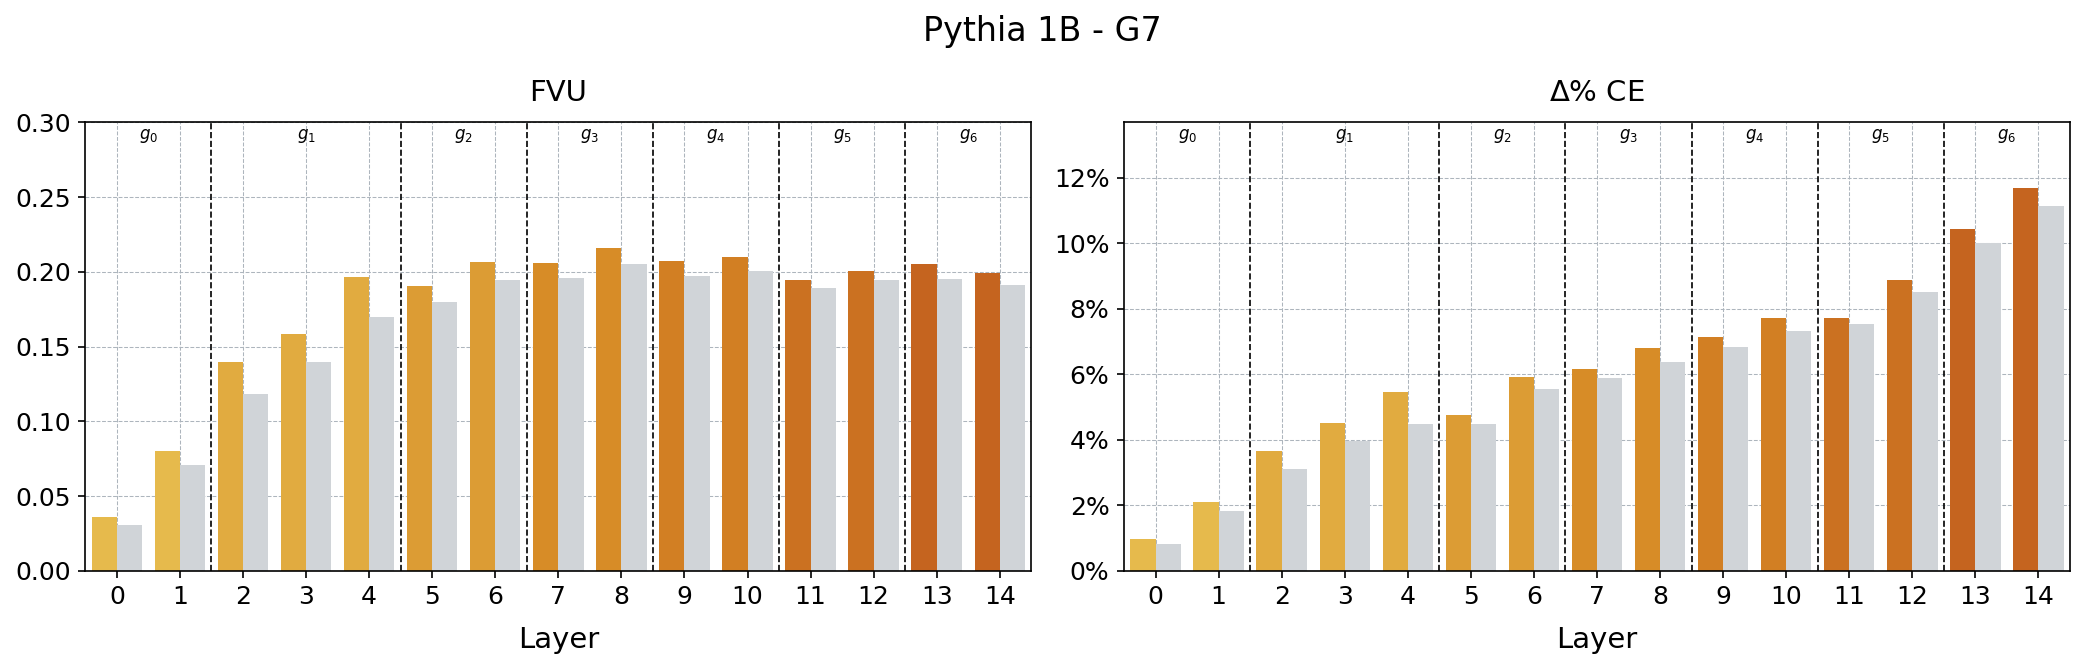

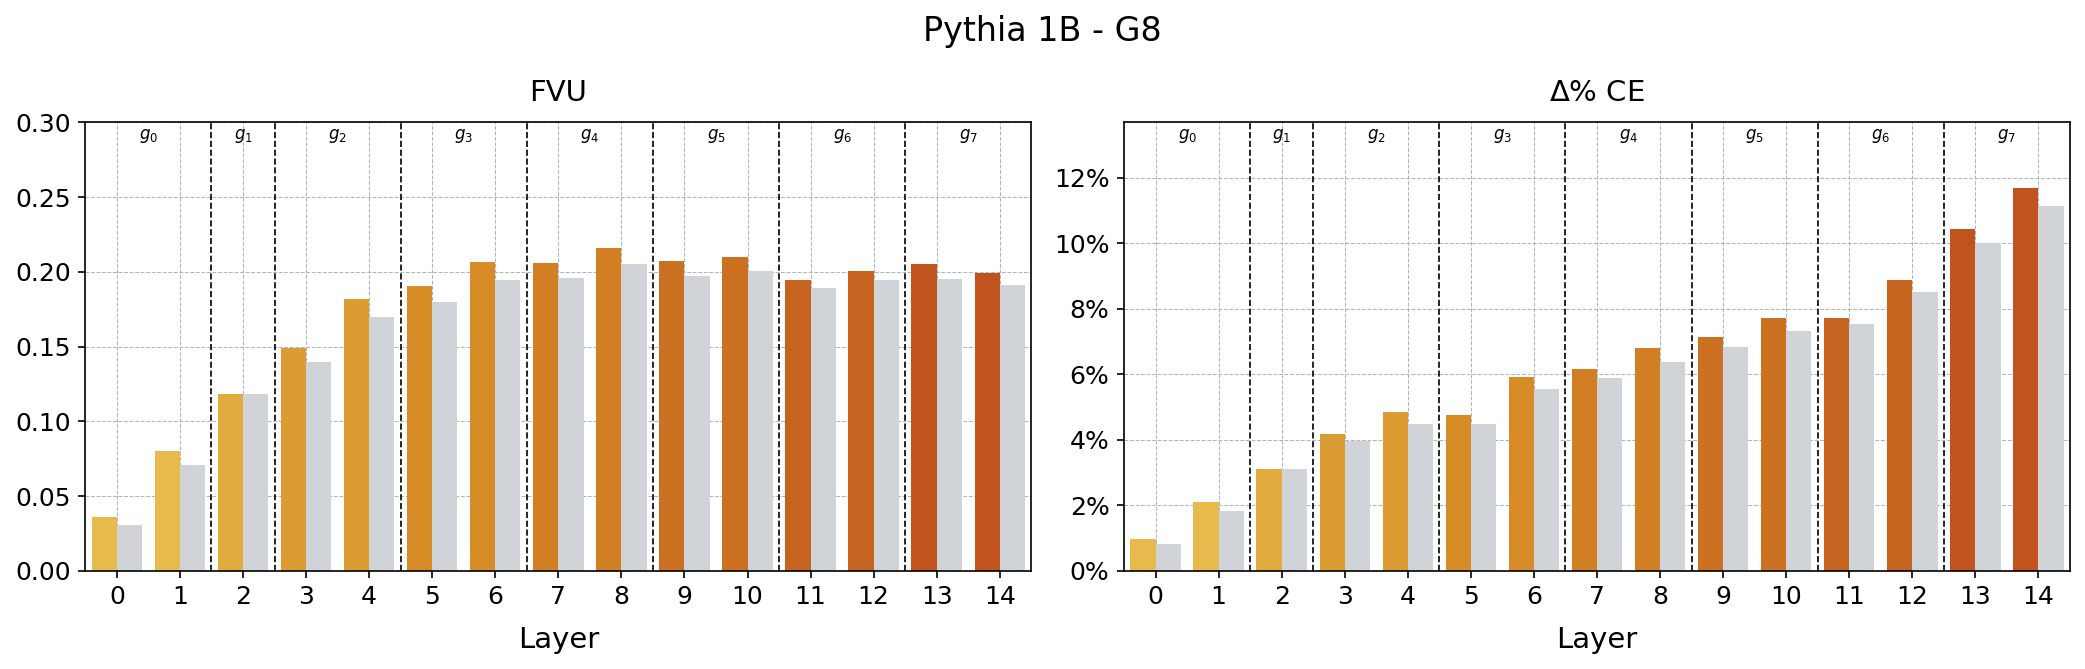

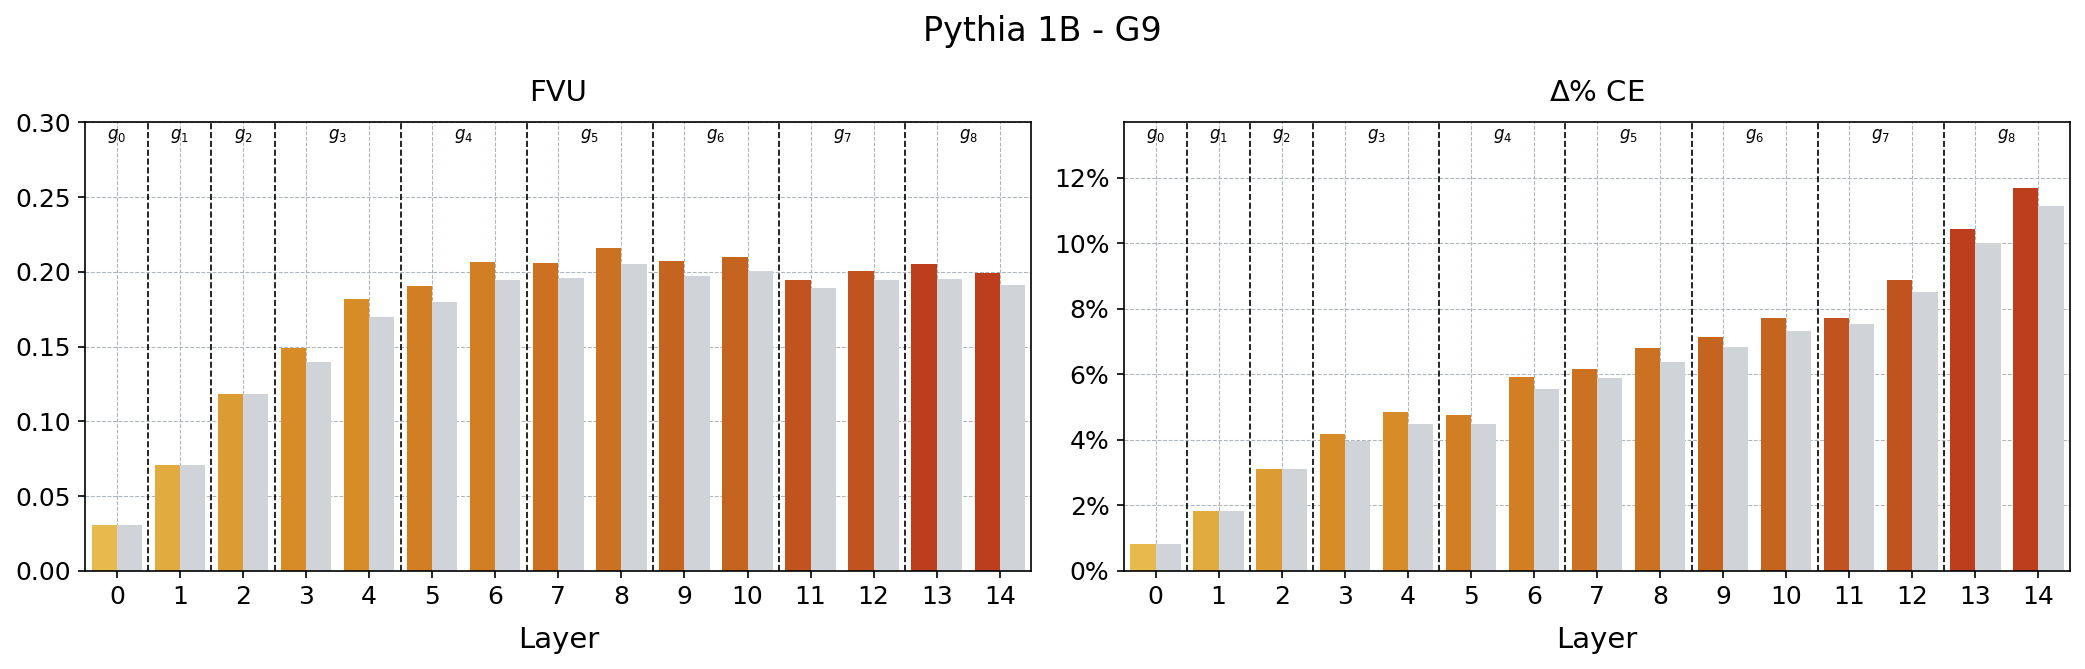

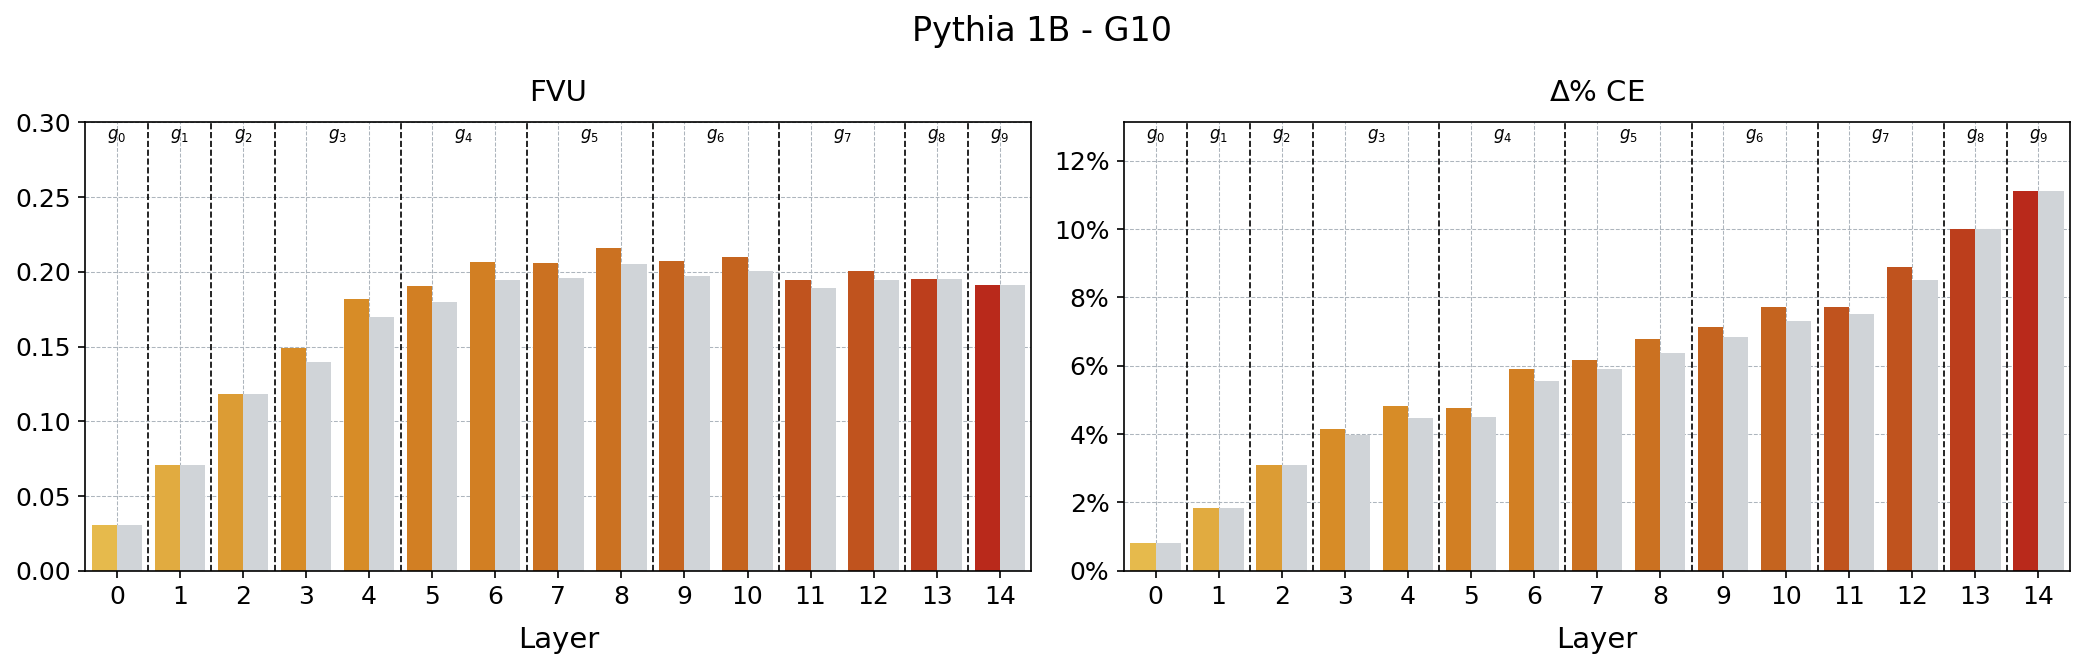

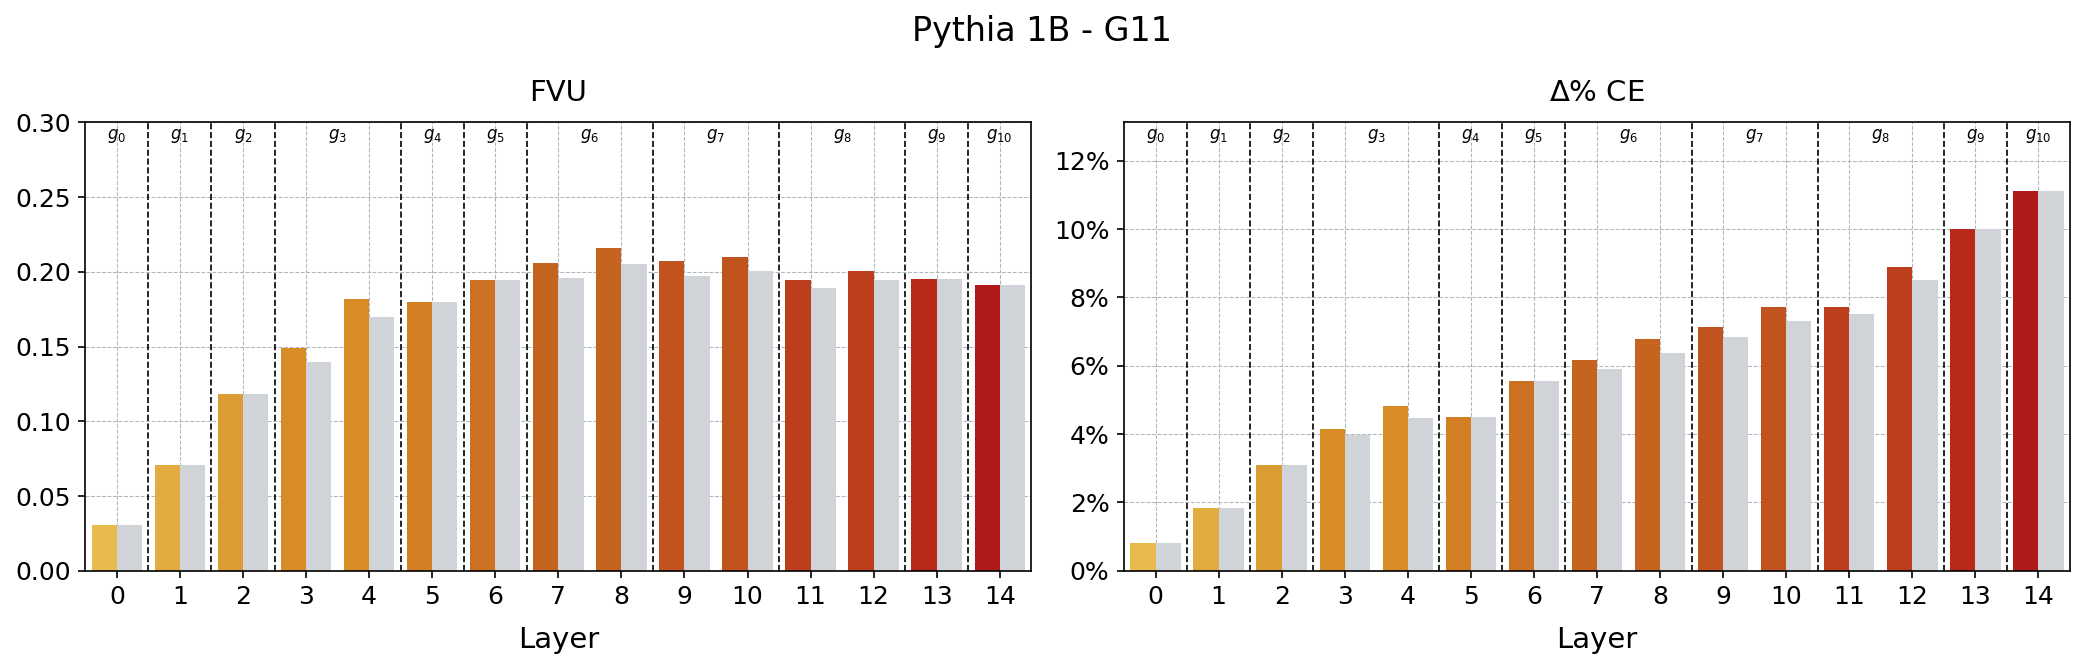

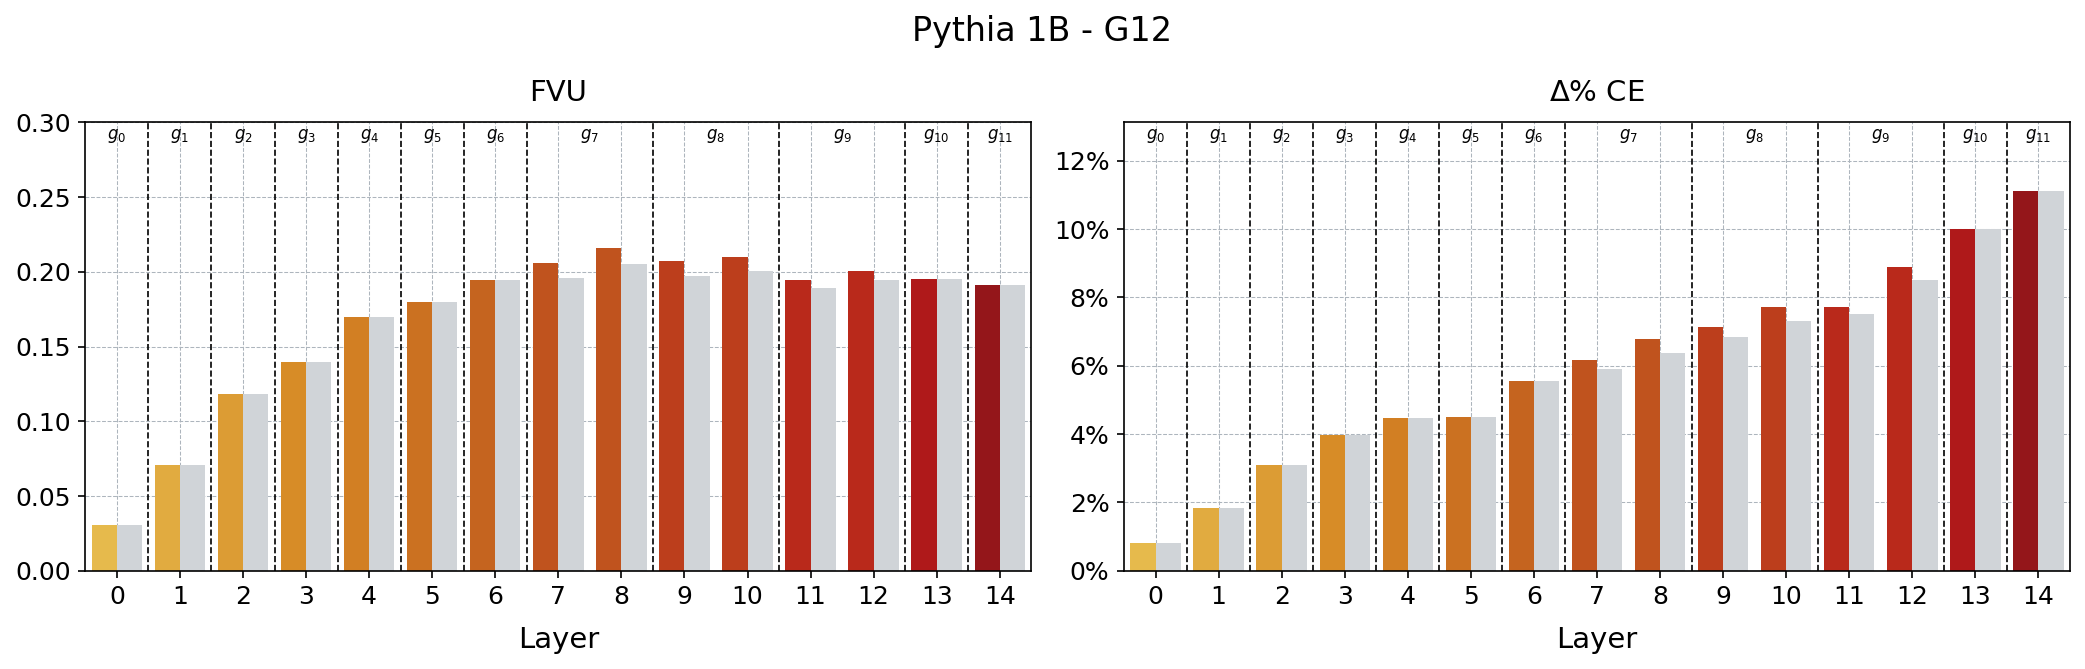

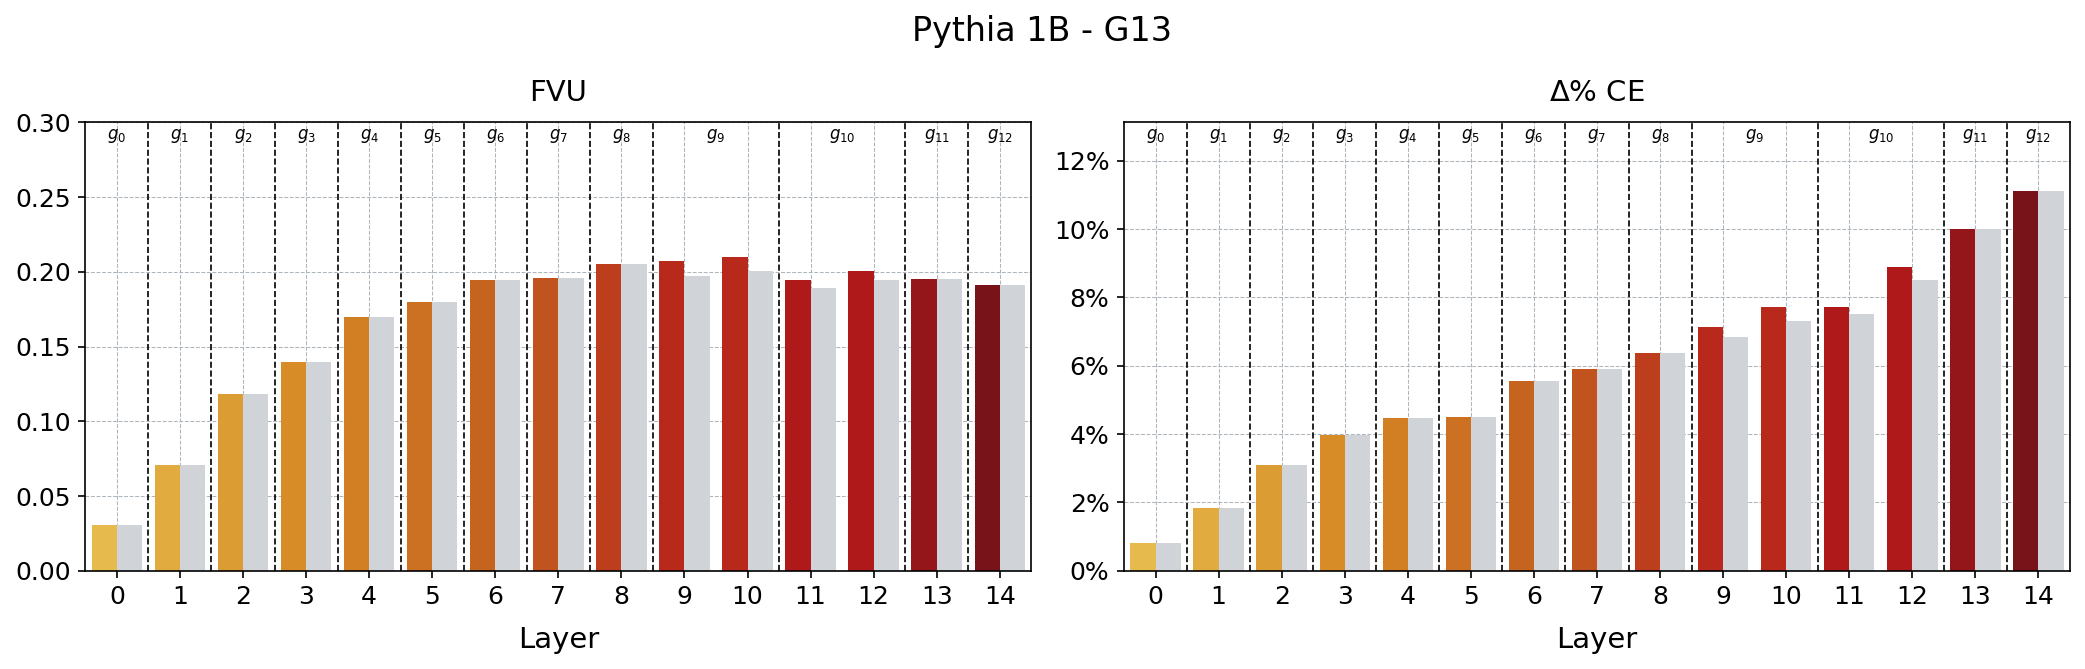

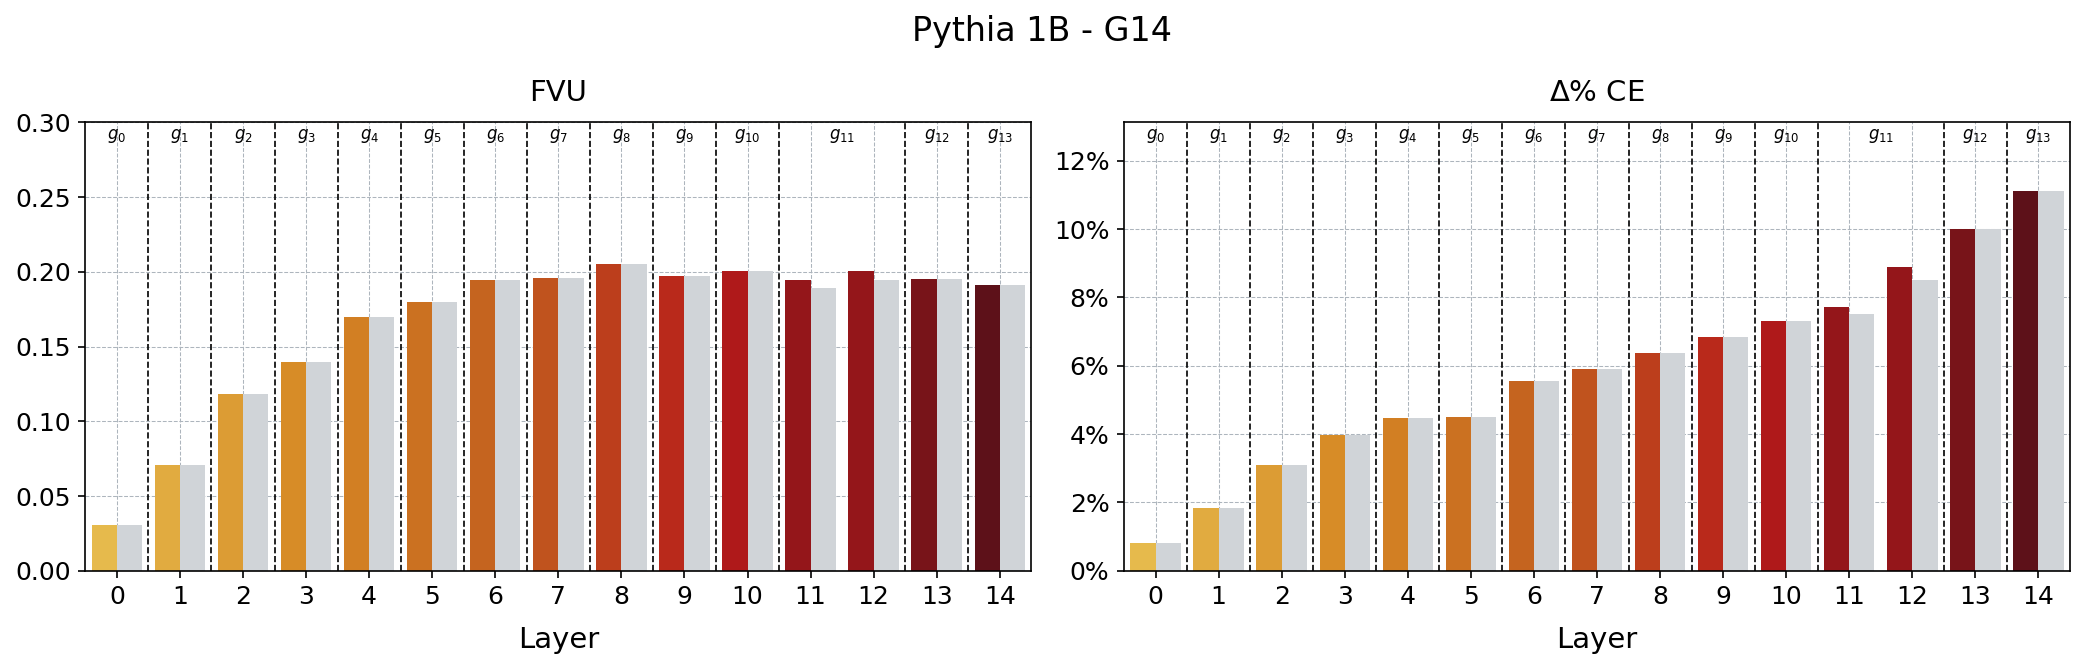

In [22]:
for size in ["160M", "410M", "1B"]:
    for G in range(1, MODEL_MAP[f"pythia-{size.lower()}"]["n_layers"] - 1):
        plot_reconstruction_single_layer(size, G, save=True)

In [23]:
suptitle_fontsize = 16
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12
annot_fontsize = 7

label_pad = 8
title_pad = 10


def plot_reconstruction_average(size, save=False, over_bar_text: bool = False):
    # Create a figure with 2 subplots in a 1x2 layout
    fig, ax = plt.subplots(1, 2, figsize=(14, 4.5), dpi=150, layout="tight")

    # Get the cluster IDs for the specific k value
    size = size.upper()
    n_layers = MODEL_MAP[f"pythia-{size.lower()}"]["n_layers"]
    eval_df = eval_dict[size].groupby("G").mean()
    g_label = list(range(1, n_layers - 1)) + ["B"]
    eval_df["G_label"] = g_label

    # Generate the expanded palette by interpolating between the base colors
    expanded_palette = sns.blend_palette(palette, n_colors=n_layers - 2)
    expanded_palette.append("#ced4da")
    for i, metric in enumerate(["fvu", "delta_ce"]):

        sns.barplot(
            data=eval_df,
            x="G_label",
            hue="G_label",
            y=metric,
            ax=ax[i],
            zorder=2,
            palette=expanded_palette,
            legend=False,
        )

        baseline_value = eval_df.loc[eval_df["G_label"] == "B", metric].iloc[0]
        if over_bar_text:
            for j, patch in enumerate(ax[i].patches):
                current_label = g_label[j]
                current_value = patch.get_height()
                # Calculate the delta percentage with respect to the baseline.
                delta_pct = (current_value - baseline_value) / baseline_value * 100

                # For the baseline bar you may simply show "0%"; for others, include a '+' sign if nonnegative.
                text = (
                    "0%"
                    if current_label == "B"
                    else f"{'+' if delta_pct >= 0 else ''}{delta_pct:.1f}%"
                )

                # Position the text: center of the bar horizontally, and just above the bar.
                x = patch.get_x() + patch.get_width() / 2.0
                y = current_value + offset_map[metric]
                ax[i].text(x, y, text, ha="center", va="bottom", fontsize=annot_fontsize)

        ylims = (0, 0.3) if metric == "fvu" else (0, eval_df["delta_ce"].max() + 2)
        ax[i].set_title(ylabel_map[metric], pad=title_pad, fontsize=label_fontsize)
        ax[i].set_ylim(ylims)
        ax[i].set_xlabel("G", labelpad=label_pad, fontsize=label_fontsize)
        ax[i].set_ylabel("")
        ax[i].tick_params(axis="x", labelsize=tick_fontsize)
        ax[i].tick_params(axis="y", labelsize=tick_fontsize)
        ax[i].grid(color="#adb5bd", linestyle="--", linewidth=0.5)

        # For the right plot, add a plus sign and percent symbol to the y-tick labels
        if i == 1:
            ax[i].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}%"))

    plt.suptitle(f"Pythia {size}", fontsize=suptitle_fontsize)
    plt.subplots_adjust(hspace=0.4)

    if save:
        plt.savefig(f"imgs/avg_recon_{size}.pdf", dpi=300, bbox_inches="tight")

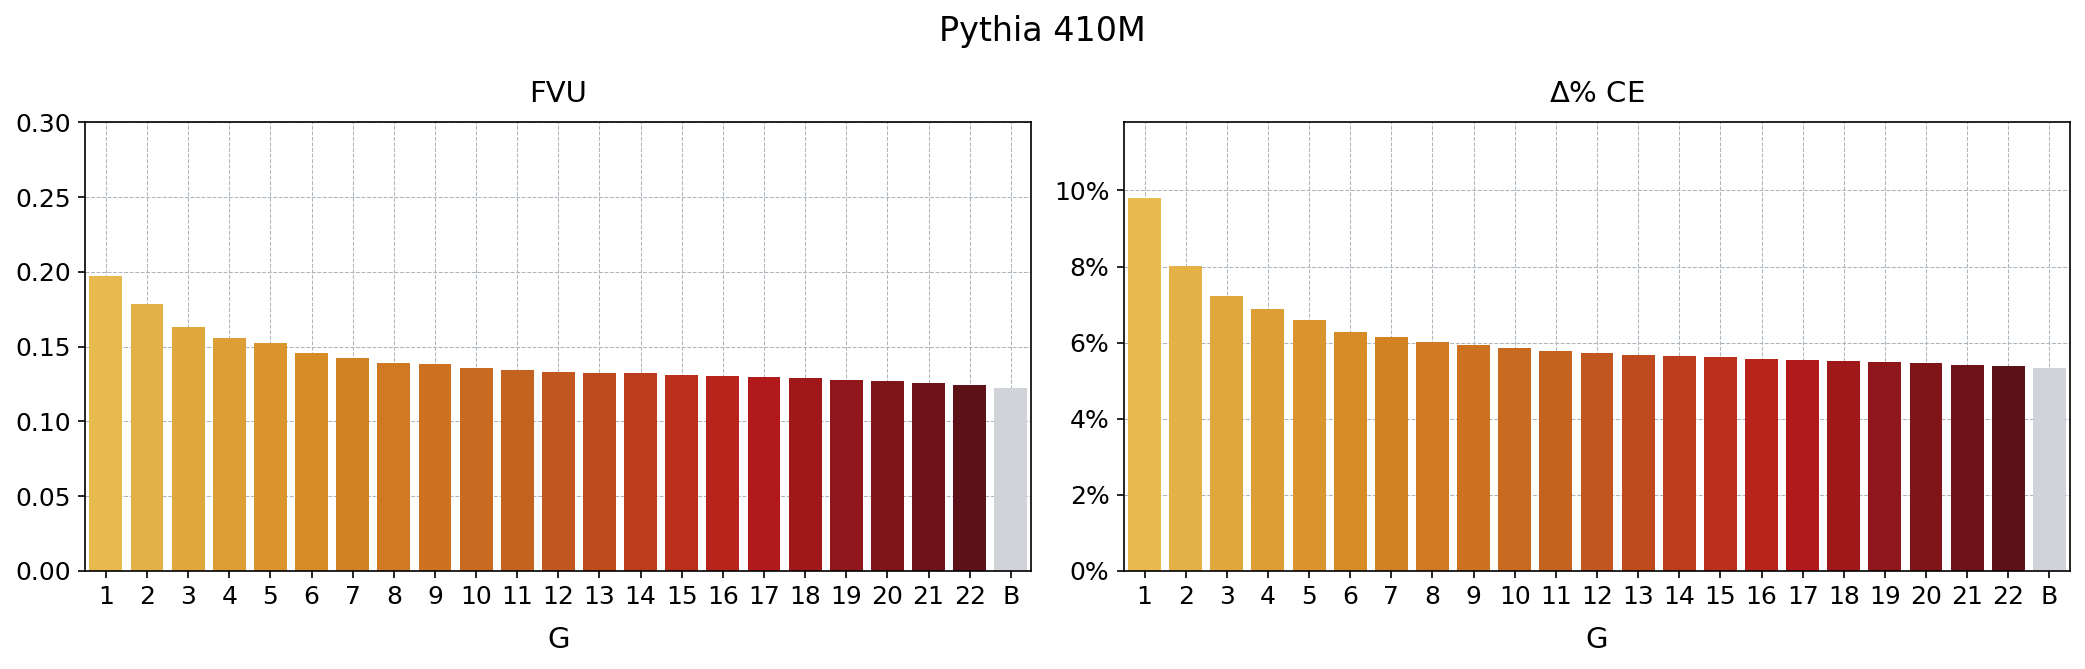

In [24]:
plot_reconstruction_average("410M")

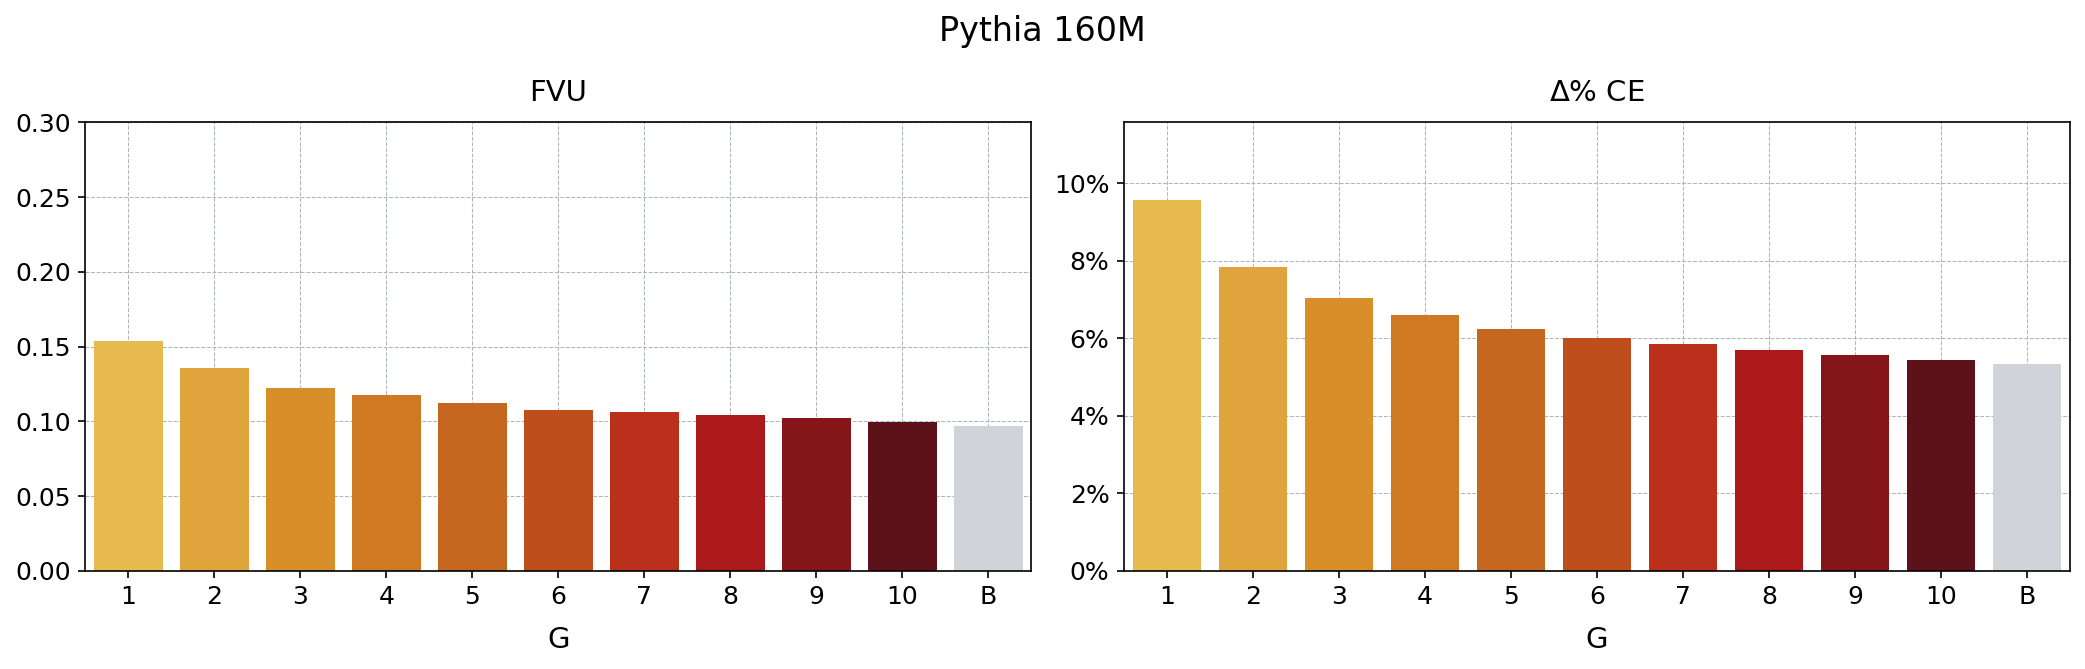

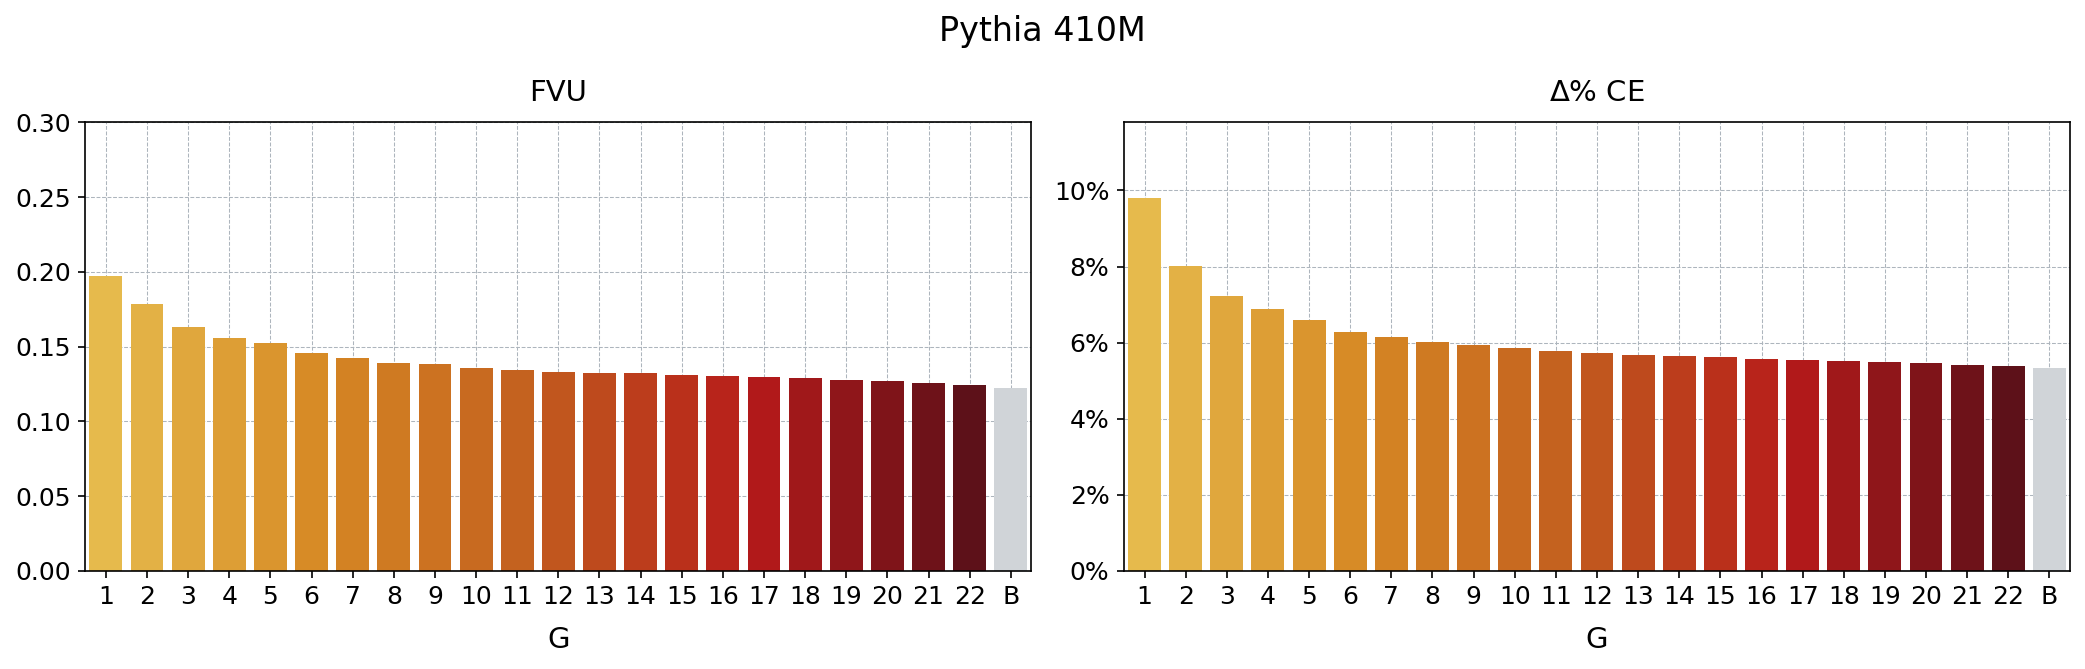

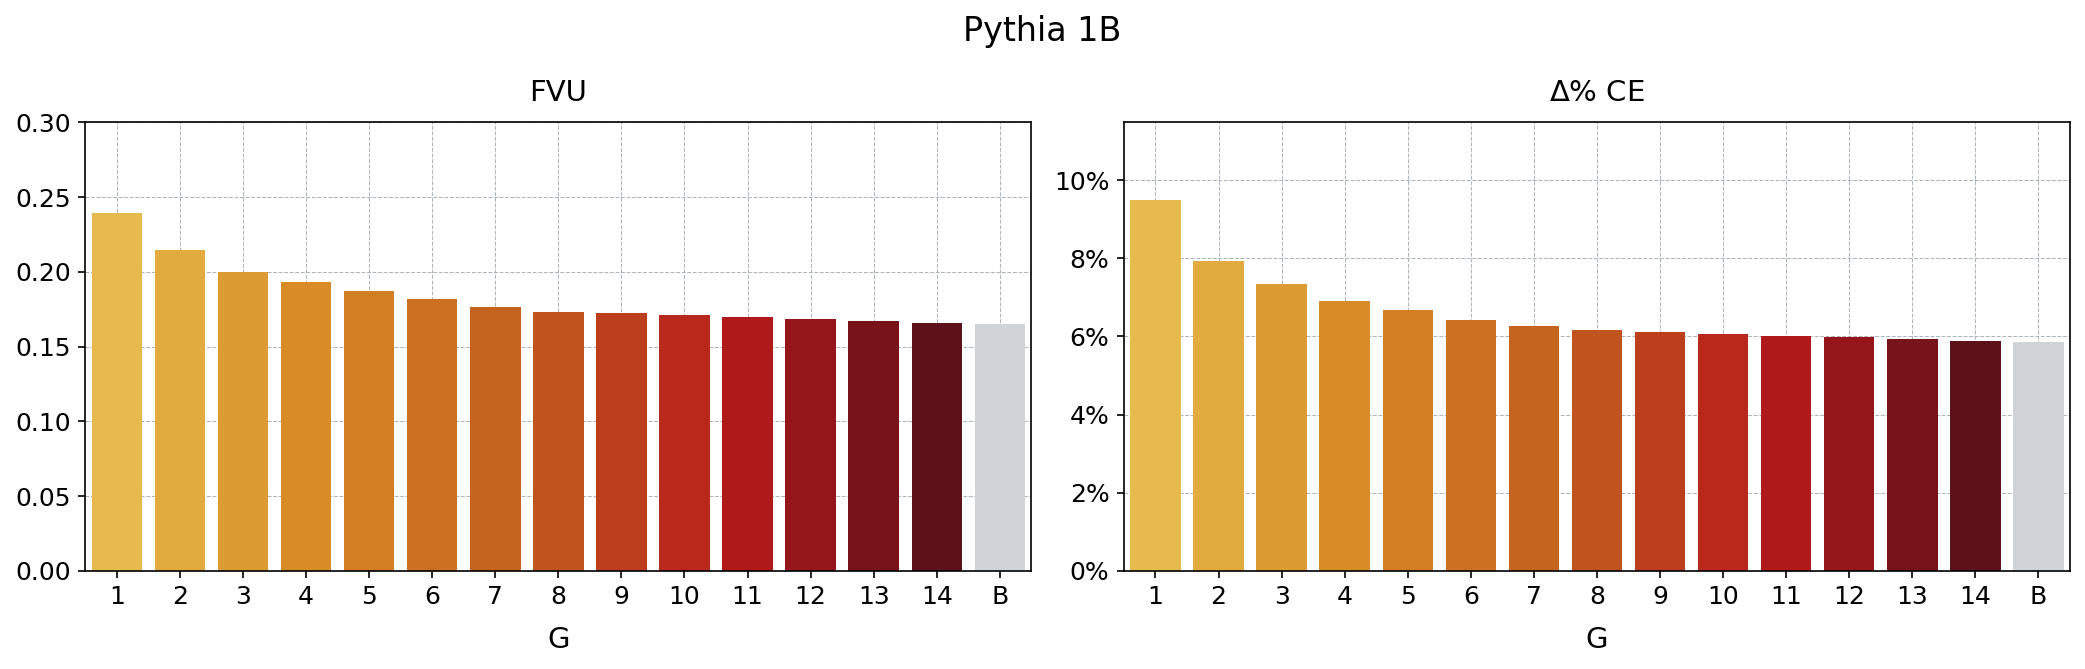

In [25]:
for size in ['160M', '410M', '1B']:
    plot_reconstruction_average(size, save=True)